# Data 로드

In [ ]:
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
import numpy as np

In [ ]:
df = pd.read_csv('train.csv', encoding = 'utf-8')
df_eda = pd.read_csv('train.csv', encoding = 'utf-8')

# 데이터셋 자료구조 조사

# 결측치 조사 : wtcd 에 11개의 결측치 존재함
    - wtcd 와 label 간에 유의미한 상관관계가 있다면 채워볼 수 있음
    - 어떻게 처리할지 정하기에 앞서, wtcd 와 label 간 상관관계 분석을 위해 eda 위한 데이터 셋에는 일단 결측치 없앰

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   index    10000 non-null  int64  
 1   Num      10000 non-null  object 
 2   prod     10000 non-null  object 
 3   insp     10000 non-null  object 
 4   date     10000 non-null  object 
 5   buydate  10000 non-null  object 
 6   ingr_A   10000 non-null  float64
 7   ingr_B   10000 non-null  float64
 8   ingr_C   10000 non-null  float64
 9   wtcd     9989 non-null   object 
 10  gram     10000 non-null  float64
 11  label    10000 non-null  int64  
dtypes: float64(4), int64(2), object(6)
memory usage: 937.6+ KB


In [ ]:
df_eda = df_eda.dropna(subset=['wtcd'])
df_eda.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9989 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   index    9989 non-null   int64  
 1   Num      9989 non-null   object 
 2   prod     9989 non-null   object 
 3   insp     9989 non-null   object 
 4   date     9989 non-null   object 
 5   buydate  9989 non-null   object 
 6   ingr_A   9989 non-null   float64
 7   ingr_B   9989 non-null   float64
 8   ingr_C   9989 non-null   float64
 9   wtcd     9989 non-null   object 
 10  gram     9989 non-null   float64
 11  label    9989 non-null   int64  
dtypes: float64(4), int64(2), object(6)
memory usage: 1014.5+ KB


# 불량품/정상제품 비율 : 불량품 비율이 큼

In [ ]:
df['label'].value_counts()

label
0    7792
1    2208
Name: count, dtype: int64

# 이 외 column 별 비율 살펴보기

# index : 각 제품 별 고유의 index 를 가짐
    - 학습과정에서는 필요없다고 판단

In [ ]:
df['index'].value_counts()

index
2        1
33065    1
33012    1
33030    1
33037    1
        ..
16538    1
16544    1
16555    1
16559    1
49997    1
Name: count, Length: 10000, dtype: int64

In [ ]:
df = df.drop('index', axis = 1)
df_eda = df_eda.drop('index', axis = 1)

# Num : 제품 별 고유의 제품번호를 가짐
    - 생산지 정보 포함
    - 생산지 별도 컬럼으로 추가

In [ ]:
df['Num'].value_counts()

Num
20230618산천074246A    1
20230607산천078636A    1
20230422오포063373A    1
20230426산천048281A    1
20230519오포098984A    1
                    ..
20230419창하014913A    1
20230504오포020450A    1
20230602수성050928C    1
20230421오포038324A    1
20230403오포082212A    1
Name: count, Length: 10000, dtype: int64

In [ ]:
df['생산지'] = df['Num'].str[8:10]
label_column = df.pop('label')
df['label'] = label_column

df_eda['생산지'] = df_eda['Num'].str[8:10]
label_column = df_eda.pop('label')
df_eda['label'] = label_column

df = df.drop('Num', axis = 1)
df_eda = df_eda.drop('Num', axis = 1)

# prod : 제품종류/그룹 총 4개

In [ ]:
df['prod'].value_counts()

prod
KCMD    5481
JJBB    2140
GBMD    1793
GGMD     586
Name: count, dtype: int64

# insp : 검수자 5명이 모든 제품 검수

In [ ]:
df['insp'].value_counts()

insp
L    3022
C    2495
K    2445
Y    1539
P     499
Name: count, dtype: int64

# date, buydate : 검수일자, 구입일자 의 범위

In [ ]:
print('검수 일자 :', df['date'].min(), '~', df['date'].max())
print('구입 일자 :', df['buydate'].min(), '~', df['buydate'].max())

검수 일자 : 2023-04-01 ~ 2023-06-29
구입 일자 : 2023-04-02 ~ 2024-08-29


# wtcd : 수원지 총 3개 존재

In [ ]:
df['wtcd'].value_counts()

wtcd
F3    6851
F2    2170
F1     968
Name: count, dtype: int64

# ingr_A + ingr_B + ingr_C > gram (잘못된 data) : 2개 존재

In [ ]:
# 조건을 만족하지 않는 행의 개수 계산
invalid_rows = df[df['ingr_A'] + df['ingr_B'] + df['ingr_C'] > df['gram']]

invalid_rows

prod insp        date     buydate    ingr_A   ingr_B  ingr_C wtcd  \
1500  JJBB    K  2023-04-20  2023-06-17  319.0863  64811.0  6.7270  NaN   
4750  GBMD    L  2023-04-14  2023-10-12  321.9846  74528.0  6.1506  NaN   

         gram 생산지  label  
1500  1972.70  오포      0  
4750   897.94  오포      0

# 아웃라이어 판별 : Numeric 값들 대상

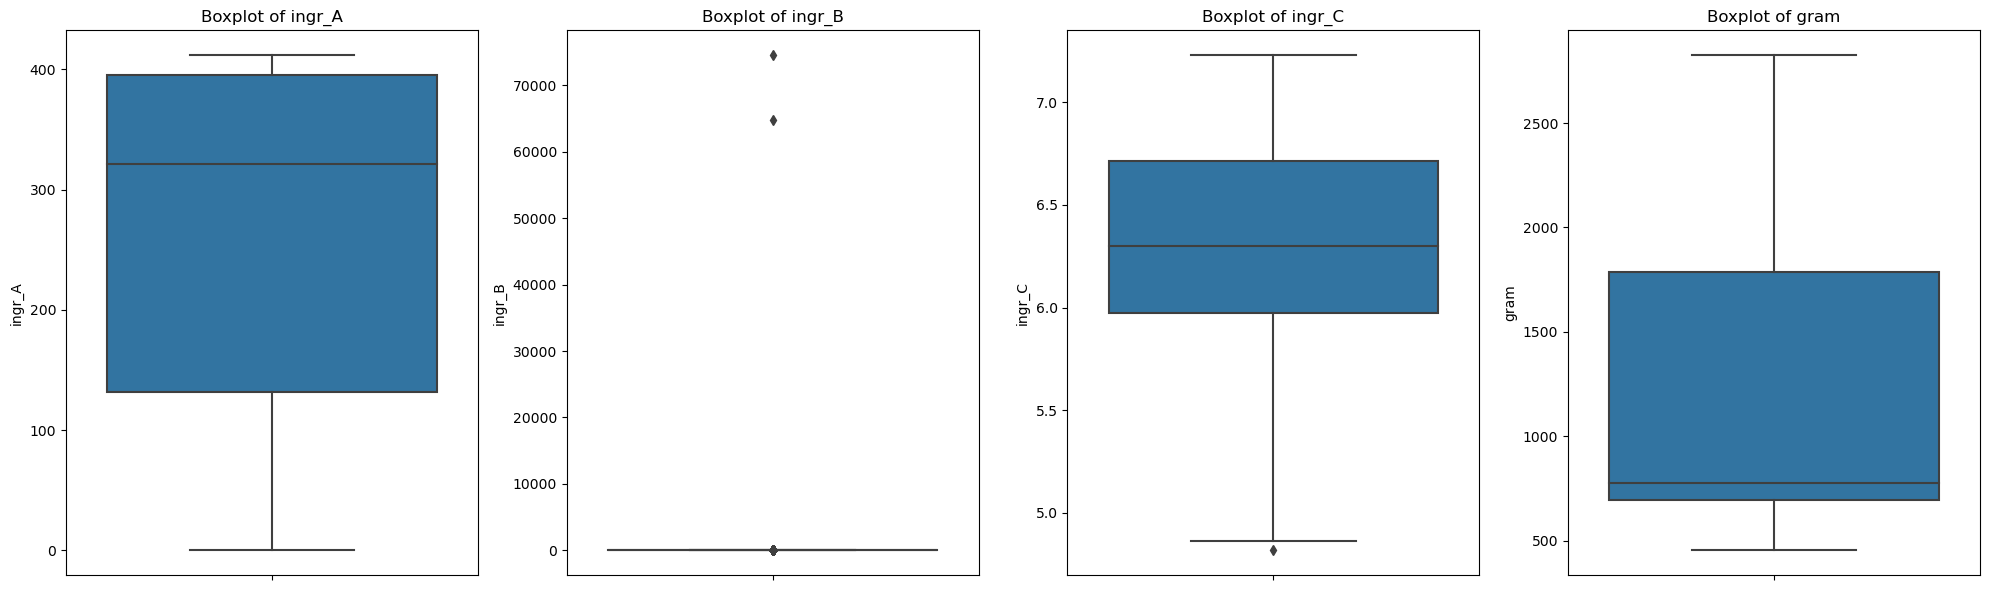

In [ ]:
plt.figure(figsize=(20, 6))

# ingr_A
plt.subplot(1, 4, 1)
sns.boxplot(y=df['ingr_A'])
plt.title('Boxplot of ingr_A')

# ingr_B
plt.subplot(1, 4, 2)
sns.boxplot(y=df['ingr_B'])
plt.title('Boxplot of ingr_B')

# ingr_C
plt.subplot(1, 4, 3)
sns.boxplot(y=df['ingr_C'])
plt.title('Boxplot of ingr_C')

# gram
plt.subplot(1, 4, 4)
sns.boxplot(y=df['gram'])
plt.title('Boxplot of gram')

plt.tight_layout()
plt.show()

In [ ]:
# numeric 한 컬럼들 선택
columns_to_check = ['ingr_A', 'ingr_B', 'ingr_C', 'gram']

# 각 컬럼에 대해 아웃라이어 확인
for column in columns_to_check:
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    # 아웃라이어 기준
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # 아웃라이어 여부 확인
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    print(f"Number of outliers in {column}: {outliers.shape[0]}")
    if outliers.shape[0] > 0:
        print(f"Outliers in {column}:")
        print(outliers)


Number of outliers in ingr_A: 0
Number of outliers in ingr_B: 365
Outliers in ingr_B:
      prod insp        date     buydate    ingr_A  ingr_B  ingr_C wtcd  \
19    KCMD    Y  2023-05-25  2023-05-28  131.5341  7.6237  6.1441   F2   
126   KCMD    C  2023-05-11  2023-07-27  131.5033  8.1214  6.3345   F3   
142   KCMD    L  2023-04-18  2023-06-02  328.8631  7.6291  5.9251   F3   
231   KCMD    C  2023-04-01  2023-06-23  319.3958  7.6116  5.9205   F3   
330   GBMD    K  2023-05-13  2023-09-12  128.2071  7.6461  5.7838   F3   
...    ...  ...         ...         ...       ...     ...     ...  ...   
9834  JJBB    K  2023-05-18  2023-05-24  128.5616  7.9042  6.1051   F3   
9867  GBMD    L  2023-05-18  2023-08-01  131.0780  7.8765  5.6954   F3   
9940  GGMD    L  2023-05-24  2023-08-15  130.5707  7.6631  5.7527   F3   
9941  KCMD    K  2023-05-13  2023-05-18  128.2441  7.8521  6.0435   F3   
9969  GBMD    K  2023-05-16  2023-09-04  128.6390  7.6411  5.3594   F3   

         gram 생산지  label 

# 아웃라이어 처리 : 아웃라이어를 최대/최소값으로 붙이기
    - 처리 후 ingr_A + ingr_B + ingr_C <= gram 을 성립하지 않는 레코드 있는지 확인

In [ ]:
columns_to_check = ['ingr_B', 'ingr_C']

# 각 컬럼에 대해 아웃라이어 수정
for column in columns_to_check:
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    # 아웃라이어 기준
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # 아웃라이어를 lower_bound와 upper_bound로 대체
    df[column] = df[column].clip(lower=lower_bound, upper=upper_bound)

# 결과 확인
print(df[columns_to_check].describe())


             ingr_B        ingr_C
count  10000.000000  10000.000000
mean       6.368758      6.310805
std        0.536859      0.431920
min        5.138600      4.859900
25%        5.971750      5.972075
50%        6.273400      6.299300
75%        6.620625      6.713525
max        7.593937      7.230900


In [ ]:
columns_to_check = ['ingr_B', 'ingr_C']

# 각 컬럼에 대해 아웃라이어 수정
for column in columns_to_check:
    Q1 = df_eda[column].quantile(0.25)
    Q3 = df_eda[column].quantile(0.75)
    IQR = Q3 - Q1

    # 아웃라이어 기준
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # 아웃라이어를 lower_bound와 upper_bound로 대체
    df_eda[column] = df_eda[column].clip(lower=lower_bound, upper=upper_bound)

# 결과 확인
print(df_eda[columns_to_check].describe())


            ingr_B       ingr_C
count  9989.000000  9989.000000
mean      6.368376     6.310660
std       0.536414     0.431964
min       5.138600     4.859500
25%       5.971000     5.971900
50%       6.273200     6.299100
75%       6.619000     6.713500
max       7.591000     7.230900


In [ ]:
# 조건을 만족하지 않는 행의 개수 계산
invalid_rows = df[df['ingr_A'] + df['ingr_B'] + df['ingr_C'] > df['gram']]

invalid_rows

Empty DataFrame
Columns: [prod, insp, date, buydate, ingr_A, ingr_B, ingr_C, wtcd, gram, 생산지, label]
Index: []

# 결측치 처리 위해 wtcd 와 다른 컬럼들 간의 관계성 파악

# 결측치 처리 : wtcd -> prod, insp, 생산지, label (Categorical data -> 크래머 계수)

In [ ]:
def cramers_v(x, y):
    contingency_table = pd.crosstab(x, y)
    chi2, _, _, _ = chi2_contingency(contingency_table)
    n = contingency_table.sum().sum()
    phi2 = chi2 / n
    r, k = contingency_table.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    r_corr = r - ((r-1)**2)/(n-1)
    k_corr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((k_corr-1), (r_corr-1)))

In [ ]:
# column1 고정
column1 = 'wtcd'

# column2 리스트
columns_to_check = ['prod', 'insp', '생산지', 'label']

# 각 컬럼과 wtcd 간의 크래머의 V 계산
for column2 in columns_to_check:
    v = cramers_v(df_eda[column1], df_eda[column2])
    print(f"Cramer's V between {column1} and {column2}: {v}")


Cramer's V between wtcd and prod: 0.0
Cramer's V between wtcd and insp: 0.38511896494222914
Cramer's V between wtcd and 생산지: 0.016614772617886624
Cramer's V between wtcd and label: 0.08332453344514486


# 결측치 처리 : wtcd -> date, buydate (크래머 계수)

In [ ]:
df_eda_temp = df_eda.copy()
df_eda_temp['date'] = df_eda_temp['date'].str[5:7]
df_eda_temp['buydate'] = df_eda_temp['buydate'].str[5:7]

In [ ]:
# column1 고정
column1 = 'wtcd'

# column2 리스트
columns_to_check = ['date', 'buydate']

# 각 컬럼과 wtcd 간의 크래머의 V 계산
for column2 in columns_to_check:
    v = cramers_v(df_eda_temp[column1], df_eda_temp[column2])
    print(f"Cramer's V between {column1} and {column2}: {v}")


Cramer's V between wtcd and date: 0.012561045327338234
Cramer's V between wtcd and buydate: 0.0


# 결측치 처리 : wtcd -> buydate(계절) (크래머 계수)

In [ ]:
def map_season(month):
    if month in ['03', '04', '05']:
        return '봄'
    elif month in ['06', '07', '08']:
        return '여름'
    elif month in ['09', '10', '11']:
        return '가을'
    else:  # '12', '01', '02'
        return '겨울'

# 'buydate' 컬럼에 함수 적용
df_eda_temp['season'] = df_eda_temp['buydate'].apply(map_season)

# 결과 확인
df_eda_temp.head()

prod insp date buydate    ingr_A  ingr_B  ingr_C wtcd     gram 생산지  label  \
0  GBMD    C   06      09  399.4063  6.4035  6.9409   F3   970.32  산천      1   
1  GGMD    L   05      07  130.0951  5.8245  6.2857   F1  2490.08  창하      0   
2  KCMD    C   05      07  131.5192  5.8040  6.0607   F3   487.37  창하      0   
3  GBMD    K   05      06  128.5978  6.8720  6.1705   F3   707.94  산천      1   
4  JJBB    K   04      04  320.6915  5.7474  6.3695   F3  1978.66  수성      0   

  season  
0     가을  
1     여름  
2     여름  
3     여름  
4      봄

In [ ]:
# column1 고정
column1 = 'wtcd'

# column2 리스트
column2 = 'season'

# 각 컬럼과 wtcd 간의 크래머의 V 계산
v = cramers_v(df_eda_temp[column1], df_eda_temp[column2])
print(f"Cramer's V between {column1} and {column2}: {v}")

Cramer's V between wtcd and season: 0.0


# 결측치 : wtcd -> ingr_A, ingr_B, ingr_C, gram 의 관계성

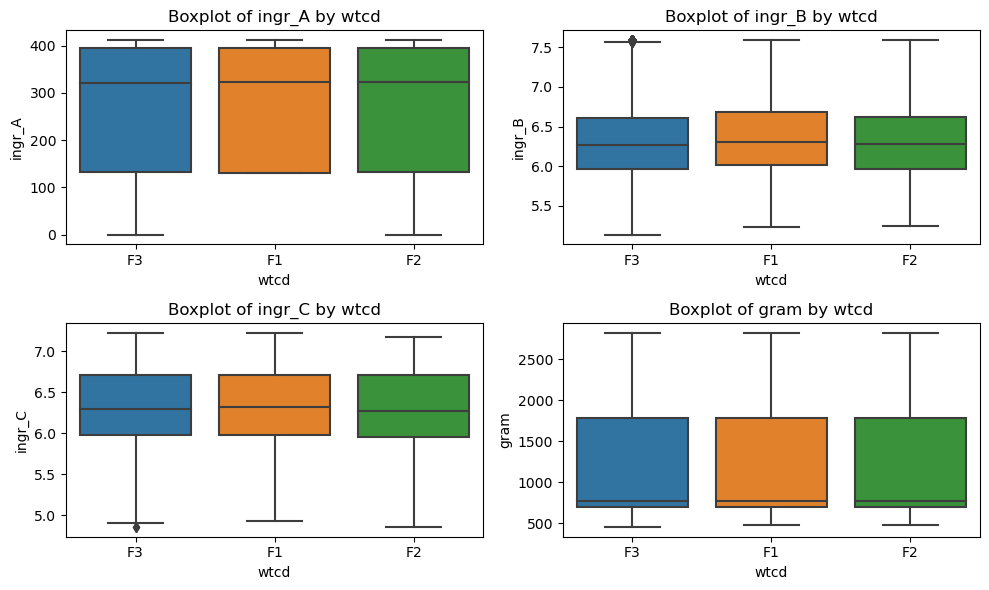

In [ ]:
plt.figure(figsize=(10, 6))

# ingr_A
plt.subplot(2, 2, 1)
sns.boxplot(x='wtcd', y='ingr_A', data=df_eda)
plt.title('Boxplot of ingr_A by wtcd')

# ingr_B
plt.subplot(2, 2, 2)
sns.boxplot(x='wtcd', y='ingr_B', data=df_eda)
plt.title('Boxplot of ingr_B by wtcd')

# ingr_C
plt.subplot(2, 2, 3)
sns.boxplot(x='wtcd', y='ingr_C', data=df_eda)
plt.title('Boxplot of ingr_C by wtcd')

# gram
plt.subplot(2, 2, 4)
sns.boxplot(x='wtcd', y='gram', data=df_eda)
plt.title('Boxplot of gram by wtcd')

plt.tight_layout()
plt.show()

In [ ]:
df = df.dropna(subset = ['wtcd'])
df

prod insp        date     buydate    ingr_A  ingr_B  ingr_C wtcd  \
0     GBMD    C  2023-06-18  2023-09-18  399.4063  6.4035  6.9409   F3   
1     GGMD    L  2023-05-18  2023-07-08  130.0951  5.8245  6.2857   F1   
2     KCMD    C  2023-05-05  2023-07-02  131.5192  5.8040  6.0607   F3   
3     GBMD    K  2023-05-05  2023-06-04  128.5978  6.8720  6.1705   F3   
4     JJBB    K  2023-04-09  2023-04-14  320.6915  5.7474  6.3695   F3   
...    ...  ...         ...         ...       ...     ...     ...  ...   
9995  KCMD    C  2023-06-20  2023-07-08  405.6626  6.2900  6.8467   F3   
9996  GGMD    K  2023-05-15  2023-05-25  129.1664  6.0345  6.5257   F3   
9997  GGMD    L  2023-06-14  2023-09-10  403.9895  6.2698  6.7227   F1   
9998  JJBB    K  2023-04-05  2023-04-16  309.4751  5.7987  6.5499   F3   
9999  JJBB    C  2023-04-03  2023-05-02  328.3941  5.8472  5.9838   F3   

         gram 생산지  label  
0      970.32  산천      1  
1     2490.08  창하      0  
2      487.37  창하      0  
3      707.94  산천      1  
4     1978.66  수성      0  
...       ...  ..    ...  
9995   777.82  산천      0  
9996  2548.73  오포      0  
9997  2769.71  창하      0  
9998  2005.46  산천      0  
9999  1985.14  오포      0  

[9989 rows x 11 columns]

-----데이터 저장하기-----

In [ ]:
df.to_csv('tmp.csv', index=False)
df_eda = df.copy()

# 컬럼 전처리 (for EDA : 분석 위해 최대한 컬럼 많아도 됨)

# 컬럼 전처리 : A/B/C -> 비율 추가 + ingr_extra, extra 의 비율 추가

In [ ]:
# A_P, B_P, C_P 컬럼 추가 (ingr_A/gram, ingr_B/gram, ingr_C/gram)
df_eda['A_P'] = df_eda['ingr_A'] / df_eda['gram']
df_eda['B_P'] = df_eda['ingr_B'] / df_eda['gram']
df_eda['C_P'] = df_eda['ingr_C'] / df_eda['gram']

# ingr_extra 컬럼 추가 (gram - (ingr_A + ingr_B + ingr_C))
df_eda['ingr_extra'] = df_eda['gram'] - (df_eda['ingr_A'] + df_eda['ingr_B'] + df_eda['ingr_C'])

# extra_P 컬럼 추가 (ingr_extra의 전체 gram 대비 비율)
df_eda['extra_P'] = df_eda['ingr_extra'] / df_eda['gram']

# 새로운 컬럼이 추가된 데이터 확인
df_eda.head()


prod insp        date     buydate    ingr_A  ingr_B  ingr_C wtcd     gram  \
0  GBMD    C  2023-06-18  2023-09-18  399.4063  6.4035  6.9409   F3   970.32   
1  GGMD    L  2023-05-18  2023-07-08  130.0951  5.8245  6.2857   F1  2490.08   
2  KCMD    C  2023-05-05  2023-07-02  131.5192  5.8040  6.0607   F3   487.37   
3  GBMD    K  2023-05-05  2023-06-04  128.5978  6.8720  6.1705   F3   707.94   
4  JJBB    K  2023-04-09  2023-04-14  320.6915  5.7474  6.3695   F3  1978.66   

  생산지  label       A_P       B_P       C_P  ingr_extra   extra_P  
0  산천      1  0.411623  0.006599  0.007153    557.5693  0.574624  
1  창하      0  0.052245  0.002339  0.002524   2347.8747  0.942891  
2  창하      0  0.269855  0.011909  0.012436    343.9861  0.705801  
3  산천      1  0.181651  0.009707  0.008716    566.2997  0.799926  
4  수성      0  0.162075  0.002905  0.003219   1645.8516  0.831801

# 컬럼 전처리 : duration, buydate_month, buydate_season, buydate_year 추가

In [ ]:
df_eda['date'] = pd.to_datetime(df_eda['date'])
df_eda['buydate'] = pd.to_datetime(df_eda['buydate'])

# duration 컬럼 추가 (buydate에서 date를 뺀 일수)
df_eda['duration'] = (df_eda['buydate'] - df_eda['date']).dt.days

# date_month 컬럼 추가 (해당하는 달)
df_eda['date_month'] = df_eda['date'].dt.month

# buydate_month 컬럼 추가 (해당하는 달)
df_eda['buydate_month'] = df_eda['buydate'].dt.month

# buydate_season 컬럼 추가 (년도와 계절)
seasons = {1: 'Winter', 2: 'Winter', 3: 'Spring', 4: 'Spring', 5: 'Spring',
           6: 'Summer', 7: 'Summer', 8: 'Summer', 9: 'Fall', 10: 'Fall', 11: 'Fall', 12: 'Winter'}
df_eda['buydate_season'] = df_eda['buydate'].dt.month.map(seasons)

# buydate_year 컬럼 추가 (해당하는 년도)
df_eda['buydate_year'] = df_eda['buydate'].dt.year

# 결과 확인
df_eda.head()


prod insp       date    buydate    ingr_A  ingr_B  ingr_C wtcd     gram  \
0  GBMD    C 2023-06-18 2023-09-18  399.4063  6.4035  6.9409   F3   970.32   
1  GGMD    L 2023-05-18 2023-07-08  130.0951  5.8245  6.2857   F1  2490.08   
2  KCMD    C 2023-05-05 2023-07-02  131.5192  5.8040  6.0607   F3   487.37   
3  GBMD    K 2023-05-05 2023-06-04  128.5978  6.8720  6.1705   F3   707.94   
4  JJBB    K 2023-04-09 2023-04-14  320.6915  5.7474  6.3695   F3  1978.66   

  생산지  ...       A_P       B_P       C_P  ingr_extra   extra_P  duration  \
0  산천  ...  0.411623  0.006599  0.007153    557.5693  0.574624        92   
1  창하  ...  0.052245  0.002339  0.002524   2347.8747  0.942891        51   
2  창하  ...  0.269855  0.011909  0.012436    343.9861  0.705801        58   
3  산천  ...  0.181651  0.009707  0.008716    566.2997  0.799926        30   
4  수성  ...  0.162075  0.002905  0.003219   1645.8516  0.831801         5   

   date_month  buydate_month  buydate_season buydate_year  
0           6              9            Fall         2023  
1           5              7          Summer         2023  
2           5              7          Summer         2023  
3           5              6          Summer         2023  
4           4              4          Spring         2023  

[5 rows x 21 columns]

 - EDA 를 위한 Dataframe 저장

In [ ]:
df_eda.to_csv('edaedaeda.csv', index=False)

# EDA 변수 하나 중심으로 여러 방면으로 수행

# EDA : prod 중심

In [ ]:
prod_count = df_eda['prod'].value_counts()
prod_count

prod
KCMD    5474
JJBB    2137
GBMD    1792
GGMD     586
Name: count, dtype: int64

In [ ]:
prod_label_ratio = df_eda.groupby('prod')['label'].mean()
prod_label_ratio

prod
GBMD    0.223214
GGMD    0.233788
JJBB    0.217127
KCMD    0.220497
Name: label, dtype: float64

In [ ]:
prod_means = df_eda.groupby('prod')[['A_P', 'B_P', 'C_P', 'extra_P']].mean()
prod_means

A_P       B_P       C_P   extra_P
prod                                        
GBMD  0.307794  0.007372  0.007276  0.677558
GGMD  0.106365  0.002403  0.002396  0.888836
JJBB  0.142769  0.003275  0.003233  0.850723
KCMD  0.413704  0.009959  0.009795  0.566541

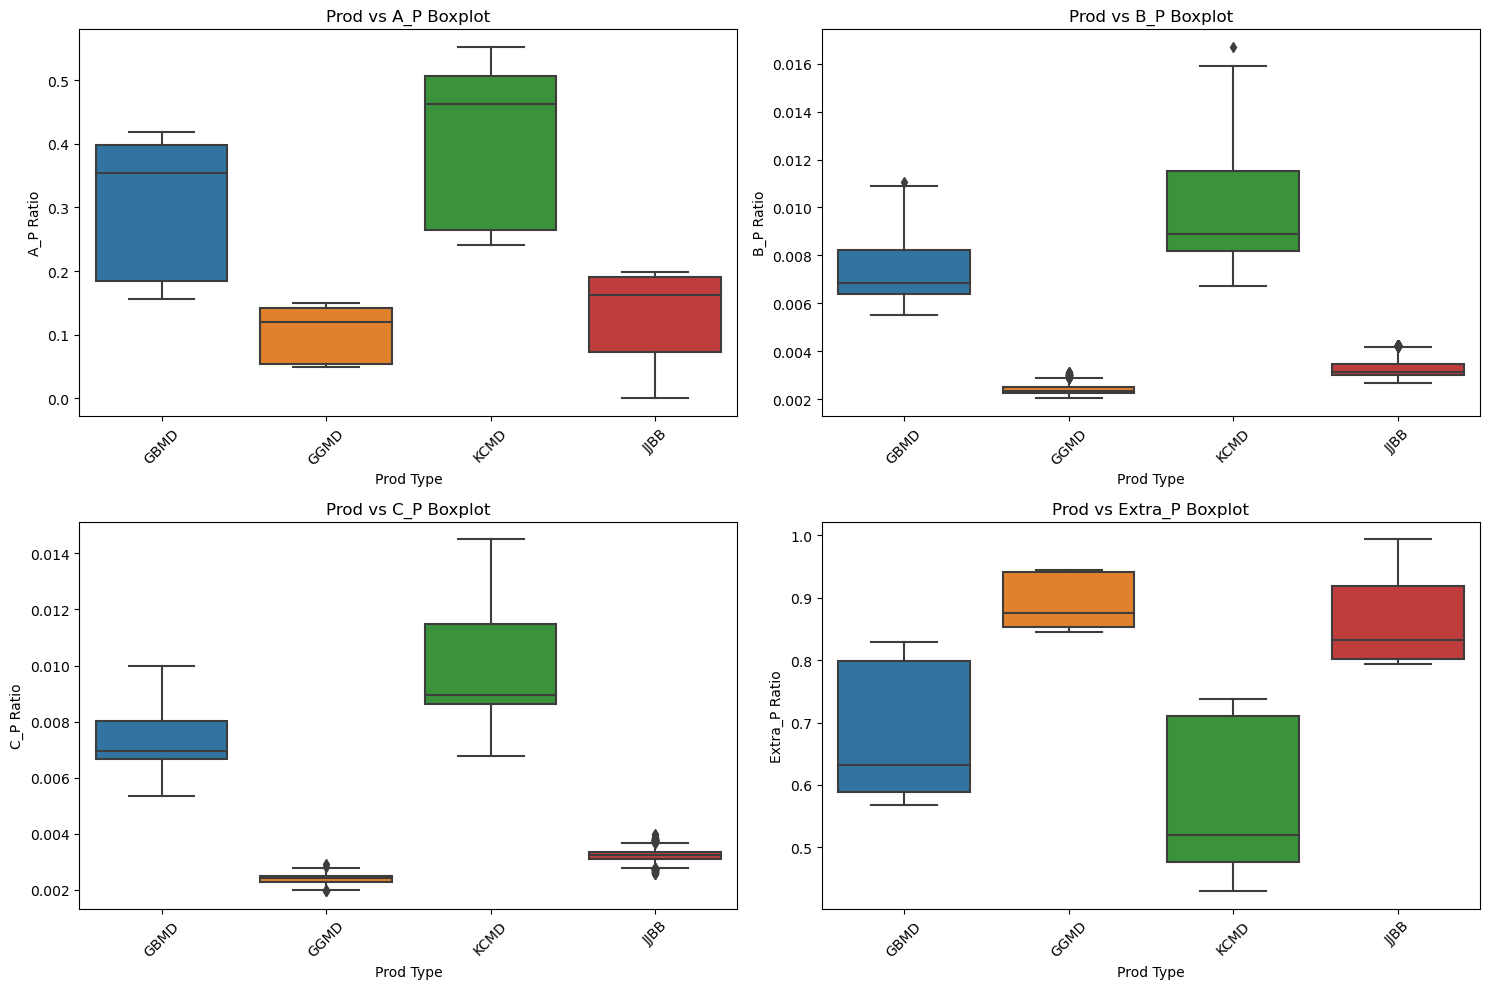

In [ ]:
plt.figure(figsize=(15, 10))

# A_P에 대한 boxplot
plt.subplot(2, 2, 1)
sns.boxplot(x='prod', y='A_P', data=df_eda)
plt.title('Prod vs A_P Boxplot')
plt.xlabel('Prod Type')
plt.ylabel('A_P Ratio')
plt.xticks(rotation=45)

# B_P에 대한 boxplot
plt.subplot(2, 2, 2)
sns.boxplot(x='prod', y='B_P', data=df_eda)
plt.title('Prod vs B_P Boxplot')
plt.xlabel('Prod Type')
plt.ylabel('B_P Ratio')
plt.xticks(rotation=45)

# C_P에 대한 boxplot
plt.subplot(2, 2, 3)
sns.boxplot(x='prod', y='C_P', data=df_eda)
plt.title('Prod vs C_P Boxplot')
plt.xlabel('Prod Type')
plt.ylabel('C_P Ratio')
plt.xticks(rotation=45)

# extra_P에 대한 boxplot
plt.subplot(2, 2, 4)
sns.boxplot(x='prod', y='extra_P', data=df_eda)
plt.title('Prod vs Extra_P Boxplot')
plt.xlabel('Prod Type')
plt.ylabel('Extra_P Ratio')
plt.xticks(rotation=45)

# 전체 그래프 보여주기
plt.tight_layout()
plt.show()


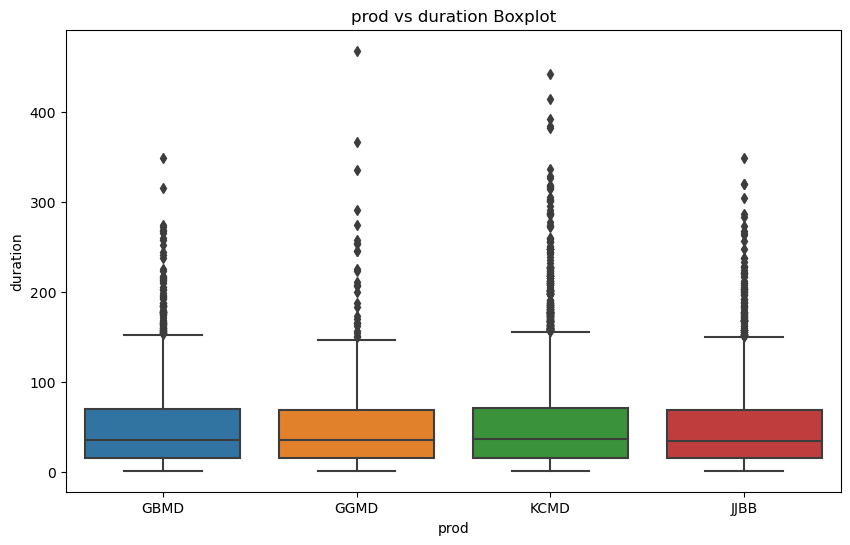

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='prod', y='duration', data=df_eda)
plt.title('prod vs duration Boxplot')
plt.show()

/home/ryoonki/anaconda3/envs/ryoonki/lib/python3.8/site-packages/seaborn/utils.py:80: UserWarning: Glyph 49328 (\N{HANGUL SYLLABLE SAN}) missing from current font.
  fig.canvas.draw()
/home/ryoonki/anaconda3/envs/ryoonki/lib/python3.8/site-packages/seaborn/utils.py:80: UserWarning: Glyph 52380 (\N{HANGUL SYLLABLE CEON}) missing from current font.
  fig.canvas.draw()
/home/ryoonki/anaconda3/envs/ryoonki/lib/python3.8/site-packages/seaborn/utils.py:80: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from current font.
  fig.canvas.draw()
/home/ryoonki/anaconda3/envs/ryoonki/lib/python3.8/site-packages/seaborn/utils.py:80: UserWarning: Glyph 49457 (\N{HANGUL SYLLABLE SEONG}) missing from current font.
  fig.canvas.draw()
/home/ryoonki/anaconda3/envs/ryoonki/lib/python3.8/site-packages/seaborn/utils.py:80: UserWarning: Glyph 50724 (\N{HANGUL SYLLABLE O}) missing from current font.
  fig.canvas.draw()
/home/ryoonki/anaconda3/envs/ryoonki/lib/python3.8/site-packages/seaborn/utils.p

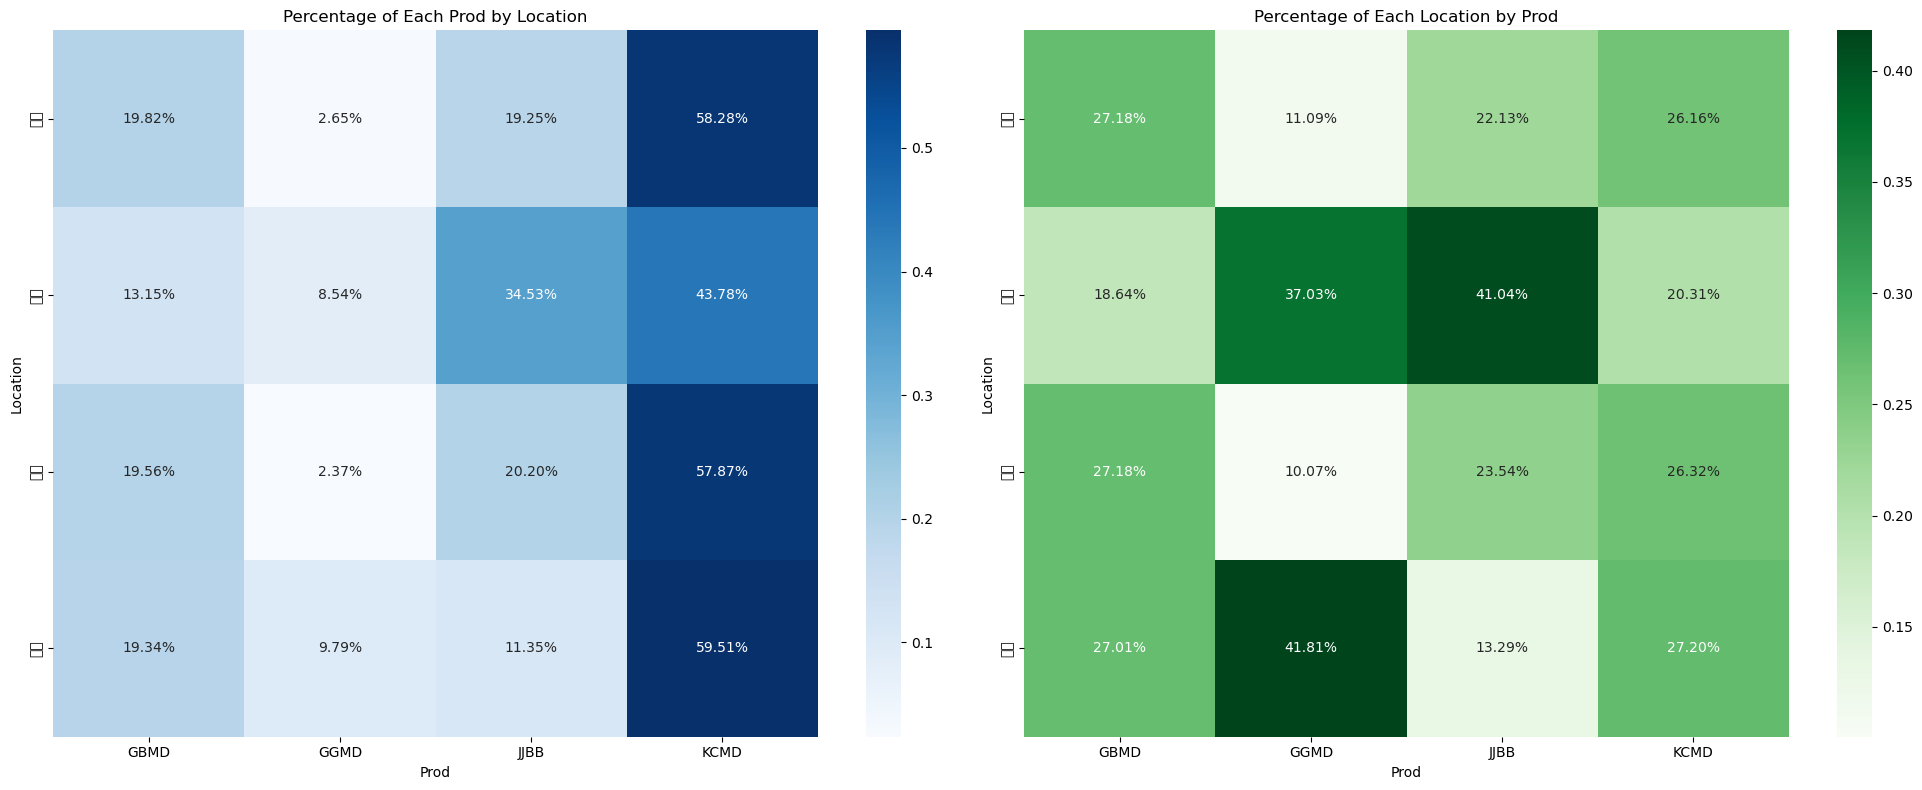

In [ ]:
#####이거 다시 한번 보기#####
prod_by_location = df_eda.groupby(['생산지', 'prod']).size().unstack(fill_value=0)

# 생산지 별로 각 제품들이 차지하는 비율
prod_by_location_percentage = prod_by_location.div(prod_by_location.sum(axis=1), axis=0)

# 각 제품 별로 생산지별 비율
location_by_prod_percentage = prod_by_location.T.div(prod_by_location.T.sum(axis=1), axis=0).T

# 시각화 준비
fig, ax = plt.subplots(1, 2, figsize=(20, 8))

# 생산지 별로 각 제품들이 차지하는 비율 시각화
sns.heatmap(prod_by_location_percentage, annot=True, fmt='.2%', cmap='Blues', ax=ax[0])
ax[0].set_title('Percentage of Each Prod by Location')
ax[0].set_xlabel('Prod')
ax[0].set_ylabel('Location')

# 각 제품 별로 생산지별 비율 시각화
sns.heatmap(location_by_prod_percentage, annot=True, fmt='.2%', cmap='Greens', ax=ax[1])
ax[1].set_title('Percentage of Each Location by Prod')
ax[1].set_xlabel('Prod')
ax[1].set_ylabel('Location')

plt.tight_layout()
plt.show()

/home/ryoonki/anaconda3/envs/ryoonki/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 54032 (\N{HANGUL SYLLABLE PAN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/ryoonki/anaconda3/envs/ryoonki/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 47588 (\N{HANGUL SYLLABLE MAE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/ryoonki/anaconda3/envs/ryoonki/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 48712 (\N{HANGUL SYLLABLE BIN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/ryoonki/anaconda3/envs/ryoonki/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/ryoonki/anaconda3/envs/ryoonki/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 51333 (\N{HANGUL 

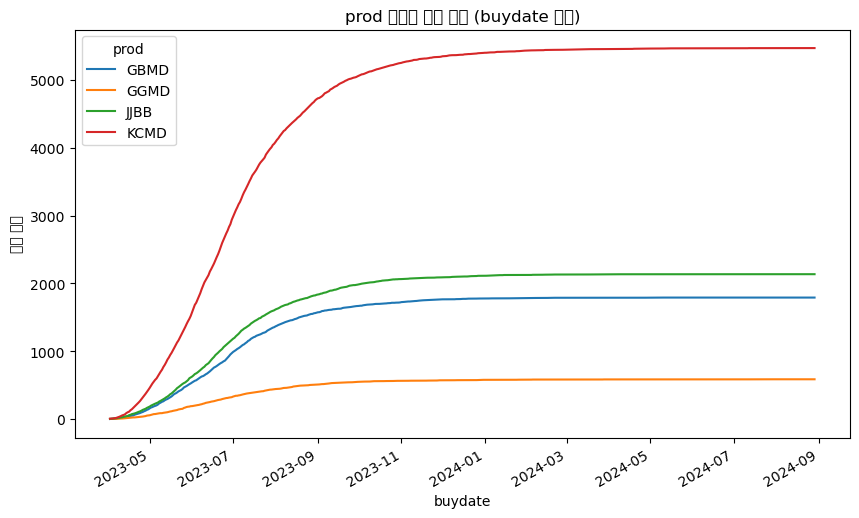

In [ ]:
df_eda['buydate'] = pd.to_datetime(df_eda['buydate'])
sales_freq = df_eda.groupby(['buydate', 'prod']).size().unstack(fill_value=0).cumsum()
sales_freq.plot(figsize=(10, 6))
plt.title('prod 종류별 판매 빈도 (buydate 기준)')
plt.ylabel('판매 빈도')
plt.show()

/home/ryoonki/anaconda3/envs/ryoonki/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 54032 (\N{HANGUL SYLLABLE PAN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/ryoonki/anaconda3/envs/ryoonki/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 47588 (\N{HANGUL SYLLABLE MAE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/ryoonki/anaconda3/envs/ryoonki/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 44060 (\N{HANGUL SYLLABLE GAE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/ryoonki/anaconda3/envs/ryoonki/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/ryoonki/anaconda3/envs/ryoonki/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 48324 (\N{HANGUL 

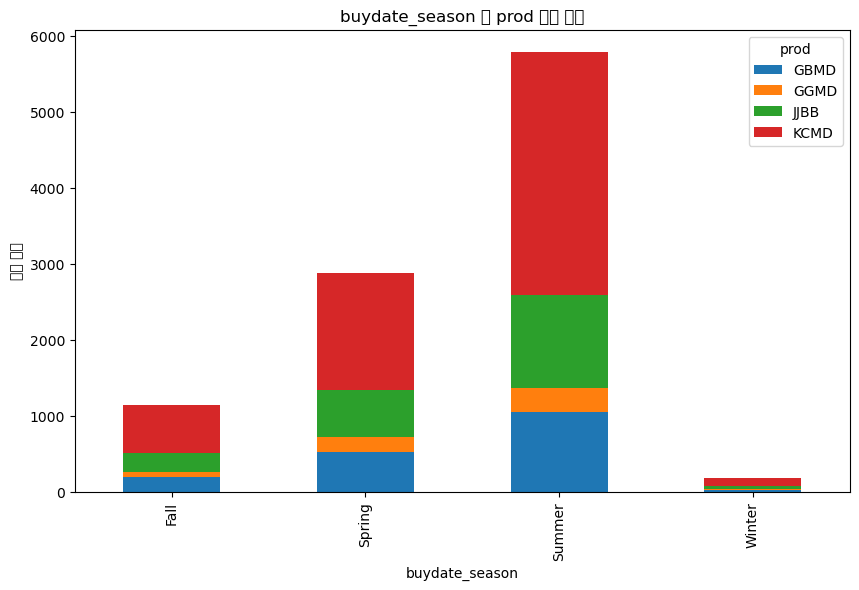

In [ ]:
# 8. 특정 buydate_season에 더 잘 팔리는 prod
seasonal_sales = df_eda.groupby(['buydate_season', 'prod']).size().unstack(fill_value=0)


# 특정 buydate_season에 더 잘 팔리는 prod (buydate_season 별 prod 개수)
seasonal_sales.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('buydate_season 별 prod 판매 개수')
plt.ylabel('판매 개수')
plt.show()


# EDA : insp

In [ ]:
df_eda['insp'].value_counts()

insp
L    3021
C    2491
K    2440
Y    1538
P     499
Name: count, dtype: int64

In [ ]:
insp_by_month = df_eda.groupby(['date_month', 'insp']).size().unstack(fill_value = 0)
insp_by_month

insp          C    K     L    P    Y
date_month                          
4           830  783  1041  162  511
5           828  843   961  166  448
6           833  814  1019  171  579

In [ ]:
insp_by_location = df_eda.groupby(['생산지', 'insp']).size().unstack(fill_value=0)
insp_by_location

insp    C    K    L    P    Y
생산지                          
산천    607  606  749  121  374
수성    626  620  777  121  396
오포    610  603  744  128  405
창하    648  611  751  129  363

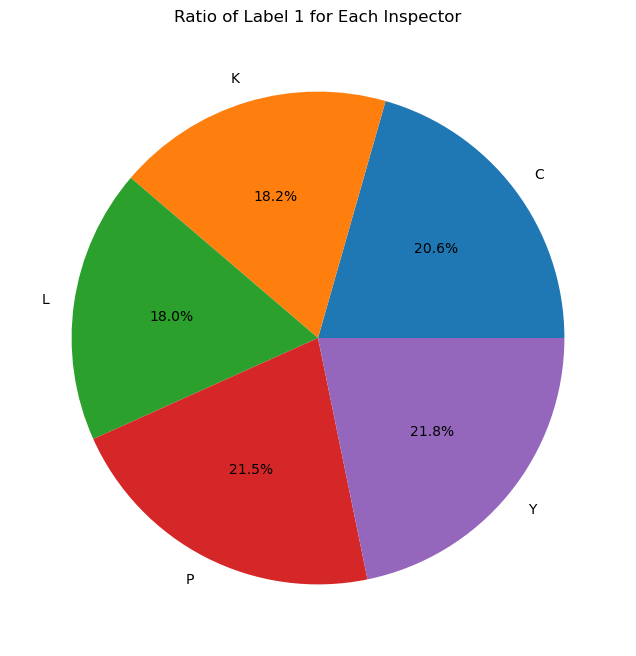

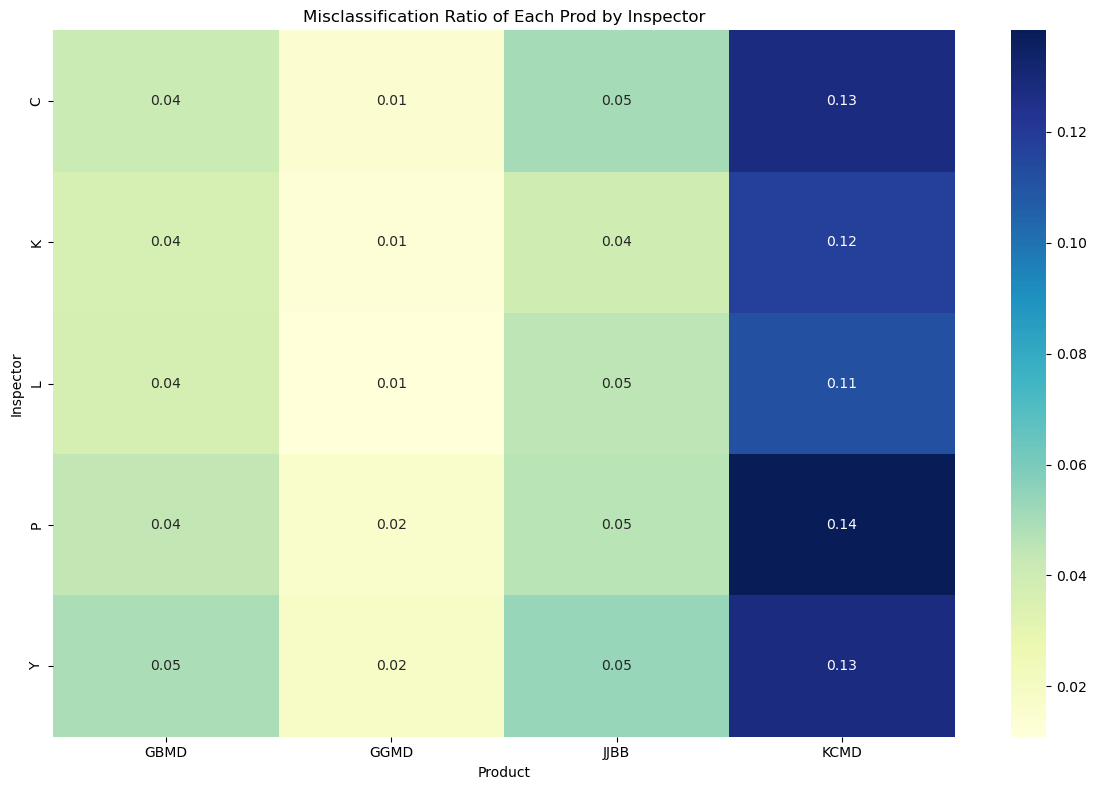

In [ ]:
# 3. 각 insp 마다, 자신이 맡은 제품의 전체 개수 중에서 label이 1인 비율
insp_label1_ratio = df_eda[df_eda['label'] == 1].groupby('insp').size() / df_eda.groupby('insp').size()

# 4. 각 insp 한명에 대해 각각의 prod에 대해서 분류를 잘못한 비율(전체 중에서 label이 1)
insp_prod_misclass = df_eda[df_eda['label'] == 1].groupby(['insp', 'prod']).size() / df_eda.groupby('insp').size()
insp_prod_misclass = insp_prod_misclass.unstack(fill_value=0)

# 3번 항목의 pie chart 그리기
plt.figure(figsize=(8, 8))
insp_label1_ratio.plot(kind='pie', autopct='%1.1f%%')
plt.title('Ratio of Label 1 for Each Inspector')
plt.ylabel('')  # y-label은 불필요하므로 제거

# 4번 항목의 시각화 그리기
plt.figure(figsize=(12, 8))
sns.heatmap(insp_prod_misclass, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title('Misclassification Ratio of Each Prod by Inspector')
plt.xlabel('Product')
plt.ylabel('Inspector')

plt.tight_layout()
plt.show()


# EDA : date_half_month

In [ ]:
# 각 달을 반으로 나누어 'date_half_month' 컬럼 생성
df_eda['date_half_month'] = df_eda['date'].dt.month.astype(str) + '_' + \
                            df_eda['date'].dt.day.apply(lambda x: '1' if x <= 15 else '2')

# 결과 확인
print(df_eda[['date', 'date_half_month']].head())


        date date_half_month
0 2023-06-18             6_2
1 2023-05-18             5_2
2 2023-05-05             5_1
3 2023-05-05             5_1
4 2023-04-09             4_1


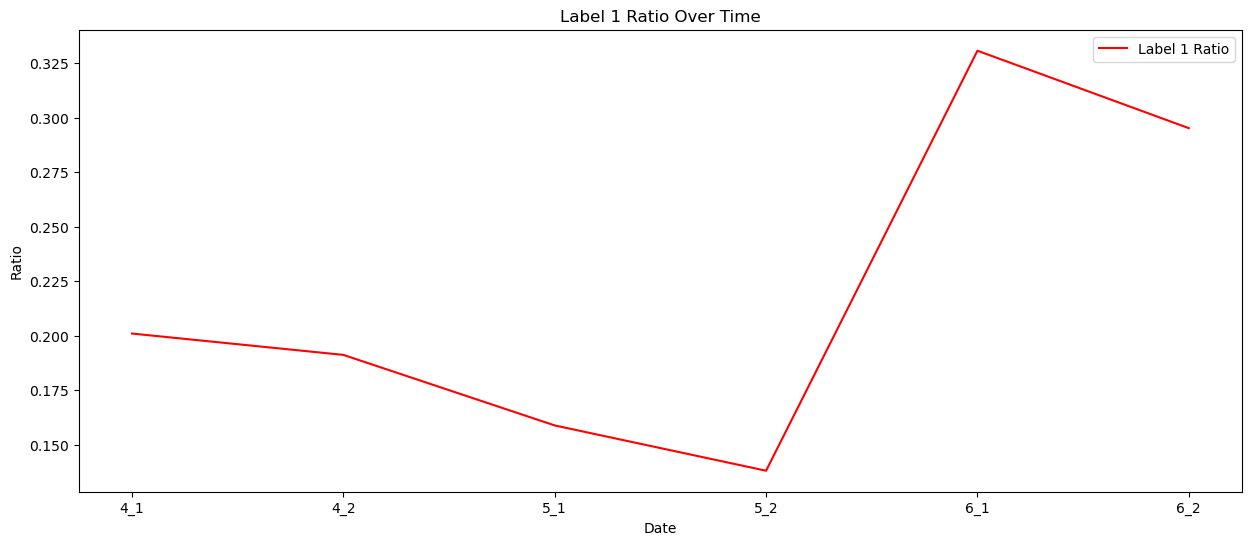

In [ ]:
label_counts = df_eda.groupby('date_half_month')['label'].value_counts().unstack(fill_value=0)
label_ratio = label_counts[1] / label_counts.sum(axis=1)

# 시각화 설정
plt.figure(figsize=(15, 6))
plt.plot(label_counts.index, label_ratio, color='red', label='Label 1 Ratio')
plt.xlabel('Date')
plt.ylabel('Ratio')
plt.title('Label 1 Ratio Over Time')
plt.legend(loc='upper right')
plt.show()


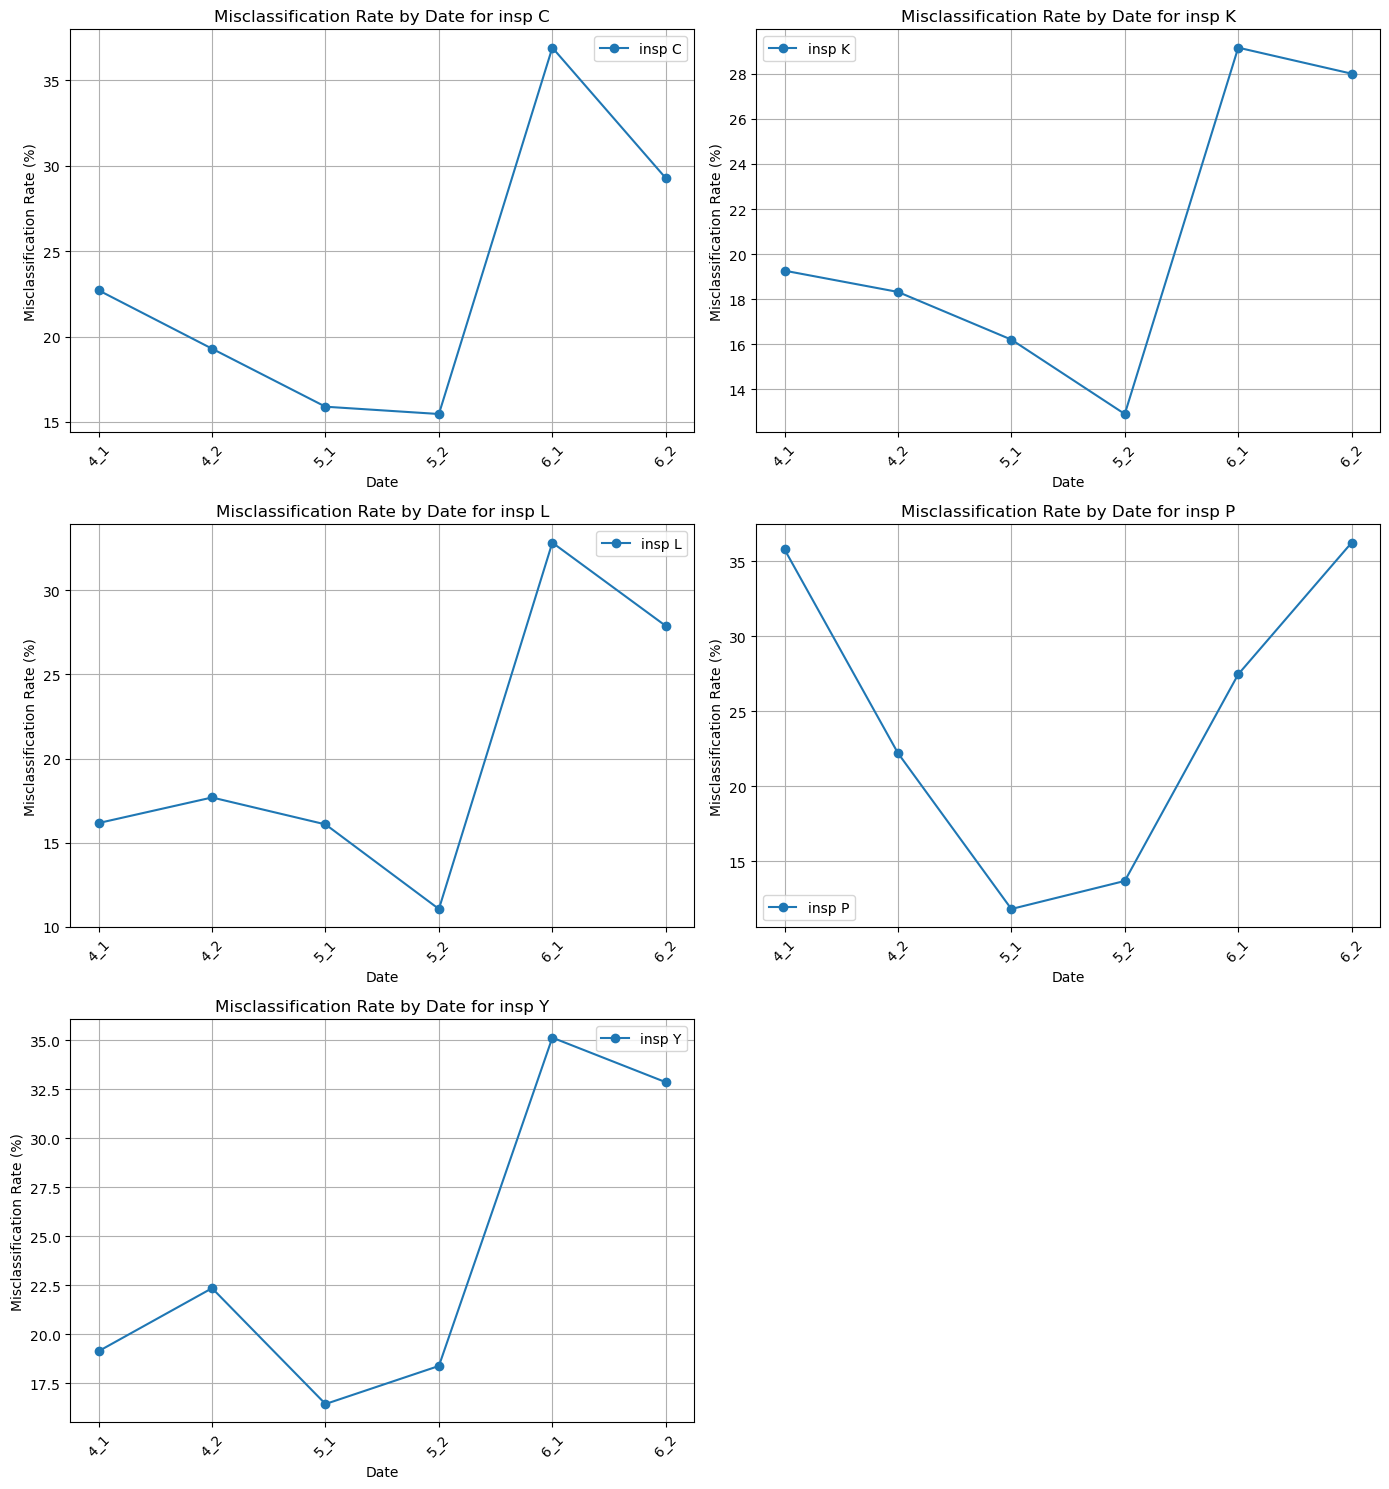

In [ ]:
# insp 한명한명에 대해, 날짜별 오분류율 lineplot
# 'insp'와 'date'를 기준으로 그룹화하여 label이 1인 비율(오분류율) 계산
misclass_rates = df_eda.groupby(['insp', 'date_half_month'])['label'].mean().reset_index()

# 오분류율을 percentage로 변환
misclass_rates['misclassification_rate'] = misclass_rates['label'] * 100

# Pivot table 생성하여 각 insp에 대해 날짜별로 오분류율을 시각화하기 쉽게 만듬
misclass_pivot = misclass_rates.pivot(index='date_half_month', columns='insp', values='misclassification_rate')

# 각 'insp'에 대해 subplot 생성
num_insp = misclass_pivot.columns.size
num_rows = num_insp // 2 + num_insp % 2  # 두 개의 컬럼이 있는 subplot 줄 수 계산

plt.figure(figsize=(14, num_rows * 5))

for idx, insp in enumerate(misclass_pivot.columns, start=1):
    plt.subplot(num_rows, 2, idx)
    plt.plot(misclass_pivot.index, misclass_pivot[insp], marker='o', label=f'insp {insp}')
    plt.title(f'Misclassification Rate by Date for insp {insp}')
    plt.xlabel('Date')
    plt.ylabel('Misclassification Rate (%)')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()


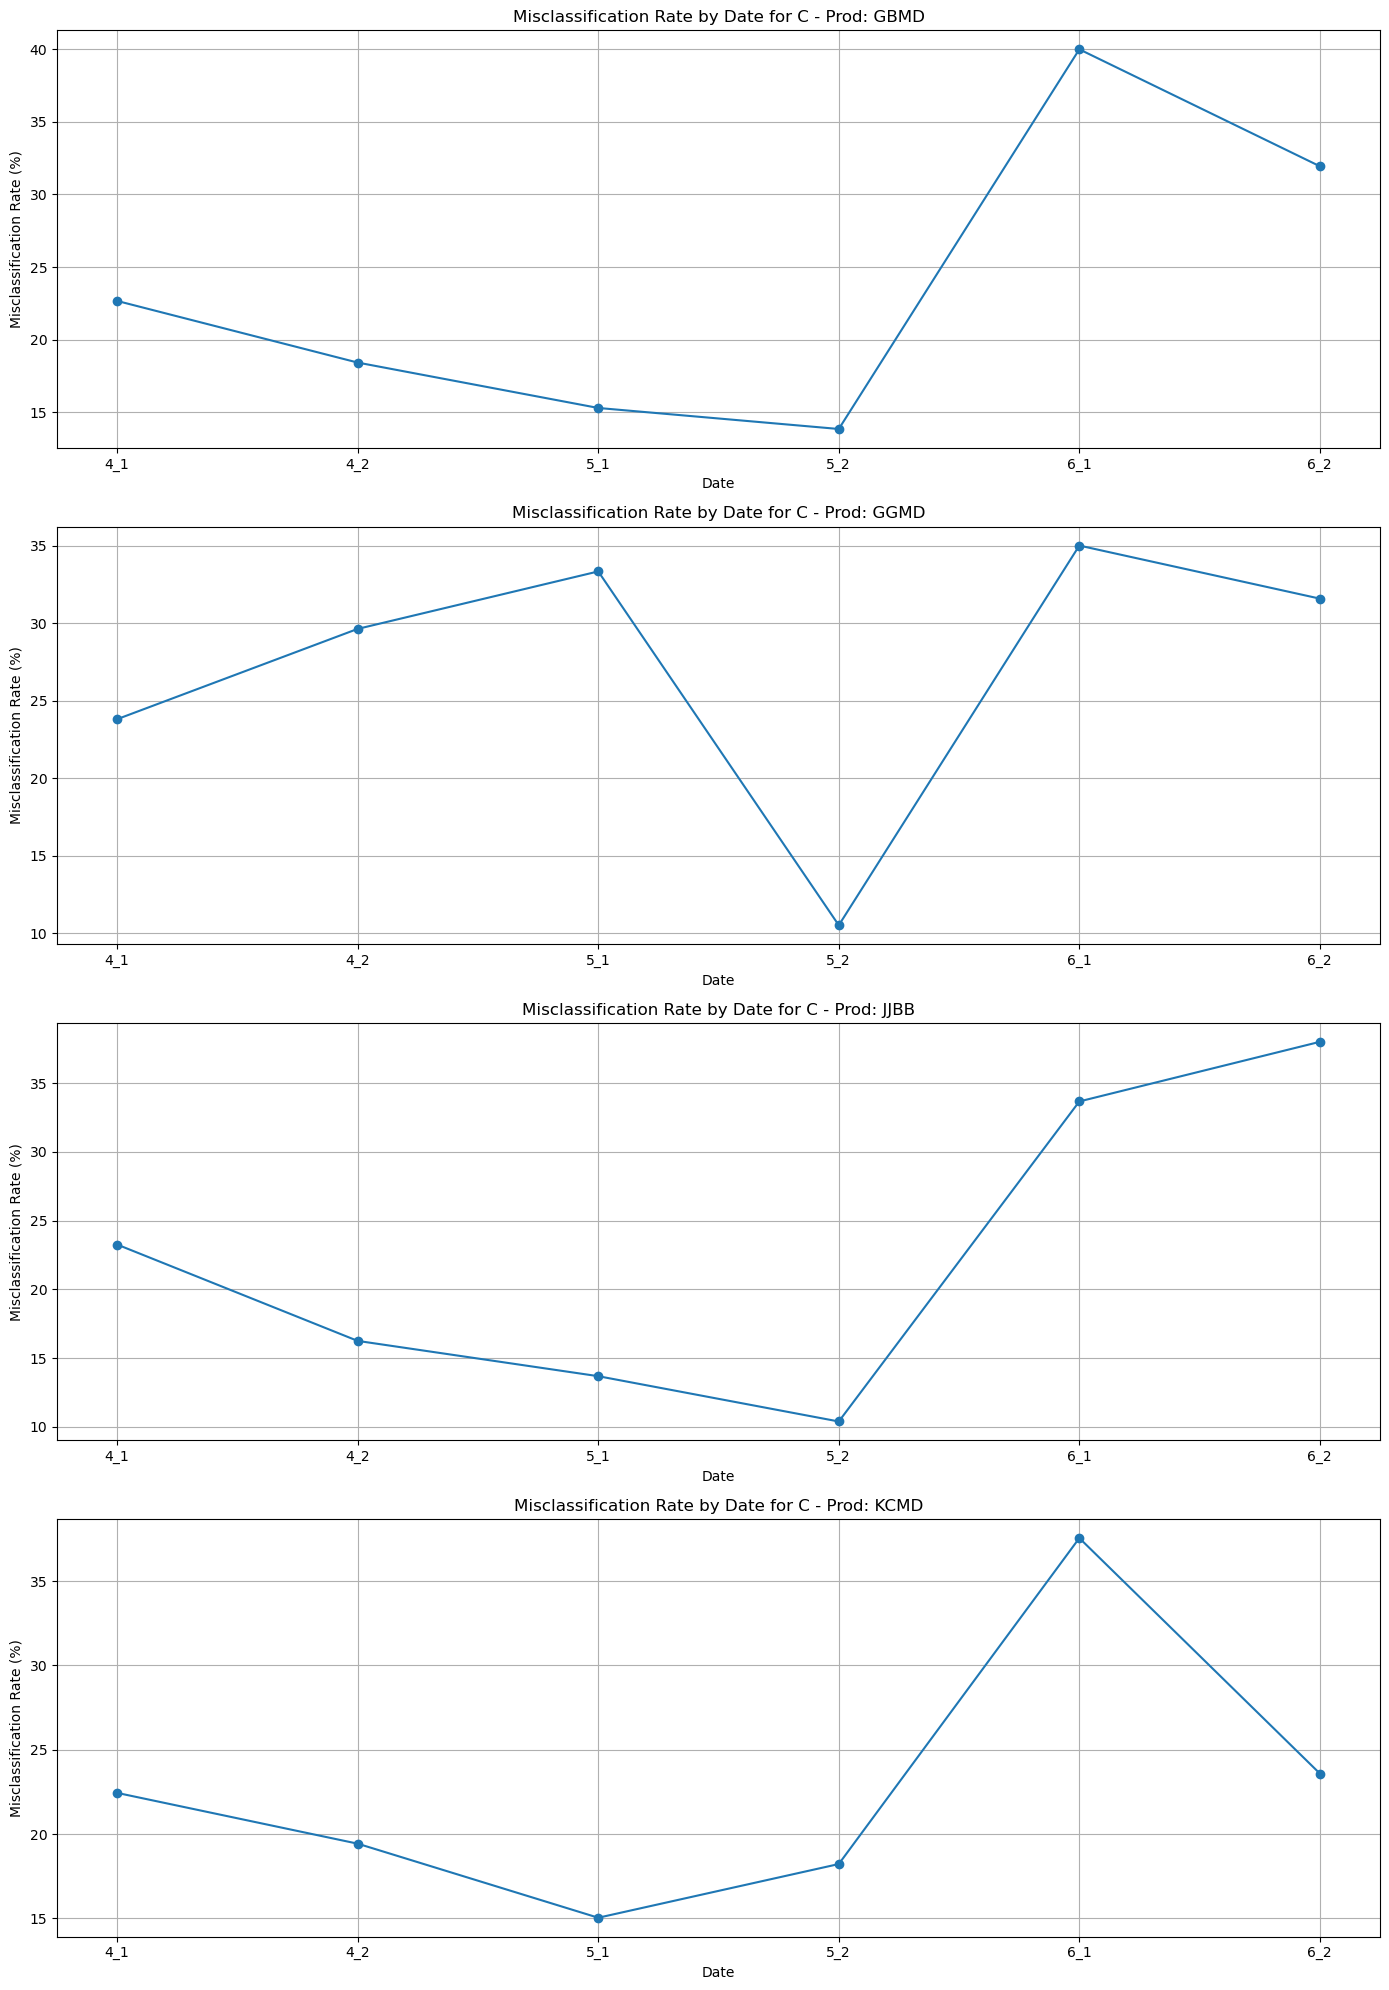

In [ ]:
# 'insp', 'date', 'prod'를 기준으로 그룹화하여 label이 1인 비율(오분류율) 계산
misclass_rates_prod = df_eda.groupby(['insp', 'date_half_month', 'prod'])['label'].mean().reset_index()

# 오분류율을 percentage로 변환
misclass_rates_prod['misclassification_rate'] = misclass_rates_prod['label'] * 100

# 'insp' 중 한 명을 선택 (예: 첫 번째 'insp')
selected_insp = misclass_rates_prod['insp'].unique()[0]

# 선택된 'insp'에 대한 데이터 필터링
selected_insp_data = misclass_rates_prod[misclass_rates_prod['insp'] == selected_insp]

# 각 'prod'에 대해 subplot 생성
num_prod = len(selected_insp_data['prod'].unique())
plt.figure(figsize=(14, num_prod * 5))

for idx, prod in enumerate(selected_insp_data['prod'].unique()):
    ax = plt.subplot(num_prod, 1, idx+1)
    # 'prod' 기준으로 데이터 필터링
    prod_data = selected_insp_data[selected_insp_data['prod'] == prod]

    # Pivot table 생성하여 날짜별로 오분류율을 시각화하기 쉽게 만듬
    prod_pivot = prod_data.pivot(index='date_half_month', columns='prod', values='misclassification_rate')

    # 그래프 그리기
    prod_pivot.plot(ax=ax, kind='line', marker='o')
    ax.set_title(f'Misclassification Rate by Date for {selected_insp} - Prod: {prod}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Misclassification Rate (%)')
    ax.legend().set_visible(False)
    ax.grid(True)

plt.tight_layout()
plt.show()


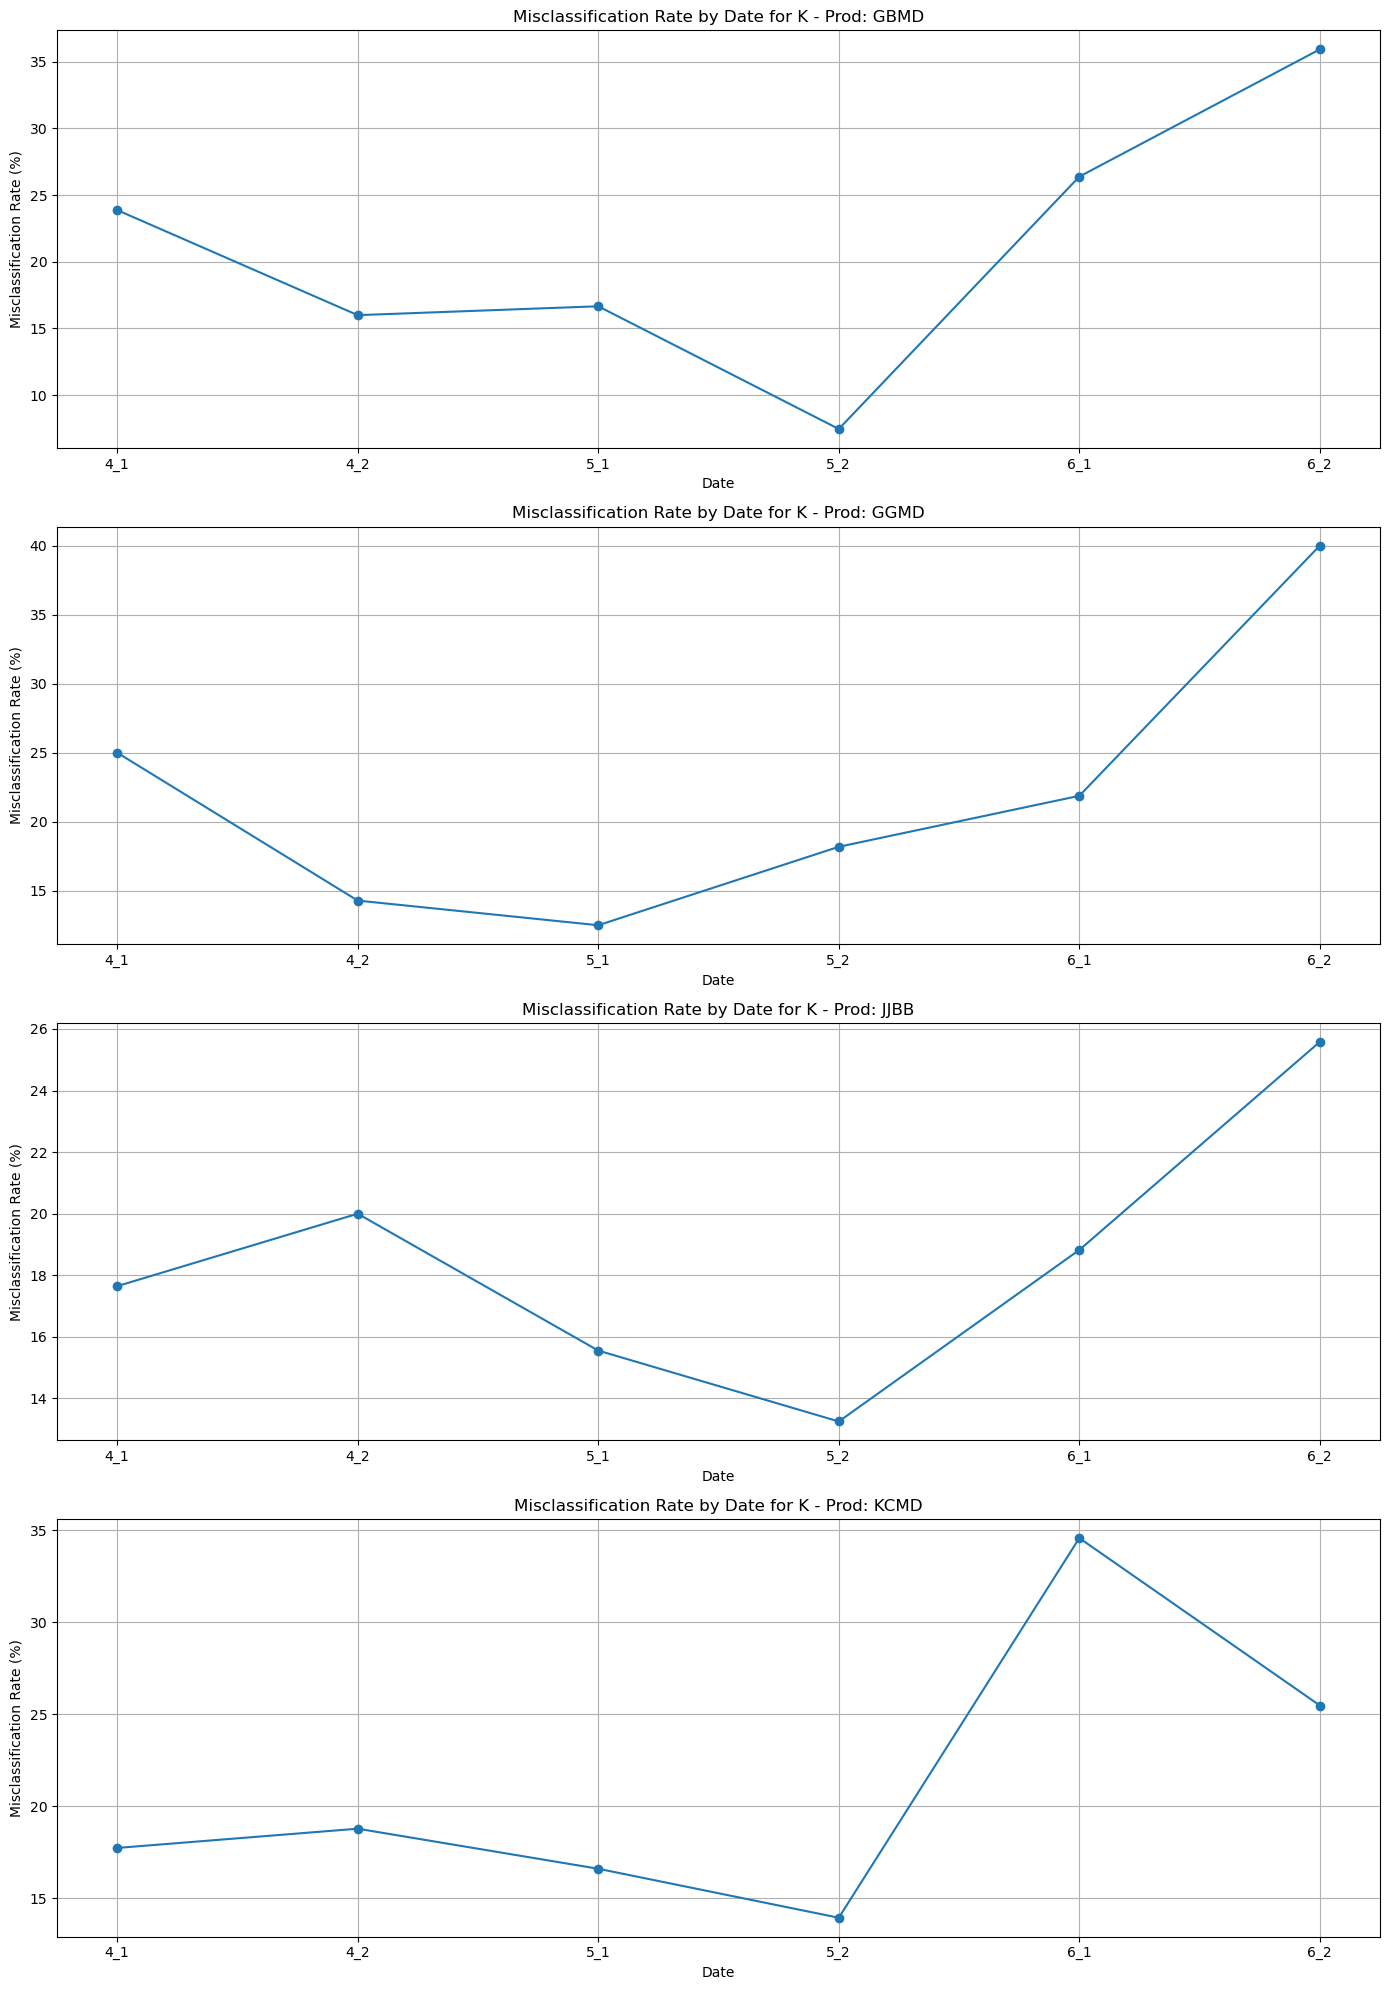

In [ ]:
# 'insp', 'date', 'prod'를 기준으로 그룹화하여 label이 1인 비율(오분류율) 계산
misclass_rates_prod = df_eda.groupby(['insp', 'date_half_month', 'prod'])['label'].mean().reset_index()

# 오분류율을 percentage로 변환
misclass_rates_prod['misclassification_rate'] = misclass_rates_prod['label'] * 100

# 'insp' 중 한 명을 선택 (예: 첫 번째 'insp')
selected_insp = misclass_rates_prod['insp'].unique()[1]

# 선택된 'insp'에 대한 데이터 필터링
selected_insp_data = misclass_rates_prod[misclass_rates_prod['insp'] == selected_insp]

# 각 'prod'에 대해 subplot 생성
num_prod = len(selected_insp_data['prod'].unique())
plt.figure(figsize=(14, num_prod * 5))

for idx, prod in enumerate(selected_insp_data['prod'].unique()):
    ax = plt.subplot(num_prod, 1, idx+1)
    # 'prod' 기준으로 데이터 필터링
    prod_data = selected_insp_data[selected_insp_data['prod'] == prod]

    # Pivot table 생성하여 날짜별로 오분류율을 시각화하기 쉽게 만듬
    prod_pivot = prod_data.pivot(index='date_half_month', columns='prod', values='misclassification_rate')

    # 그래프 그리기
    prod_pivot.plot(ax=ax, kind='line', marker='o')
    ax.set_title(f'Misclassification Rate by Date for {selected_insp} - Prod: {prod}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Misclassification Rate (%)')
    ax.legend().set_visible(False)
    ax.grid(True)

plt.tight_layout()
plt.show()


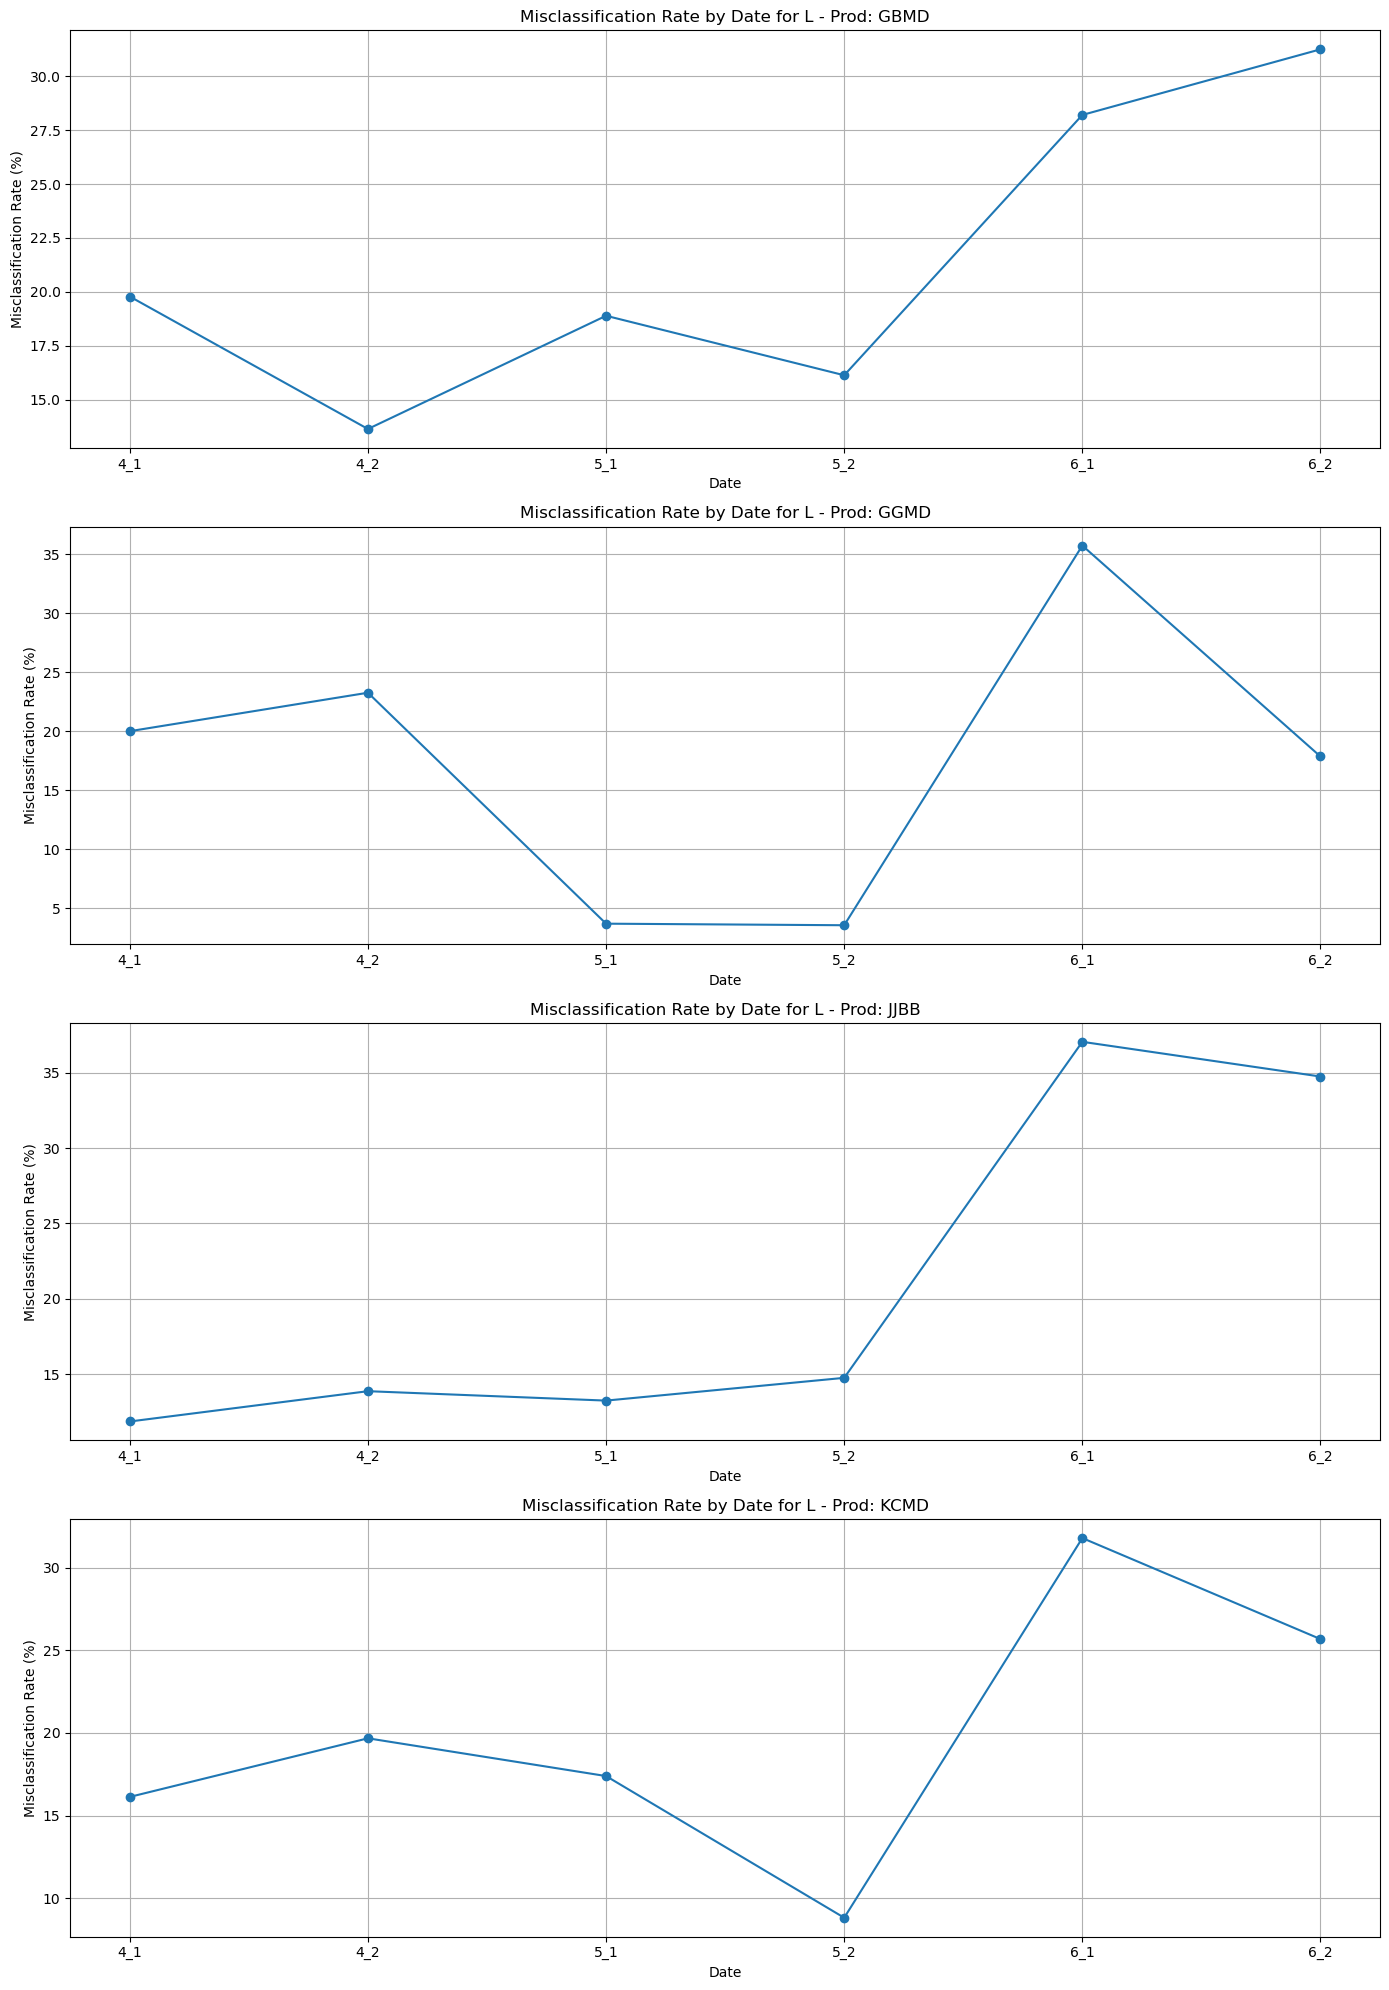

In [ ]:
# 'insp', 'date', 'prod'를 기준으로 그룹화하여 label이 1인 비율(오분류율) 계산
misclass_rates_prod = df_eda.groupby(['insp', 'date_half_month', 'prod'])['label'].mean().reset_index()

# 오분류율을 percentage로 변환
misclass_rates_prod['misclassification_rate'] = misclass_rates_prod['label'] * 100

# 'insp' 중 한 명을 선택 (예: 첫 번째 'insp')
selected_insp = misclass_rates_prod['insp'].unique()[2]

# 선택된 'insp'에 대한 데이터 필터링
selected_insp_data = misclass_rates_prod[misclass_rates_prod['insp'] == selected_insp]

# 각 'prod'에 대해 subplot 생성
num_prod = len(selected_insp_data['prod'].unique())
plt.figure(figsize=(14, num_prod * 5))

for idx, prod in enumerate(selected_insp_data['prod'].unique()):
    ax = plt.subplot(num_prod, 1, idx+1)
    # 'prod' 기준으로 데이터 필터링
    prod_data = selected_insp_data[selected_insp_data['prod'] == prod]

    # Pivot table 생성하여 날짜별로 오분류율을 시각화하기 쉽게 만듬
    prod_pivot = prod_data.pivot(index='date_half_month', columns='prod', values='misclassification_rate')

    # 그래프 그리기
    prod_pivot.plot(ax=ax, kind='line', marker='o')
    ax.set_title(f'Misclassification Rate by Date for {selected_insp} - Prod: {prod}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Misclassification Rate (%)')
    ax.legend().set_visible(False)
    ax.grid(True)

plt.tight_layout()
plt.show()


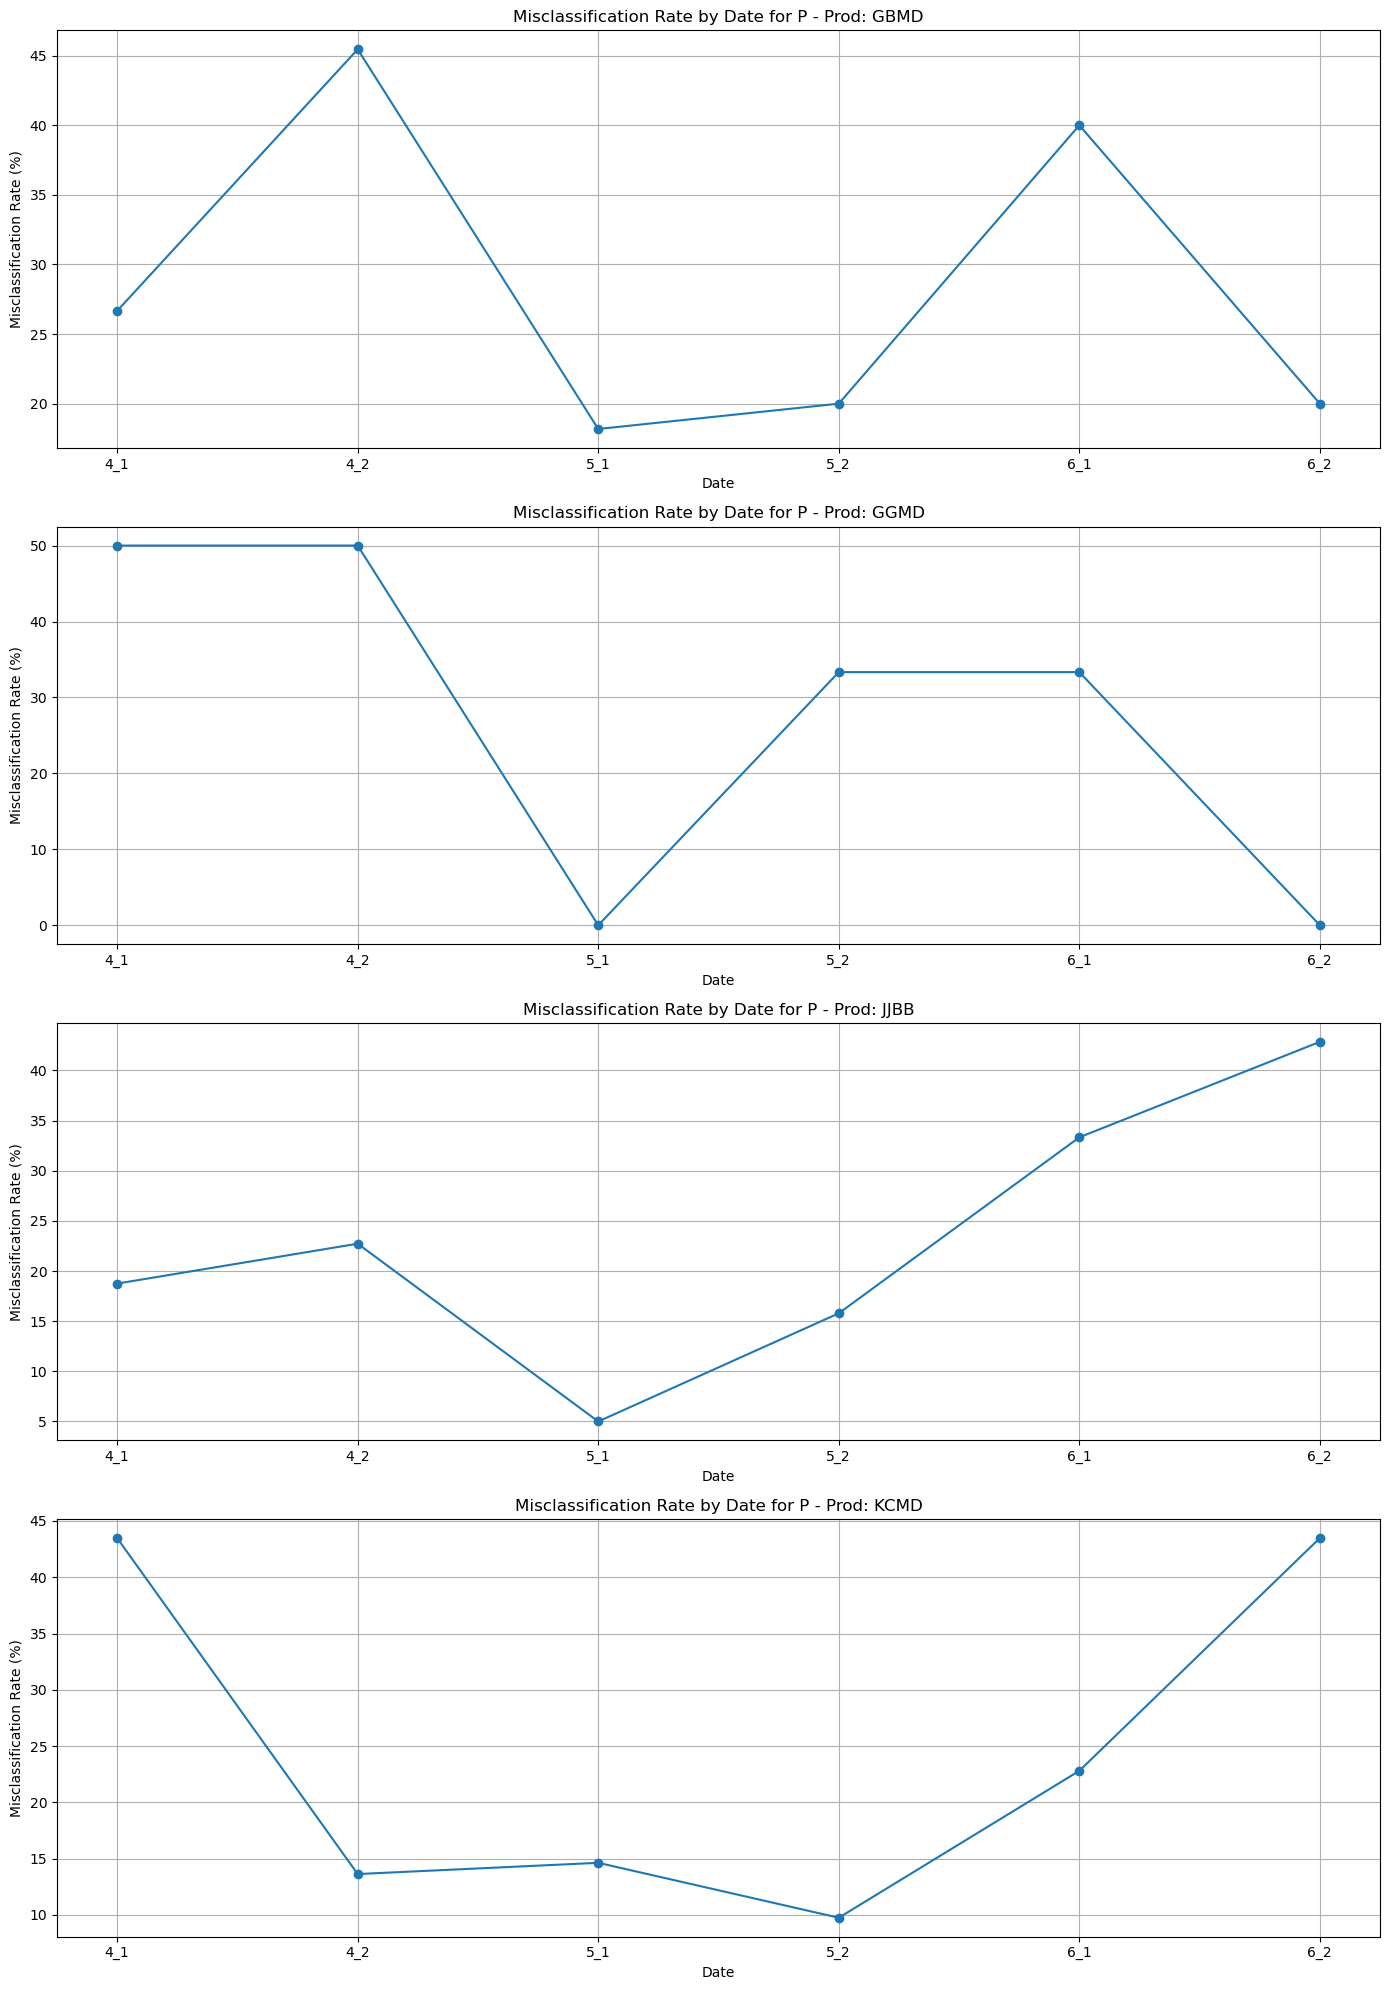

In [ ]:
# 'insp', 'date', 'prod'를 기준으로 그룹화하여 label이 1인 비율(오분류율) 계산
misclass_rates_prod = df_eda.groupby(['insp', 'date_half_month', 'prod'])['label'].mean().reset_index()

# 오분류율을 percentage로 변환
misclass_rates_prod['misclassification_rate'] = misclass_rates_prod['label'] * 100

# 'insp' 중 한 명을 선택 (예: 첫 번째 'insp')
selected_insp = misclass_rates_prod['insp'].unique()[3]

# 선택된 'insp'에 대한 데이터 필터링
selected_insp_data = misclass_rates_prod[misclass_rates_prod['insp'] == selected_insp]

# 각 'prod'에 대해 subplot 생성
num_prod = len(selected_insp_data['prod'].unique())
plt.figure(figsize=(14, num_prod * 5))

for idx, prod in enumerate(selected_insp_data['prod'].unique()):
    ax = plt.subplot(num_prod, 1, idx+1)
    # 'prod' 기준으로 데이터 필터링
    prod_data = selected_insp_data[selected_insp_data['prod'] == prod]

    # Pivot table 생성하여 날짜별로 오분류율을 시각화하기 쉽게 만듬
    prod_pivot = prod_data.pivot(index='date_half_month', columns='prod', values='misclassification_rate')

    # 그래프 그리기
    prod_pivot.plot(ax=ax, kind='line', marker='o')
    ax.set_title(f'Misclassification Rate by Date for {selected_insp} - Prod: {prod}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Misclassification Rate (%)')
    ax.legend().set_visible(False)
    ax.grid(True)

plt.tight_layout()
plt.show()


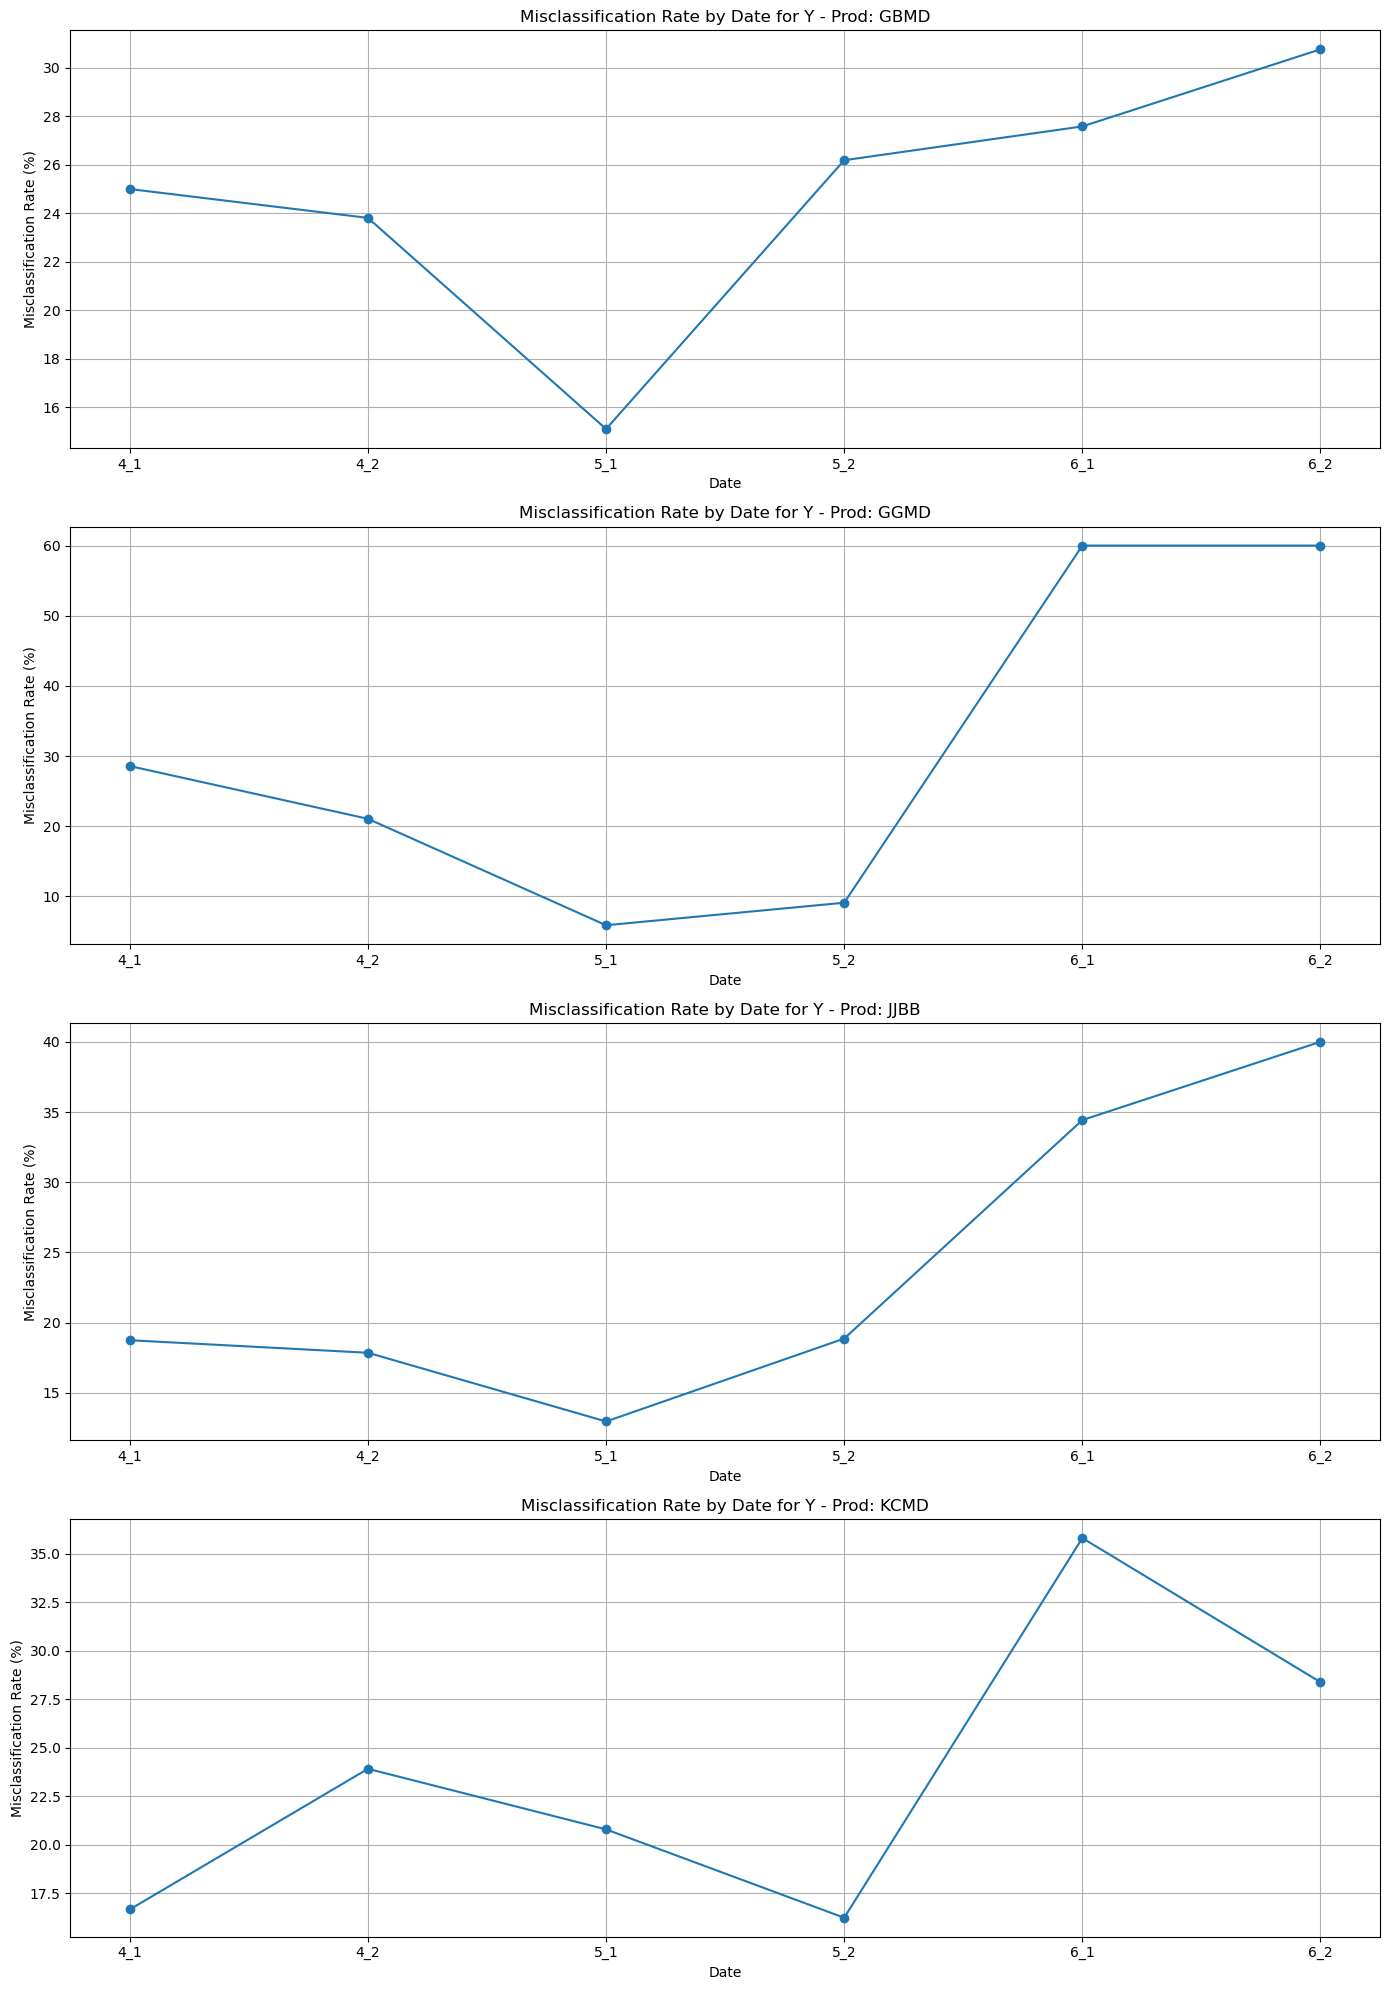

In [ ]:
# 'insp', 'date', 'prod'를 기준으로 그룹화하여 label이 1인 비율(오분류율) 계산
misclass_rates_prod = df_eda.groupby(['insp', 'date_half_month', 'prod'])['label'].mean().reset_index()

# 오분류율을 percentage로 변환
misclass_rates_prod['misclassification_rate'] = misclass_rates_prod['label'] * 100

# 'insp' 중 한 명을 선택 (예: 첫 번째 'insp')
selected_insp = misclass_rates_prod['insp'].unique()[4]

# 선택된 'insp'에 대한 데이터 필터링
selected_insp_data = misclass_rates_prod[misclass_rates_prod['insp'] == selected_insp]

# 각 'prod'에 대해 subplot 생성
num_prod = len(selected_insp_data['prod'].unique())
plt.figure(figsize=(14, num_prod * 5))

for idx, prod in enumerate(selected_insp_data['prod'].unique()):
    ax = plt.subplot(num_prod, 1, idx+1)
    # 'prod' 기준으로 데이터 필터링
    prod_data = selected_insp_data[selected_insp_data['prod'] == prod]

    # Pivot table 생성하여 날짜별로 오분류율을 시각화하기 쉽게 만듬
    prod_pivot = prod_data.pivot(index='date_half_month', columns='prod', values='misclassification_rate')

    # 그래프 그리기
    prod_pivot.plot(ax=ax, kind='line', marker='o')
    ax.set_title(f'Misclassification Rate by Date for {selected_insp} - Prod: {prod}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Misclassification Rate (%)')
    ax.legend().set_visible(False)
    ax.grid(True)

plt.tight_layout()
plt.show()


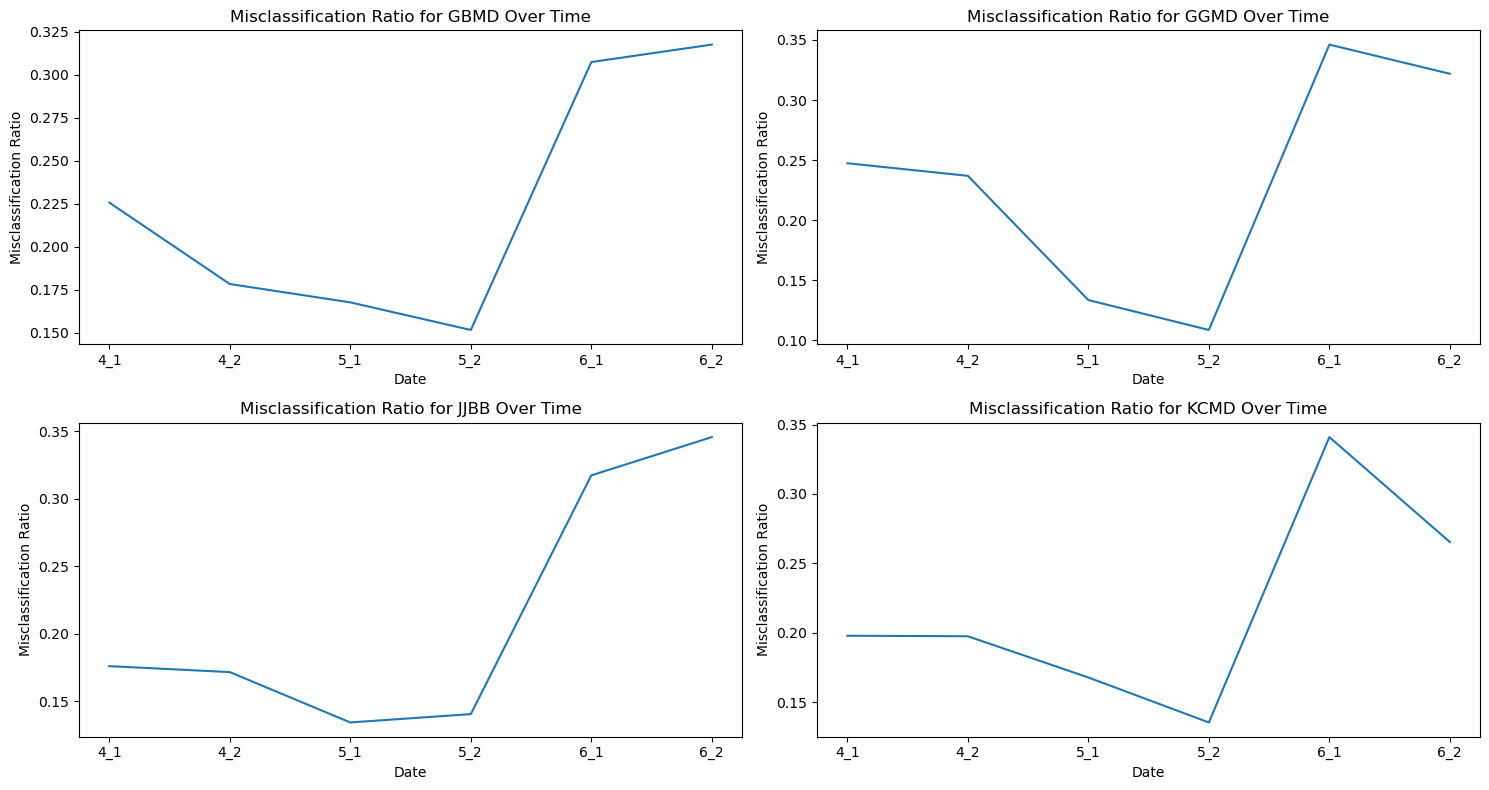

In [ ]:
prod_label_ratio = df_eda.groupby(['date_half_month', 'prod'])['label'].mean().unstack(fill_value=0)

# prod의 개수에 따라 subplot 생성
n_prods = len(prod_label_ratio.columns)
n_rows = int(np.ceil(n_prods / 2))
fig, axes = plt.subplots(n_rows, 2, figsize=(15, n_rows * 4))

# 각 prod별로 그래프 그리기
for i, prod in enumerate(prod_label_ratio.columns):
    ax = axes[i // 2, i % 2]
    sns.lineplot(x=prod_label_ratio.index, y=prod_label_ratio[prod], ax=ax)
    ax.set_title(f'Misclassification Ratio for {prod} Over Time')
    ax.set_ylabel('Misclassification Ratio')
    ax.set_xlabel('Date')

# 빈 subplot 제거
if n_prods % 2 != 0:
    fig.delaxes(axes[-1, -1])

plt.tight_layout()
plt.show()


# EDA : date

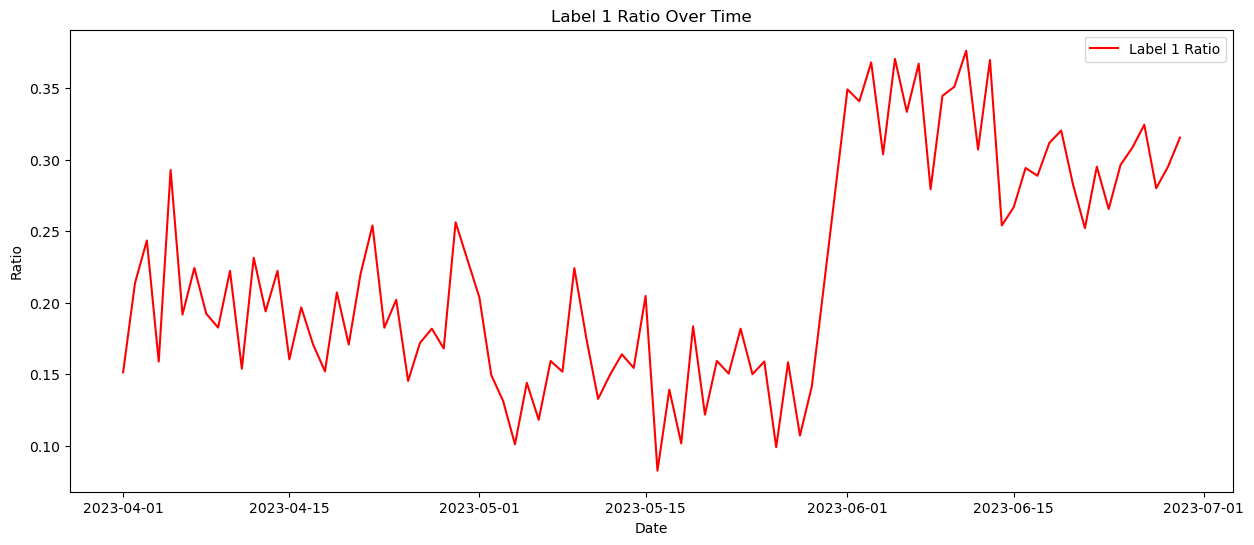

In [ ]:
label_counts = df_eda.groupby('date')['label'].value_counts().unstack(fill_value=0)
label_ratio = label_counts[1] / label_counts.sum(axis=1)

# 시각화 설정
plt.figure(figsize=(15, 6))
plt.plot(label_counts.index, label_ratio, color='red', label='Label 1 Ratio')
plt.xlabel('Date')
plt.ylabel('Ratio')
plt.title('Label 1 Ratio Over Time')
plt.legend(loc='upper right')
plt.show()


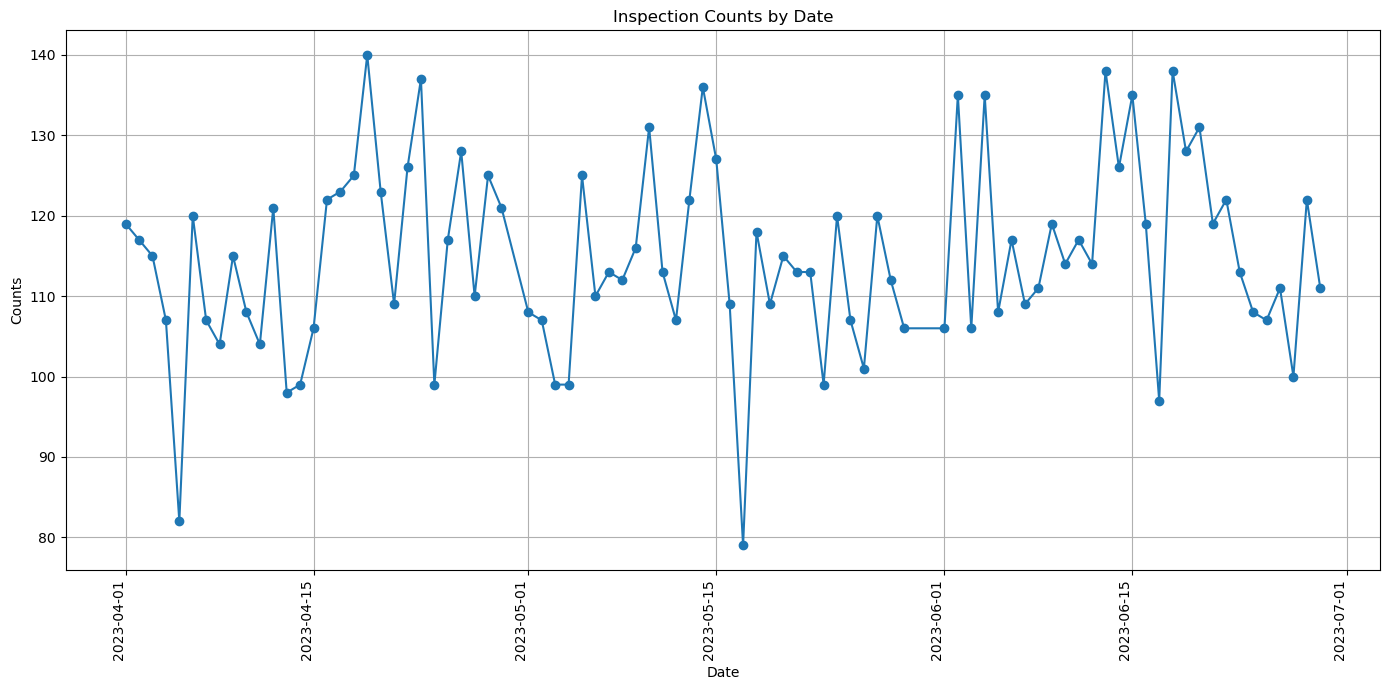

In [ ]:
inspection_counts = df_eda['date'].value_counts().sort_index()

# 날짜별 검수 개수 그래프로 그리기
plt.figure(figsize=(14, 7))
inspection_counts.plot(kind='line', marker='o')  # line plot with markers
plt.title('Inspection Counts by Date')
plt.xlabel('Date')
plt.ylabel('Counts')
plt.grid(True)  # add gridlines
plt.xticks(rotation=90)  # 날짜 레이블이 겹치지 않도록 회전
plt.tight_layout()
plt.show()


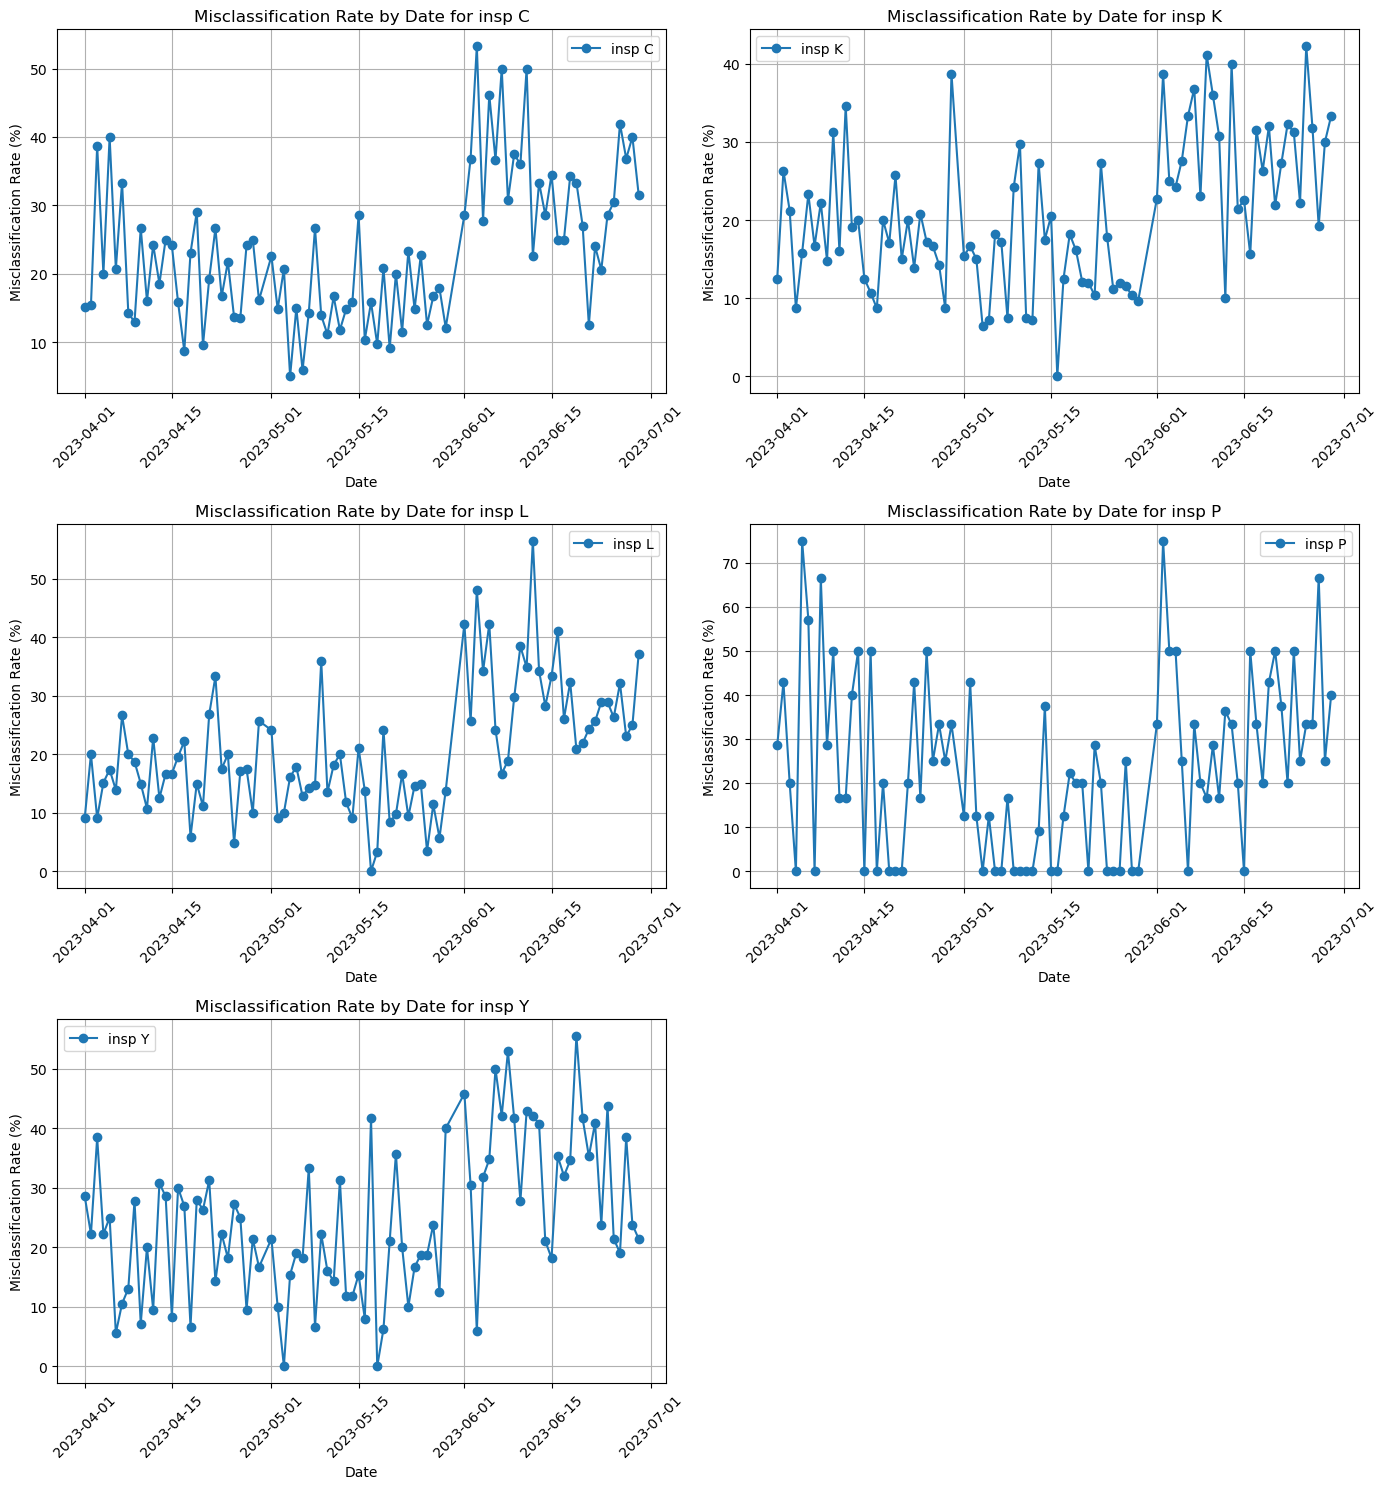

In [ ]:
# insp 한명한명에 대해, 날짜별 오분류율 lineplot
# 'insp'와 'date'를 기준으로 그룹화하여 label이 1인 비율(오분류율) 계산
misclass_rates = df_eda.groupby(['insp', 'date'])['label'].mean().reset_index()

# 오분류율을 percentage로 변환
misclass_rates['misclassification_rate'] = misclass_rates['label'] * 100

# Pivot table 생성하여 각 insp에 대해 날짜별로 오분류율을 시각화하기 쉽게 만듬
misclass_pivot = misclass_rates.pivot(index='date', columns='insp', values='misclassification_rate')

# 각 'insp'에 대해 subplot 생성
num_insp = misclass_pivot.columns.size
num_rows = num_insp // 2 + num_insp % 2  # 두 개의 컬럼이 있는 subplot 줄 수 계산

plt.figure(figsize=(14, num_rows * 5))

for idx, insp in enumerate(misclass_pivot.columns, start=1):
    plt.subplot(num_rows, 2, idx)
    plt.plot(misclass_pivot.index, misclass_pivot[insp], marker='o', label=f'insp {insp}')
    plt.title(f'Misclassification Rate by Date for insp {insp}')
    plt.xlabel('Date')
    plt.ylabel('Misclassification Rate (%)')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()


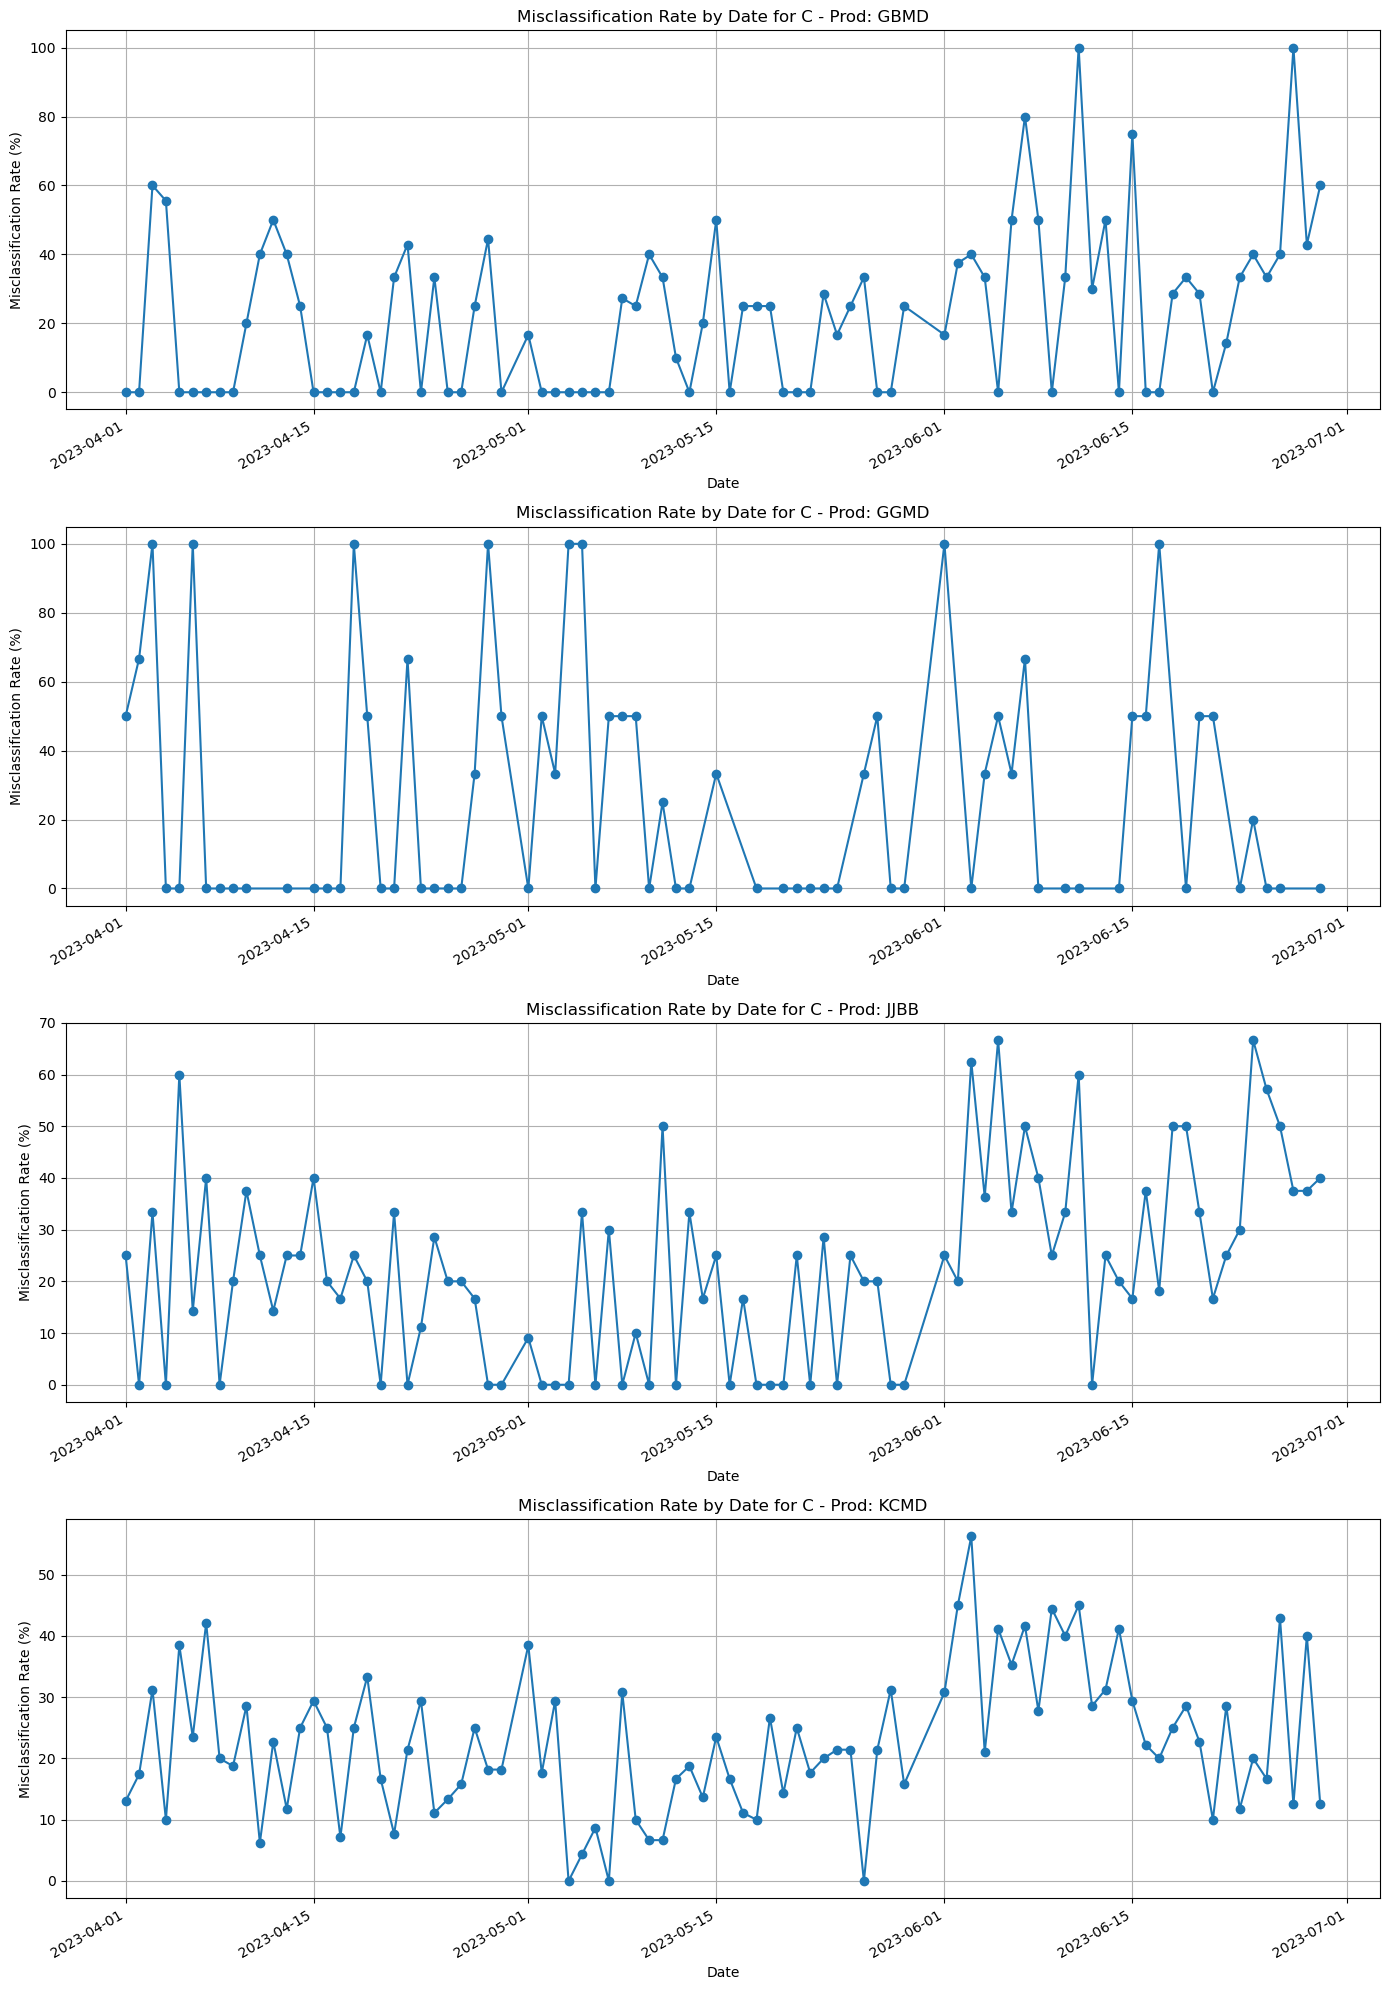

In [ ]:
# 'insp', 'date', 'prod'를 기준으로 그룹화하여 label이 1인 비율(오분류율) 계산
misclass_rates_prod = df_eda.groupby(['insp', 'date', 'prod'])['label'].mean().reset_index()

# 오분류율을 percentage로 변환
misclass_rates_prod['misclassification_rate'] = misclass_rates_prod['label'] * 100

# 'insp' 중 한 명을 선택 (예: 첫 번째 'insp')
selected_insp = misclass_rates_prod['insp'].unique()[0]

# 선택된 'insp'에 대한 데이터 필터링
selected_insp_data = misclass_rates_prod[misclass_rates_prod['insp'] == selected_insp]

# 각 'prod'에 대해 subplot 생성
num_prod = len(selected_insp_data['prod'].unique())
plt.figure(figsize=(14, num_prod * 5))

for idx, prod in enumerate(selected_insp_data['prod'].unique()):
    ax = plt.subplot(num_prod, 1, idx+1)
    # 'prod' 기준으로 데이터 필터링
    prod_data = selected_insp_data[selected_insp_data['prod'] == prod]

    # Pivot table 생성하여 날짜별로 오분류율을 시각화하기 쉽게 만듬
    prod_pivot = prod_data.pivot(index='date', columns='prod', values='misclassification_rate')

    # 그래프 그리기
    prod_pivot.plot(ax=ax, kind='line', marker='o')
    ax.set_title(f'Misclassification Rate by Date for {selected_insp} - Prod: {prod}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Misclassification Rate (%)')
    ax.legend().set_visible(False)
    ax.grid(True)

plt.tight_layout()
plt.show()


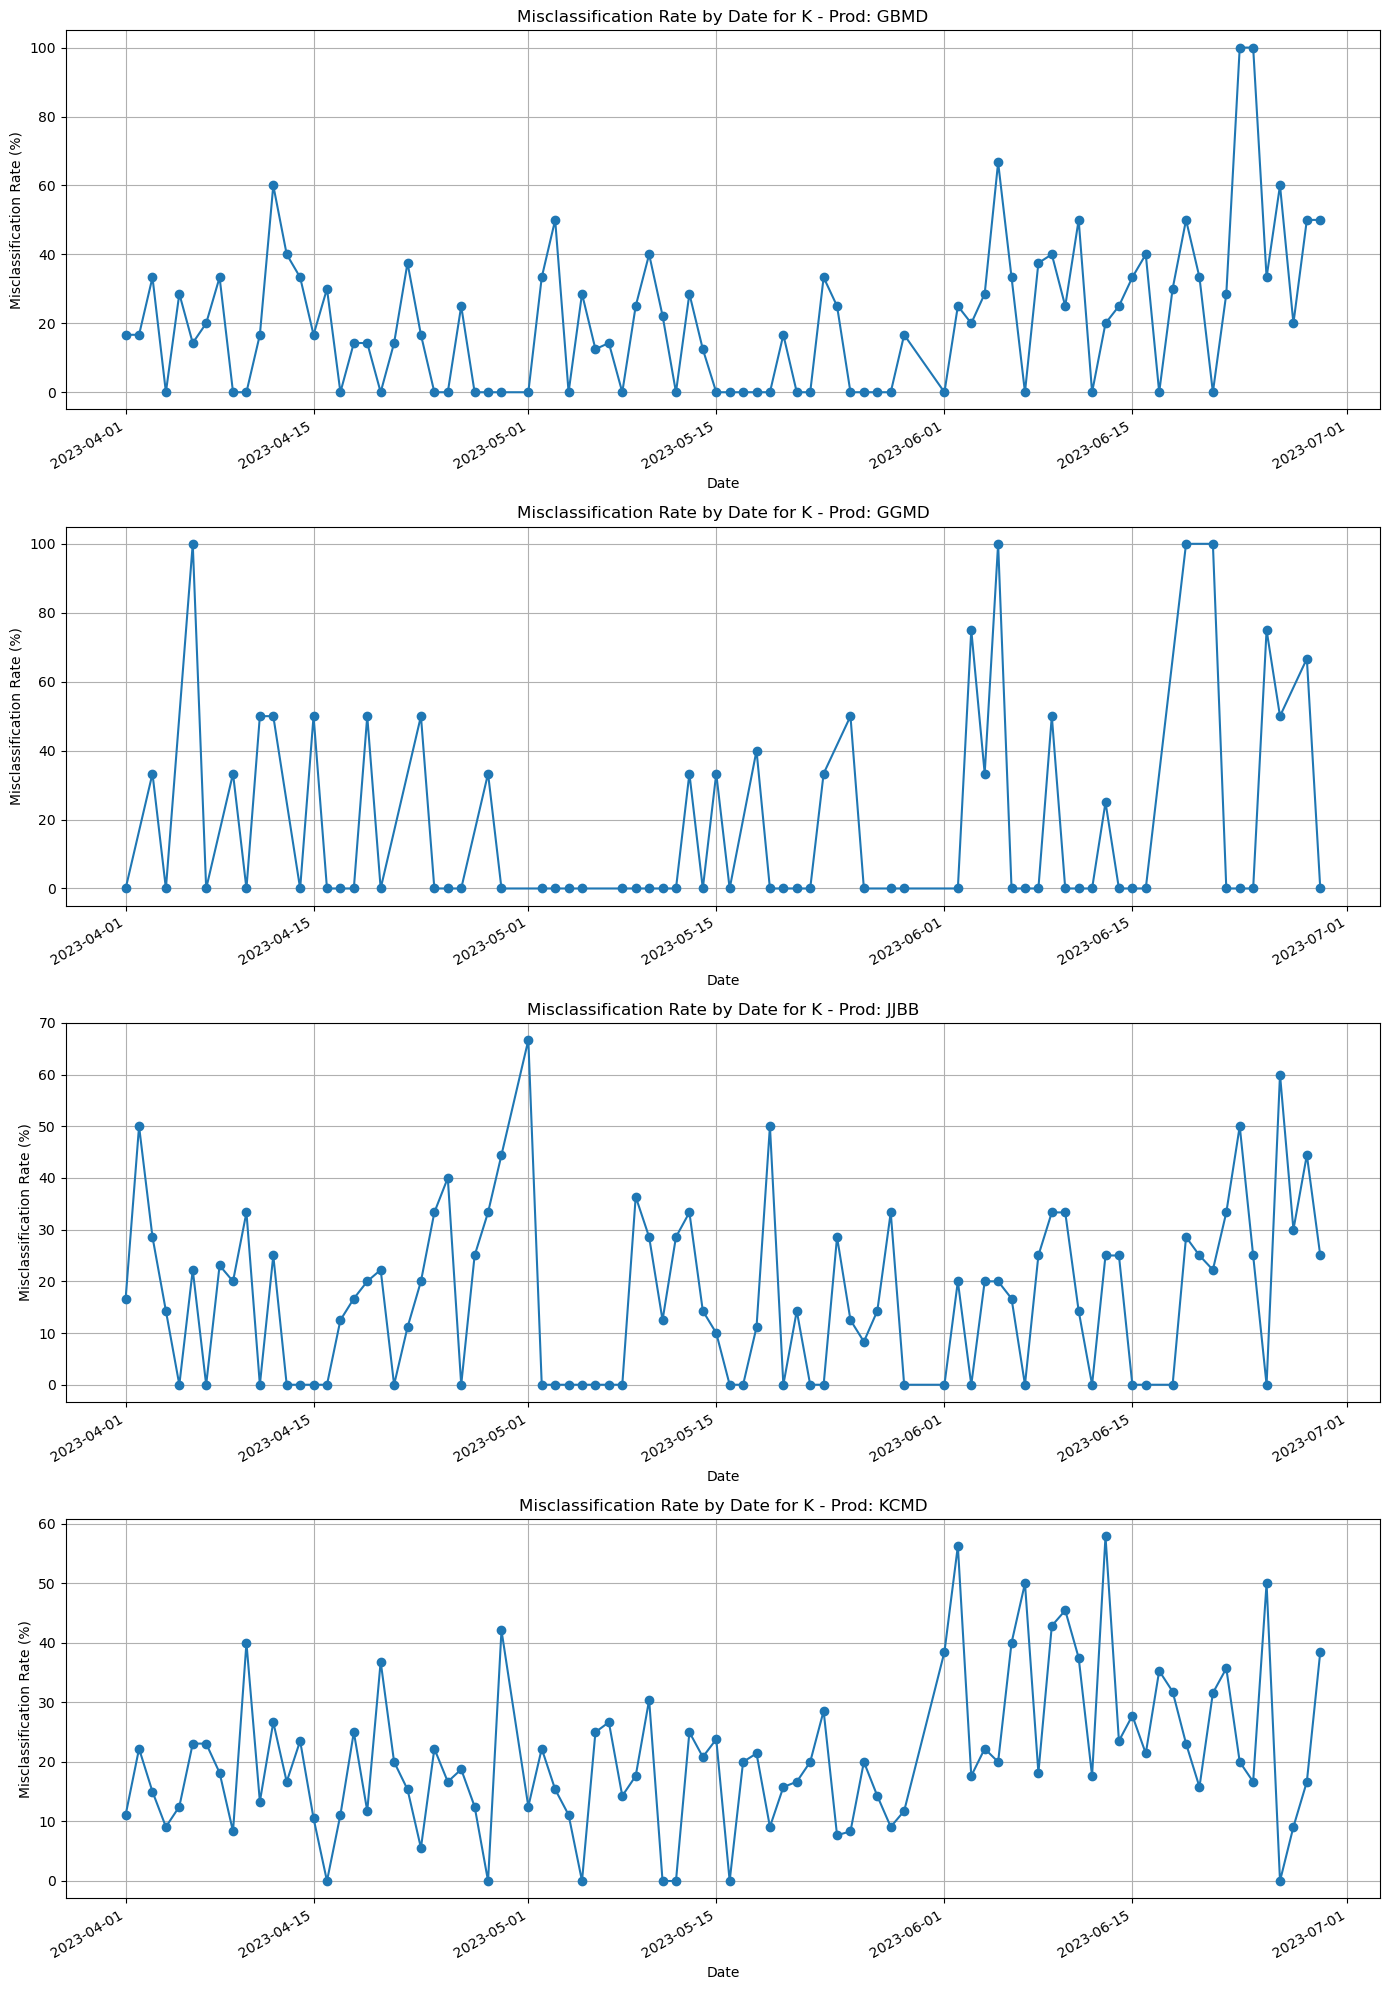

In [ ]:
import matplotlib.pyplot as plt

# 'insp', 'date', 'prod'를 기준으로 그룹화하여 label이 1인 비율(오분류율) 계산
misclass_rates_prod = df_eda.groupby(['insp', 'date', 'prod'])['label'].mean().reset_index()

# 오분류율을 percentage로 변환
misclass_rates_prod['misclassification_rate'] = misclass_rates_prod['label'] * 100

# 'insp' 중 한 명을 선택 (예: 첫 번째 'insp')
selected_insp = misclass_rates_prod['insp'].unique()[1]

# 선택된 'insp'에 대한 데이터 필터링
selected_insp_data = misclass_rates_prod[misclass_rates_prod['insp'] == selected_insp]

# 각 'prod'에 대해 subplot 생성
num_prod = len(selected_insp_data['prod'].unique())
plt.figure(figsize=(14, num_prod * 5))

for idx, prod in enumerate(selected_insp_data['prod'].unique()):
    ax = plt.subplot(num_prod, 1, idx+1)
    # 'prod' 기준으로 데이터 필터링
    prod_data = selected_insp_data[selected_insp_data['prod'] == prod]

    # Pivot table 생성하여 날짜별로 오분류율을 시각화하기 쉽게 만듬
    prod_pivot = prod_data.pivot(index='date', columns='prod', values='misclassification_rate')

    # 그래프 그리기
    prod_pivot.plot(ax=ax, kind='line', marker='o')
    ax.set_title(f'Misclassification Rate by Date for {selected_insp} - Prod: {prod}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Misclassification Rate (%)')
    ax.legend().set_visible(False)
    ax.grid(True)

plt.tight_layout()
plt.show()


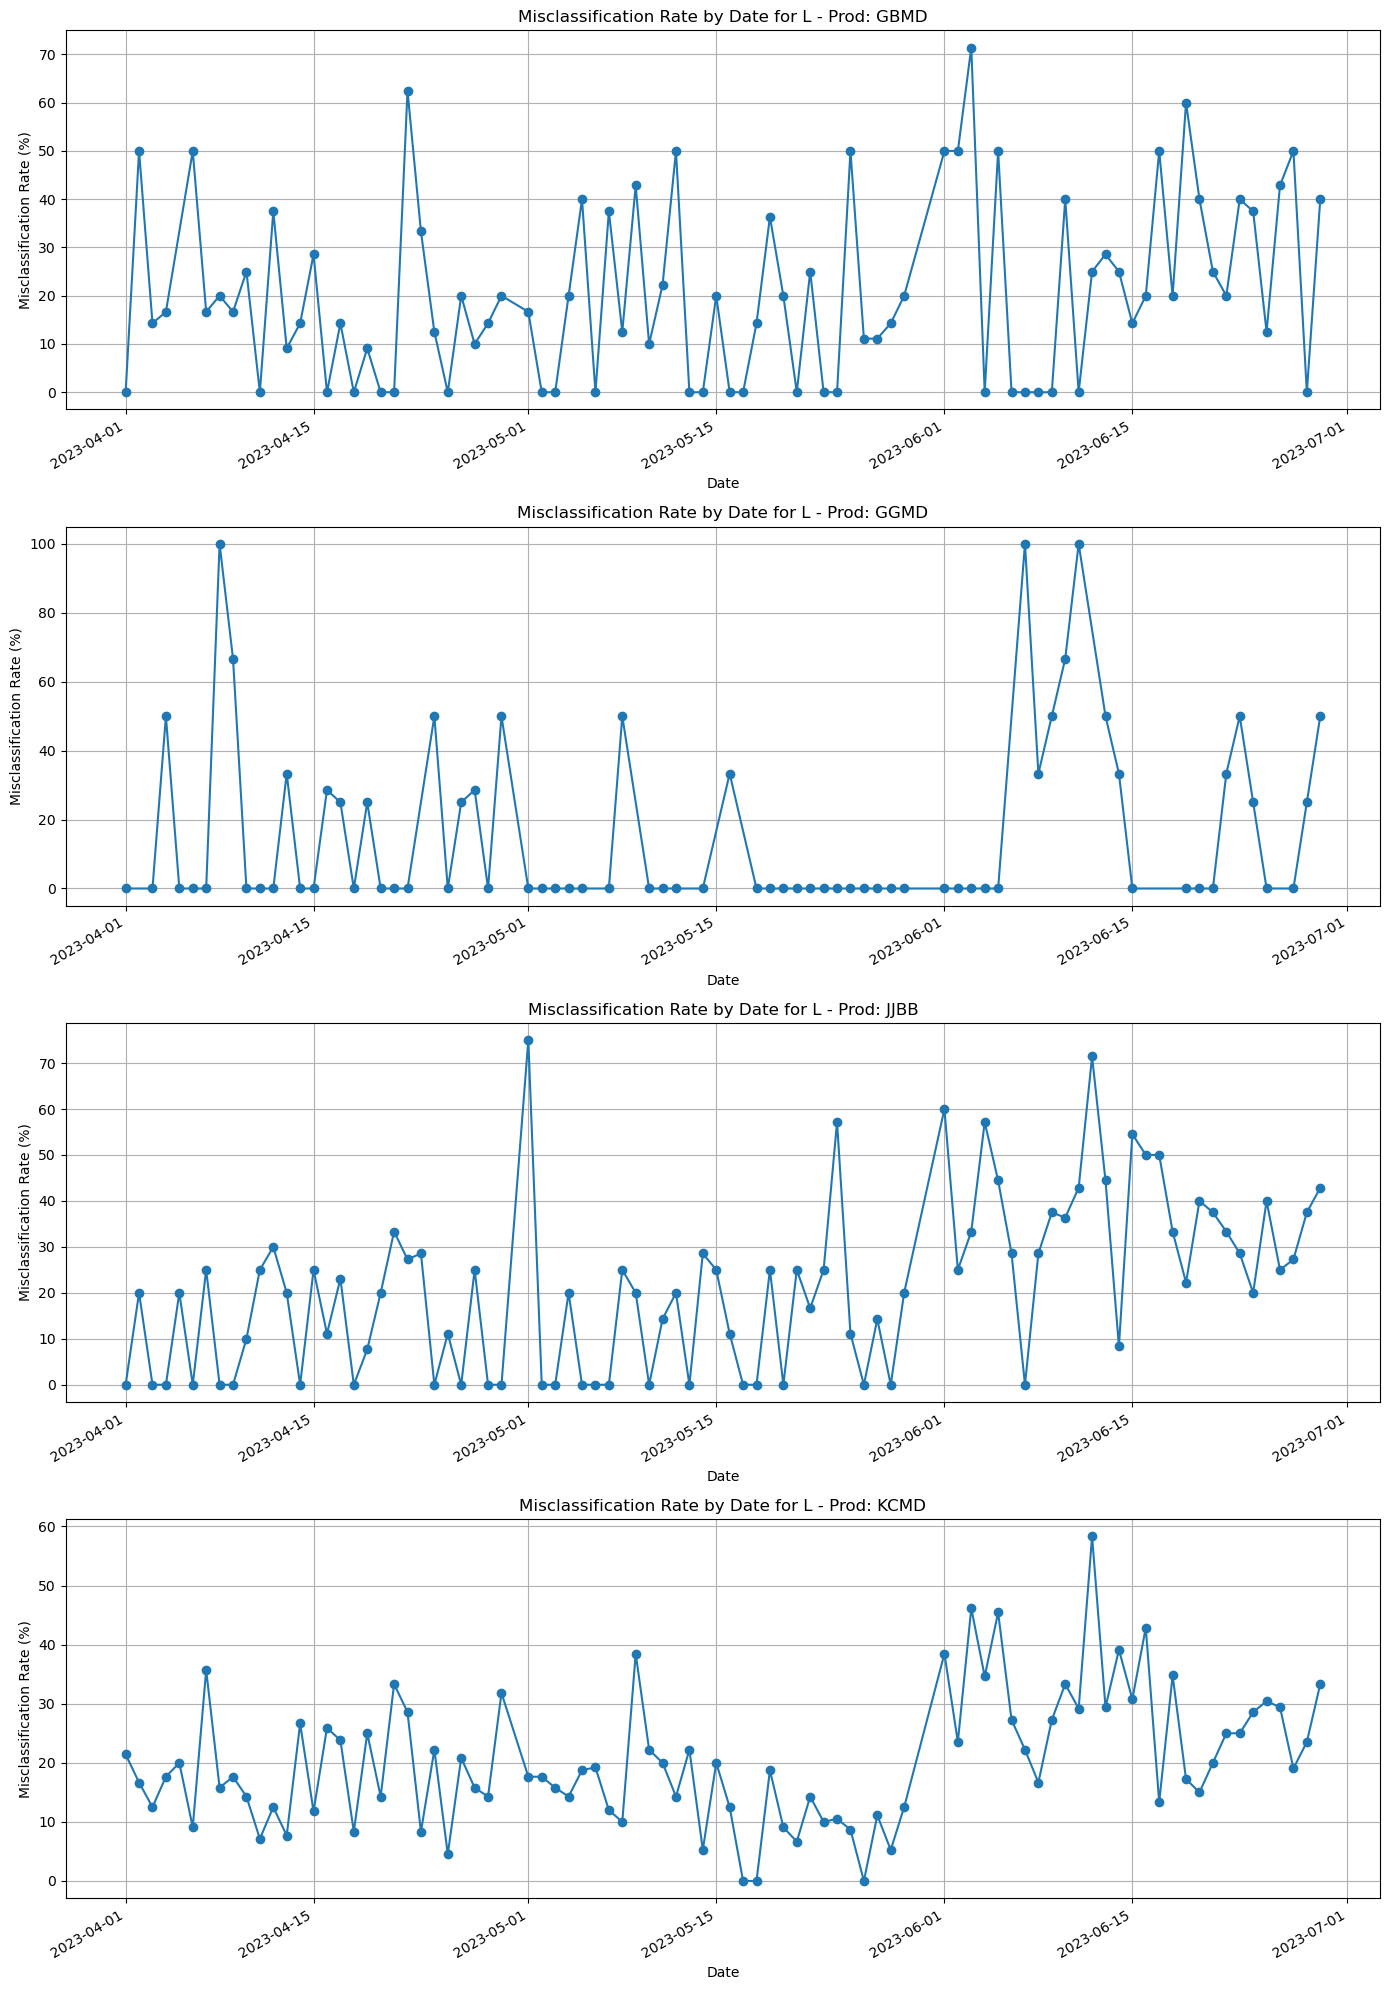

In [ ]:
import matplotlib.pyplot as plt

# 'insp', 'date', 'prod'를 기준으로 그룹화하여 label이 1인 비율(오분류율) 계산
misclass_rates_prod = df_eda.groupby(['insp', 'date', 'prod'])['label'].mean().reset_index()

# 오분류율을 percentage로 변환
misclass_rates_prod['misclassification_rate'] = misclass_rates_prod['label'] * 100

# 'insp' 중 한 명을 선택 (예: 첫 번째 'insp')
selected_insp = misclass_rates_prod['insp'].unique()[2]

# 선택된 'insp'에 대한 데이터 필터링
selected_insp_data = misclass_rates_prod[misclass_rates_prod['insp'] == selected_insp]

# 각 'prod'에 대해 subplot 생성
num_prod = len(selected_insp_data['prod'].unique())
plt.figure(figsize=(14, num_prod * 5))

for idx, prod in enumerate(selected_insp_data['prod'].unique()):
    ax = plt.subplot(num_prod, 1, idx+1)
    # 'prod' 기준으로 데이터 필터링
    prod_data = selected_insp_data[selected_insp_data['prod'] == prod]

    # Pivot table 생성하여 날짜별로 오분류율을 시각화하기 쉽게 만듬
    prod_pivot = prod_data.pivot(index='date', columns='prod', values='misclassification_rate')

    # 그래프 그리기
    prod_pivot.plot(ax=ax, kind='line', marker='o')
    ax.set_title(f'Misclassification Rate by Date for {selected_insp} - Prod: {prod}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Misclassification Rate (%)')
    ax.legend().set_visible(False)
    ax.grid(True)

plt.tight_layout()
plt.show()


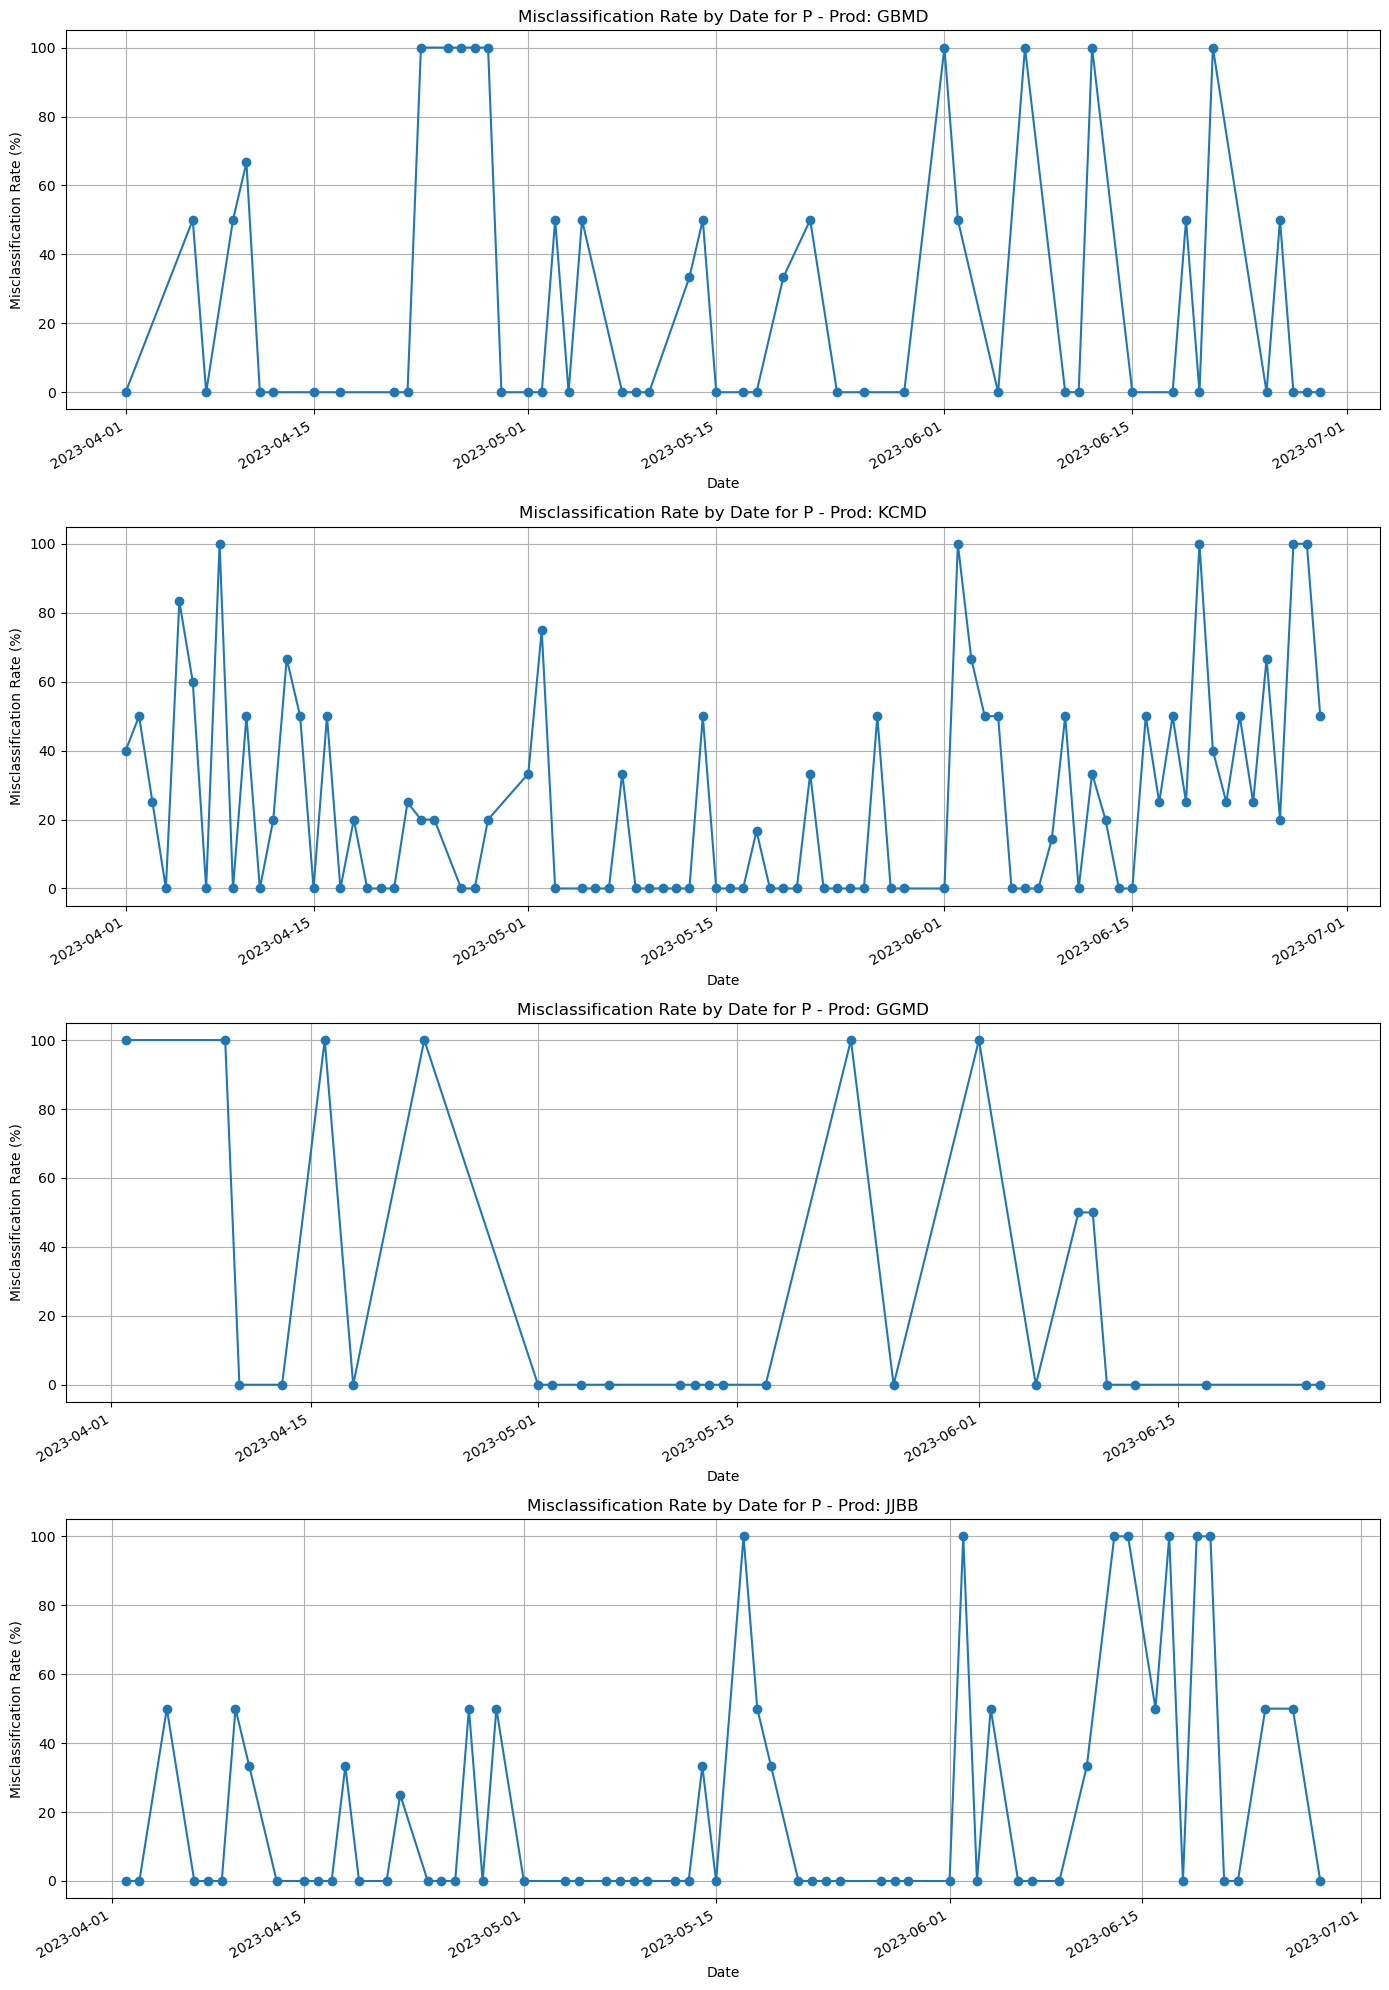

In [ ]:
import matplotlib.pyplot as plt

# 'insp', 'date', 'prod'를 기준으로 그룹화하여 label이 1인 비율(오분류율) 계산
misclass_rates_prod = df_eda.groupby(['insp', 'date', 'prod'])['label'].mean().reset_index()

# 오분류율을 percentage로 변환
misclass_rates_prod['misclassification_rate'] = misclass_rates_prod['label'] * 100

# 'insp' 중 한 명을 선택 (예: 첫 번째 'insp')
selected_insp = misclass_rates_prod['insp'].unique()[3]

# 선택된 'insp'에 대한 데이터 필터링
selected_insp_data = misclass_rates_prod[misclass_rates_prod['insp'] == selected_insp]

# 각 'prod'에 대해 subplot 생성
num_prod = len(selected_insp_data['prod'].unique())
plt.figure(figsize=(14, num_prod * 5))

for idx, prod in enumerate(selected_insp_data['prod'].unique()):
    ax = plt.subplot(num_prod, 1, idx+1)
    # 'prod' 기준으로 데이터 필터링
    prod_data = selected_insp_data[selected_insp_data['prod'] == prod]

    # Pivot table 생성하여 날짜별로 오분류율을 시각화하기 쉽게 만듬
    prod_pivot = prod_data.pivot(index='date', columns='prod', values='misclassification_rate')

    # 그래프 그리기
    prod_pivot.plot(ax=ax, kind='line', marker='o')
    ax.set_title(f'Misclassification Rate by Date for {selected_insp} - Prod: {prod}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Misclassification Rate (%)')
    ax.legend().set_visible(False)
    ax.grid(True)

plt.tight_layout()
plt.show()


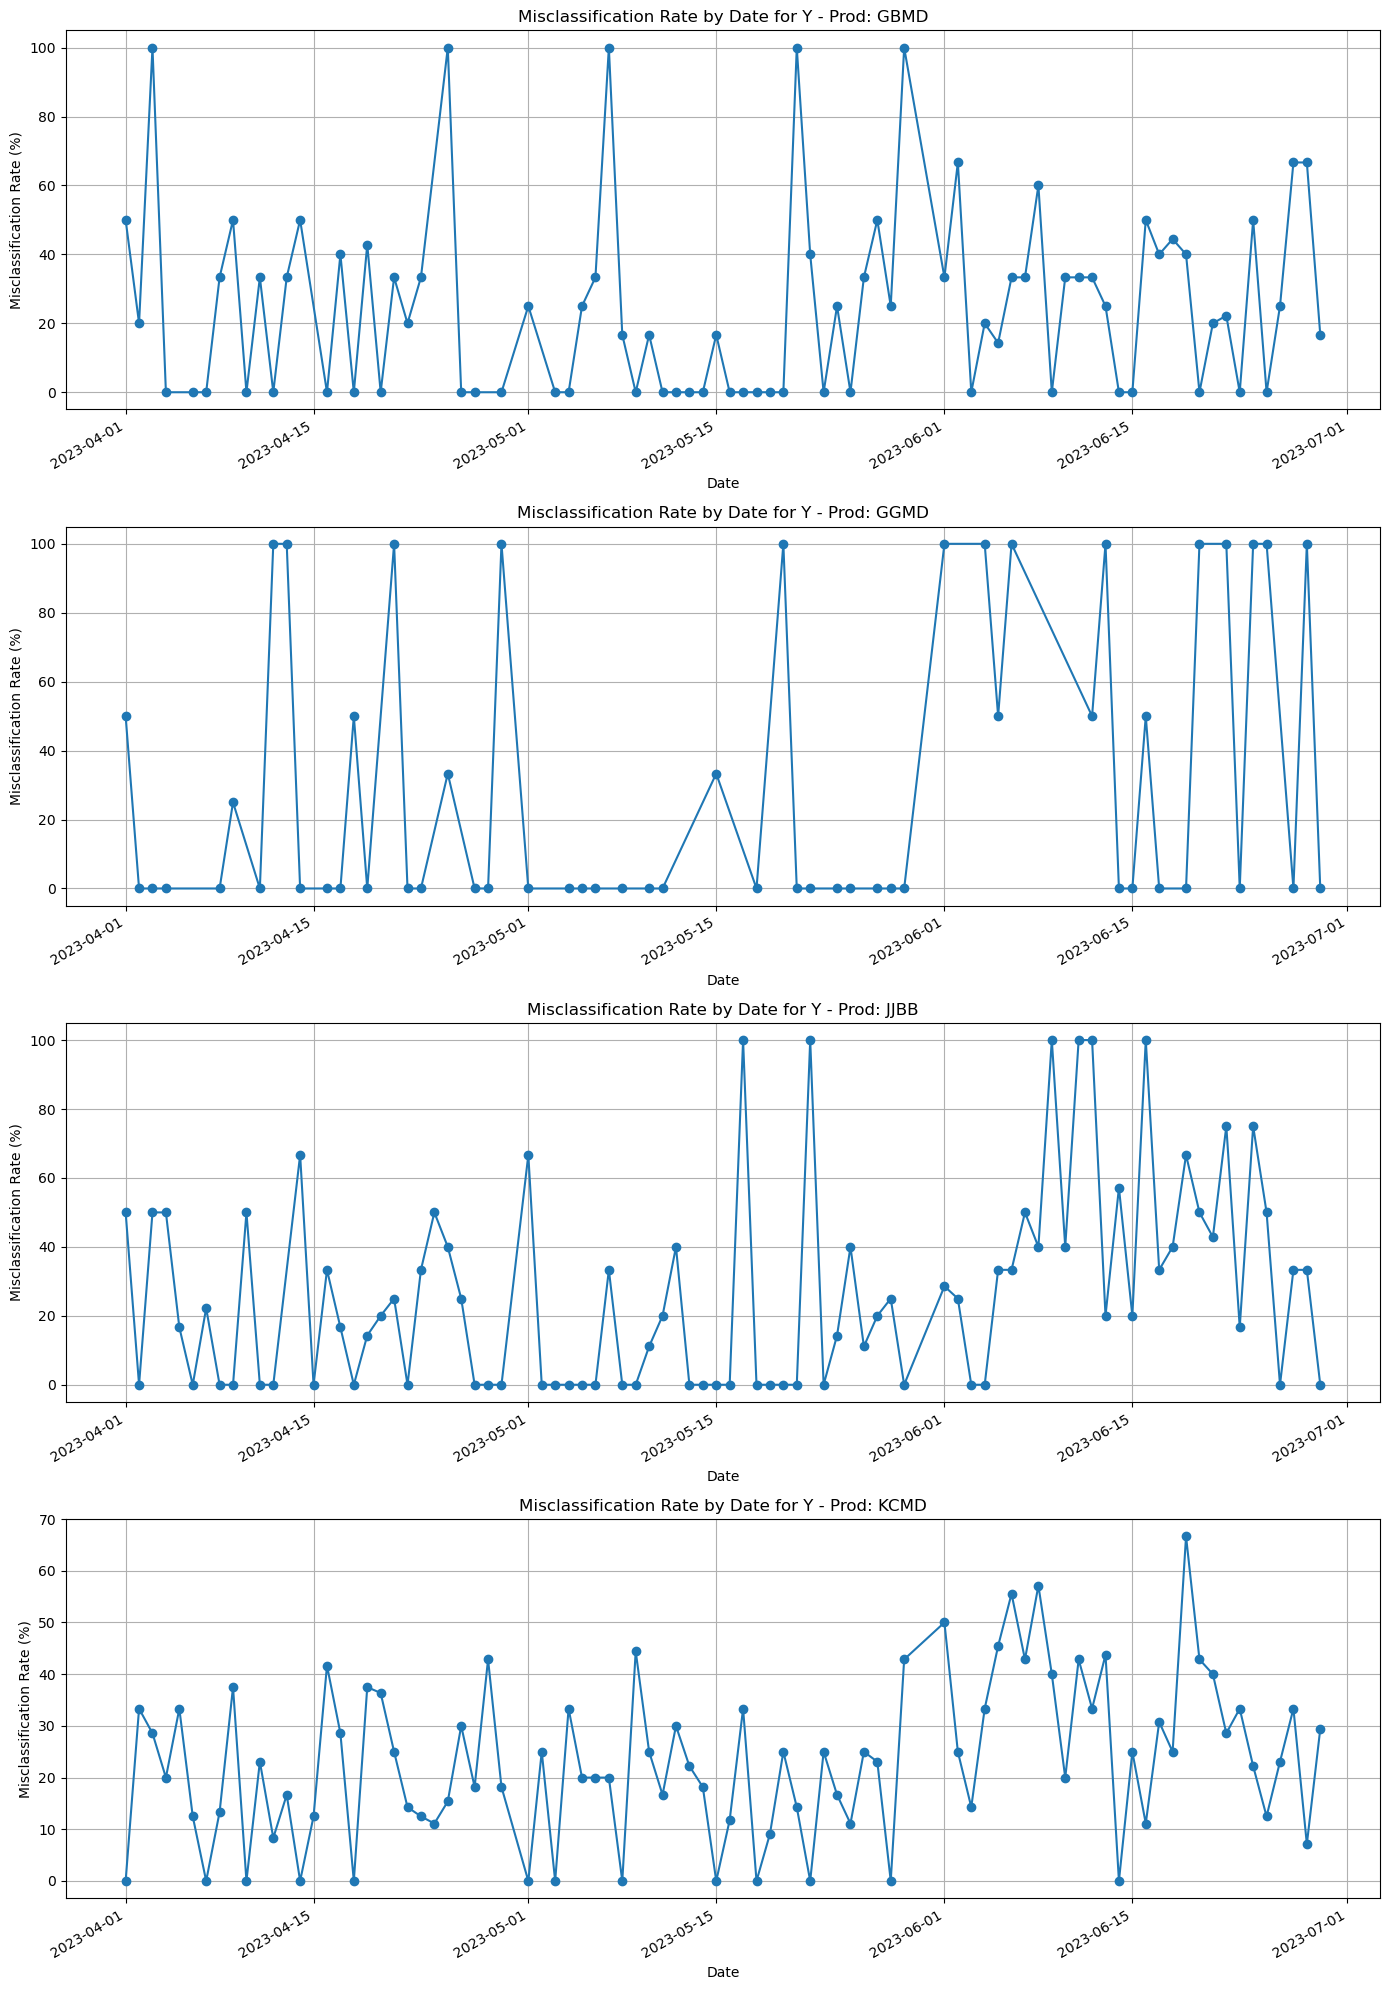

In [ ]:
import matplotlib.pyplot as plt

# 'insp', 'date', 'prod'를 기준으로 그룹화하여 label이 1인 비율(오분류율) 계산
misclass_rates_prod = df_eda.groupby(['insp', 'date', 'prod'])['label'].mean().reset_index()

# 오분류율을 percentage로 변환
misclass_rates_prod['misclassification_rate'] = misclass_rates_prod['label'] * 100

# 'insp' 중 한 명을 선택 (예: 첫 번째 'insp')
selected_insp = misclass_rates_prod['insp'].unique()[4]

# 선택된 'insp'에 대한 데이터 필터링
selected_insp_data = misclass_rates_prod[misclass_rates_prod['insp'] == selected_insp]

# 각 'prod'에 대해 subplot 생성
num_prod = len(selected_insp_data['prod'].unique())
plt.figure(figsize=(14, num_prod * 5))

for idx, prod in enumerate(selected_insp_data['prod'].unique()):
    ax = plt.subplot(num_prod, 1, idx+1)
    # 'prod' 기준으로 데이터 필터링
    prod_data = selected_insp_data[selected_insp_data['prod'] == prod]

    # Pivot table 생성하여 날짜별로 오분류율을 시각화하기 쉽게 만듬
    prod_pivot = prod_data.pivot(index='date', columns='prod', values='misclassification_rate')

    # 그래프 그리기
    prod_pivot.plot(ax=ax, kind='line', marker='o')
    ax.set_title(f'Misclassification Rate by Date for {selected_insp} - Prod: {prod}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Misclassification Rate (%)')
    ax.legend().set_visible(False)
    ax.grid(True)

plt.tight_layout()
plt.show()


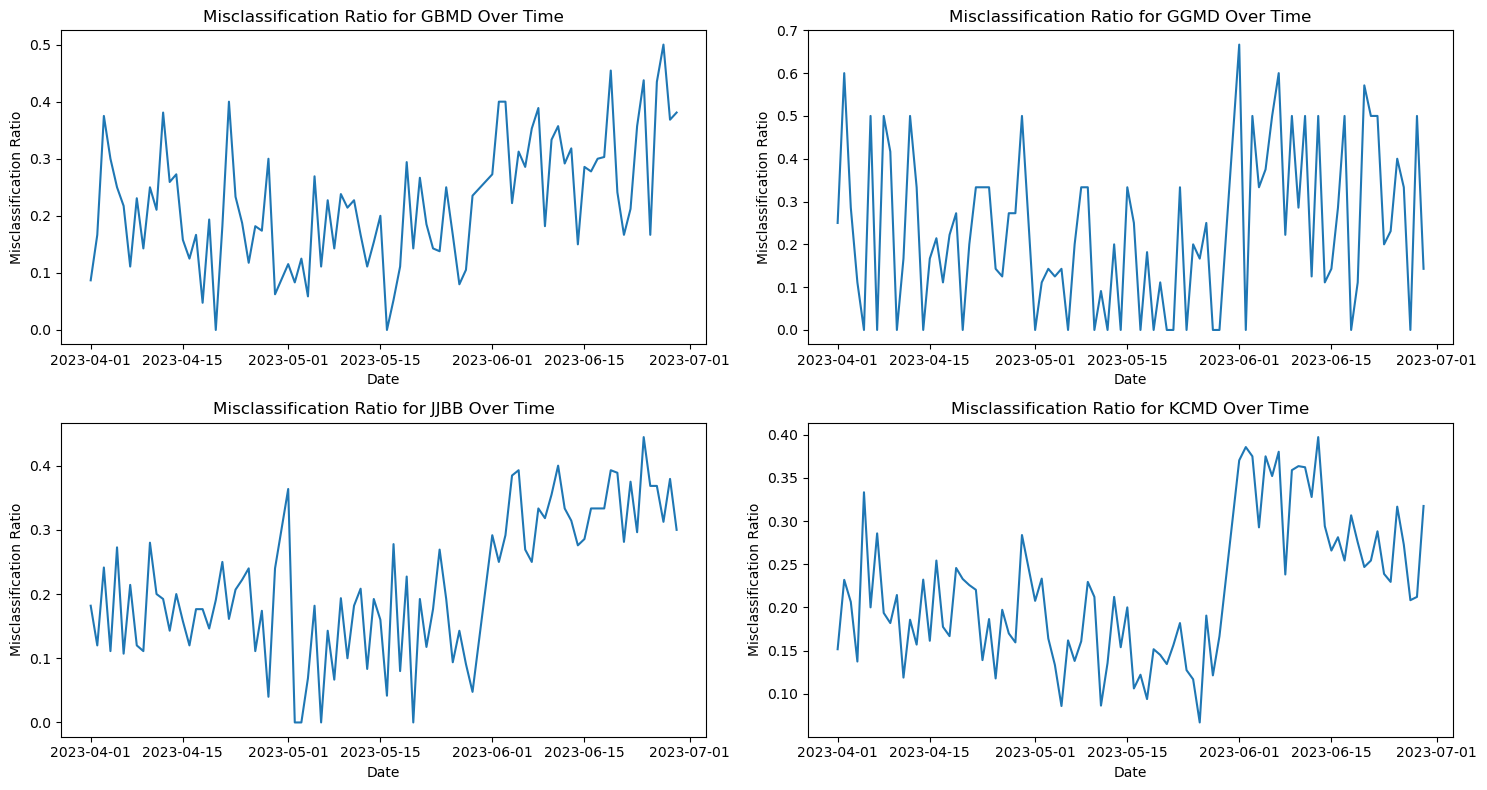

In [ ]:
prod_label_ratio = df_eda.groupby(['date', 'prod'])['label'].mean().unstack(fill_value=0)

# prod의 개수에 따라 subplot 생성
n_prods = len(prod_label_ratio.columns)
n_rows = int(np.ceil(n_prods / 2))
fig, axes = plt.subplots(n_rows, 2, figsize=(15, n_rows * 4))

# 각 prod별로 그래프 그리기
for i, prod in enumerate(prod_label_ratio.columns):
    ax = axes[i // 2, i % 2]
    sns.lineplot(x=prod_label_ratio.index, y=prod_label_ratio[prod], ax=ax)
    ax.set_title(f'Misclassification Ratio for {prod} Over Time')
    ax.set_ylabel('Misclassification Ratio')
    ax.set_xlabel('Date')

# 빈 subplot 제거
if n_prods % 2 != 0:
    fig.delaxes(axes[-1, -1])

plt.tight_layout()
plt.show()


# EDA : buydate(구매일자)

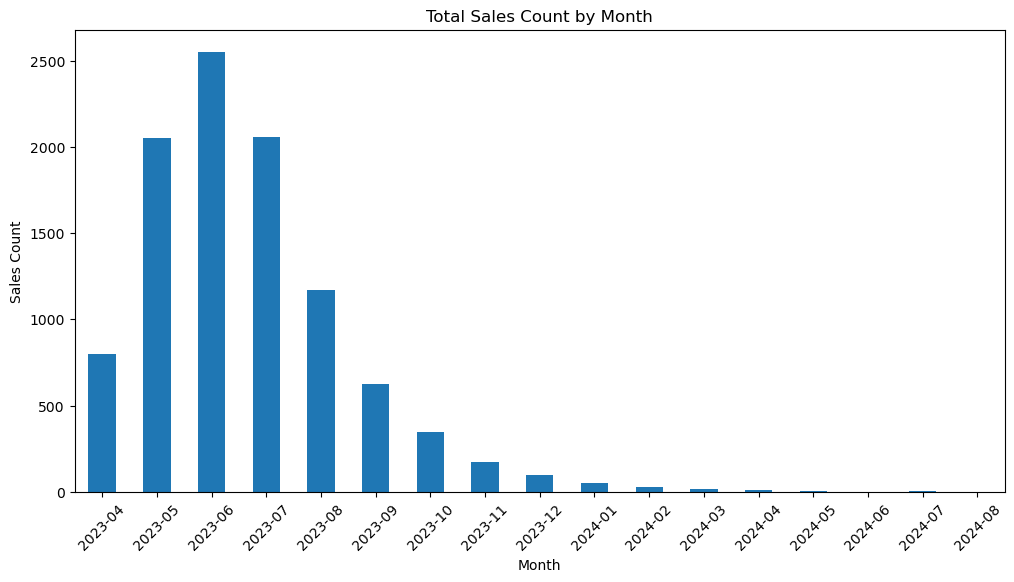

In [ ]:
df_eda['buydate'] = pd.to_datetime(df_eda['buydate'])
monthly_sales_count = df_eda.groupby(df_eda['buydate'].dt.to_period('M')).size()

# 월별 판매 개수의 히스토그램
plt.figure(figsize=(12, 6))
monthly_sales_count.plot(kind='bar')
plt.title('Total Sales Count by Month')
plt.xlabel('Month')
plt.ylabel('Sales Count')
plt.xticks(rotation=45)
plt.show()

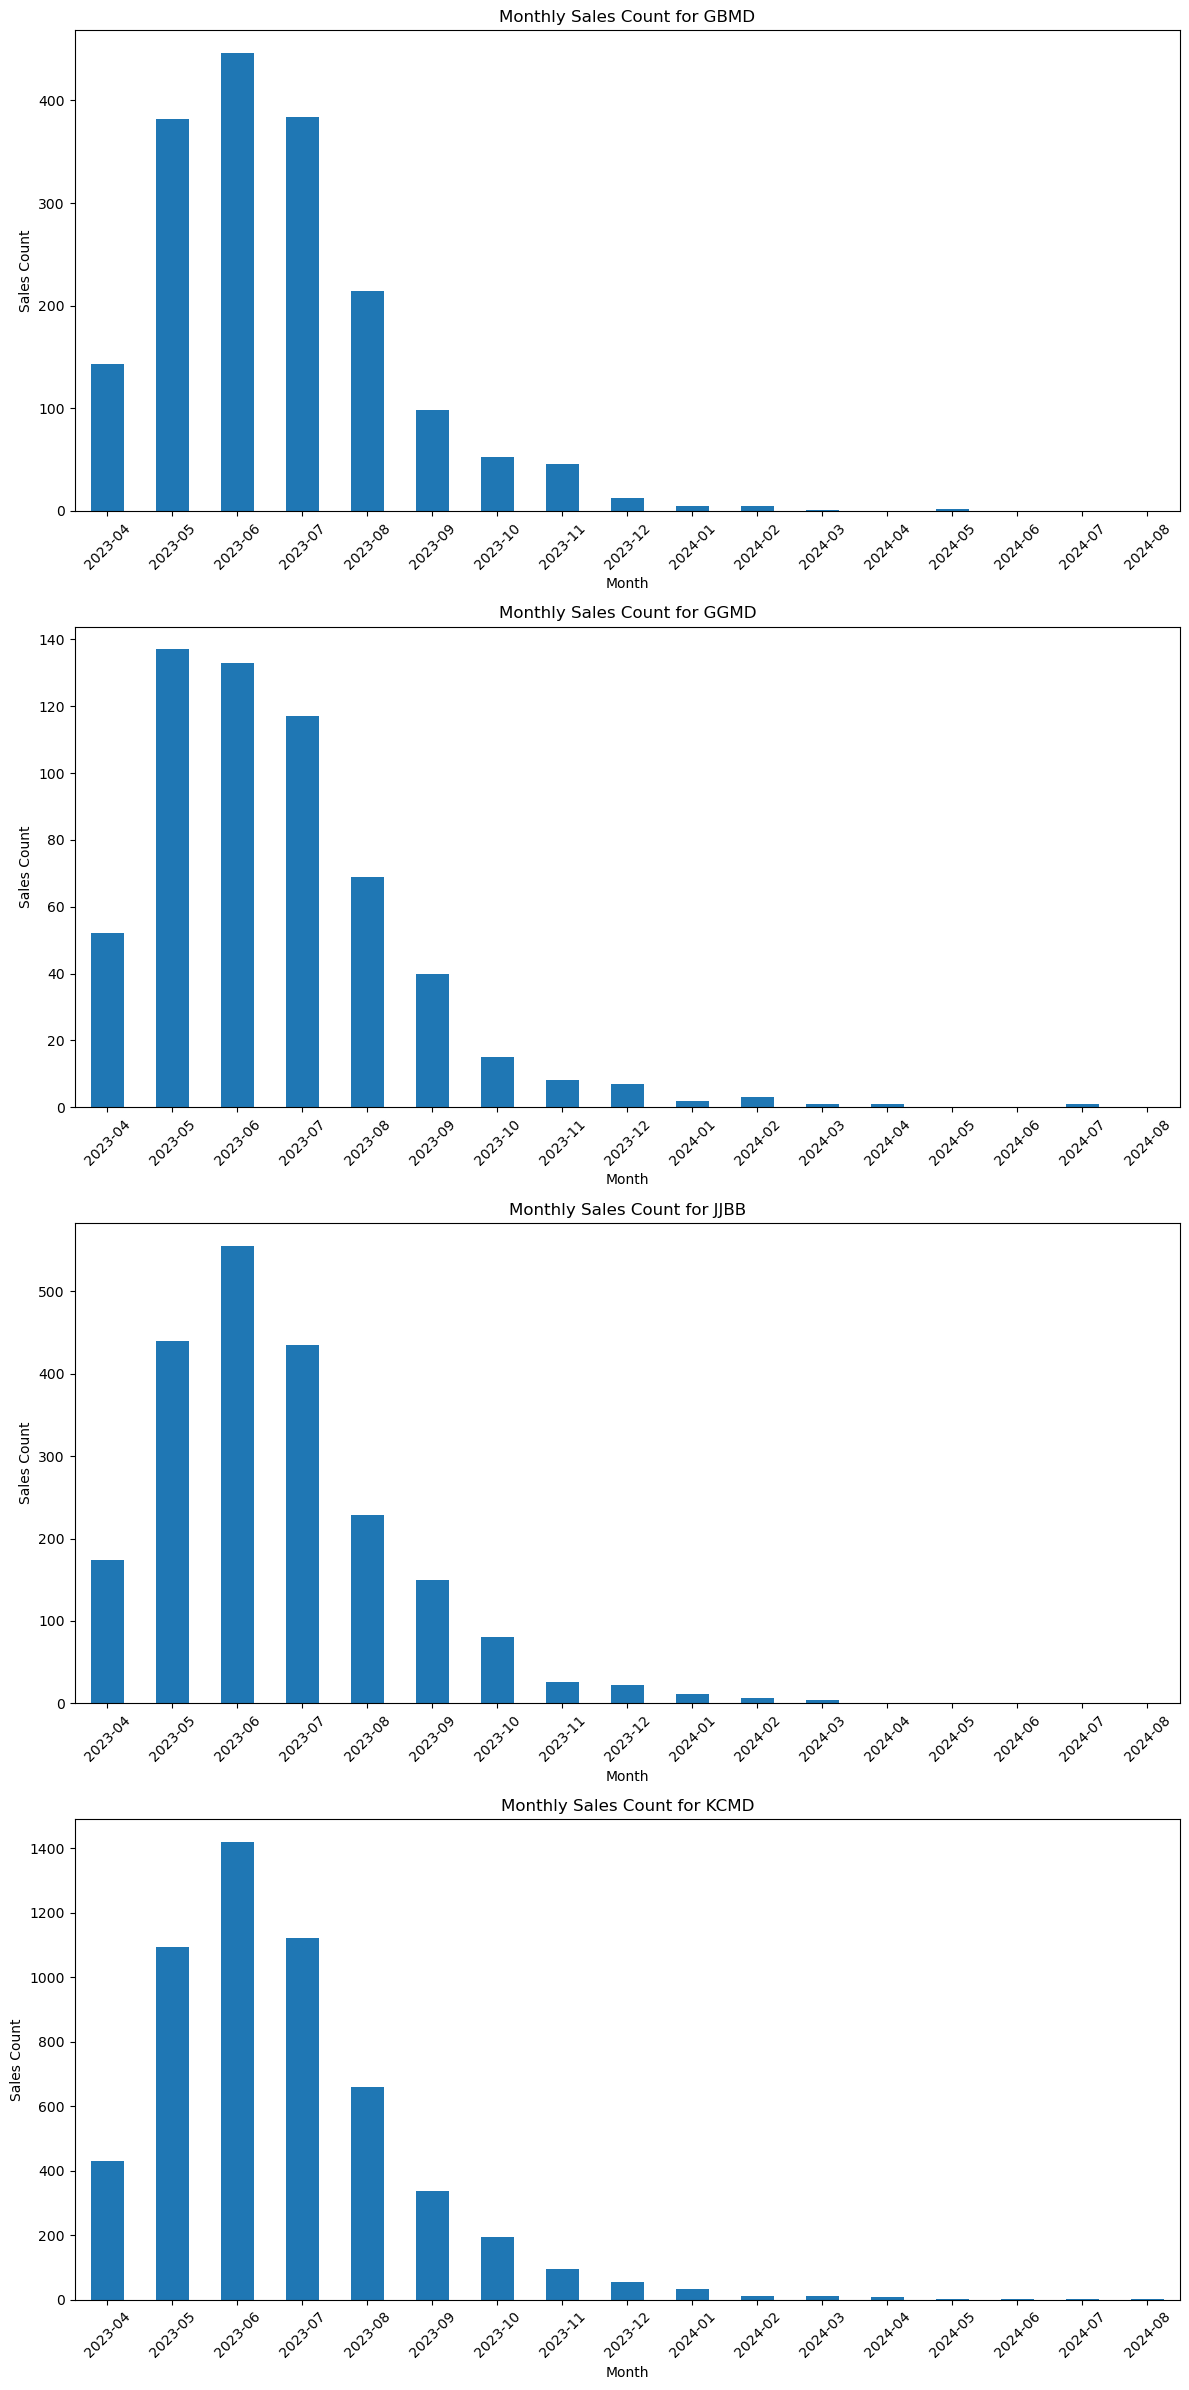

In [ ]:
# 날짜 형식으로 변환
df_eda['buydate'] = pd.to_datetime(df_eda['buydate'])

# 월별, prod별 판매 개수 계산
monthly_prod_sales = df_eda.groupby([df_eda['buydate'].dt.to_period('M'), 'prod']).size().unstack(fill_value=0)

# 각 prod에 대한 월별 판매 개수 히스토그램
n_prods = len(monthly_prod_sales.columns)
fig, axes = plt.subplots(n_prods, 1, figsize=(12, 6 * n_prods))

for i, prod in enumerate(monthly_prod_sales.columns):
    monthly_prod_sales[prod].plot(kind='bar', ax=axes[i])
    axes[i].set_title(f'Monthly Sales Count for {prod}')
    axes[i].set_xlabel('Month')
    axes[i].set_ylabel('Sales Count')
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


# EDA : ingr_A/B/C/extra

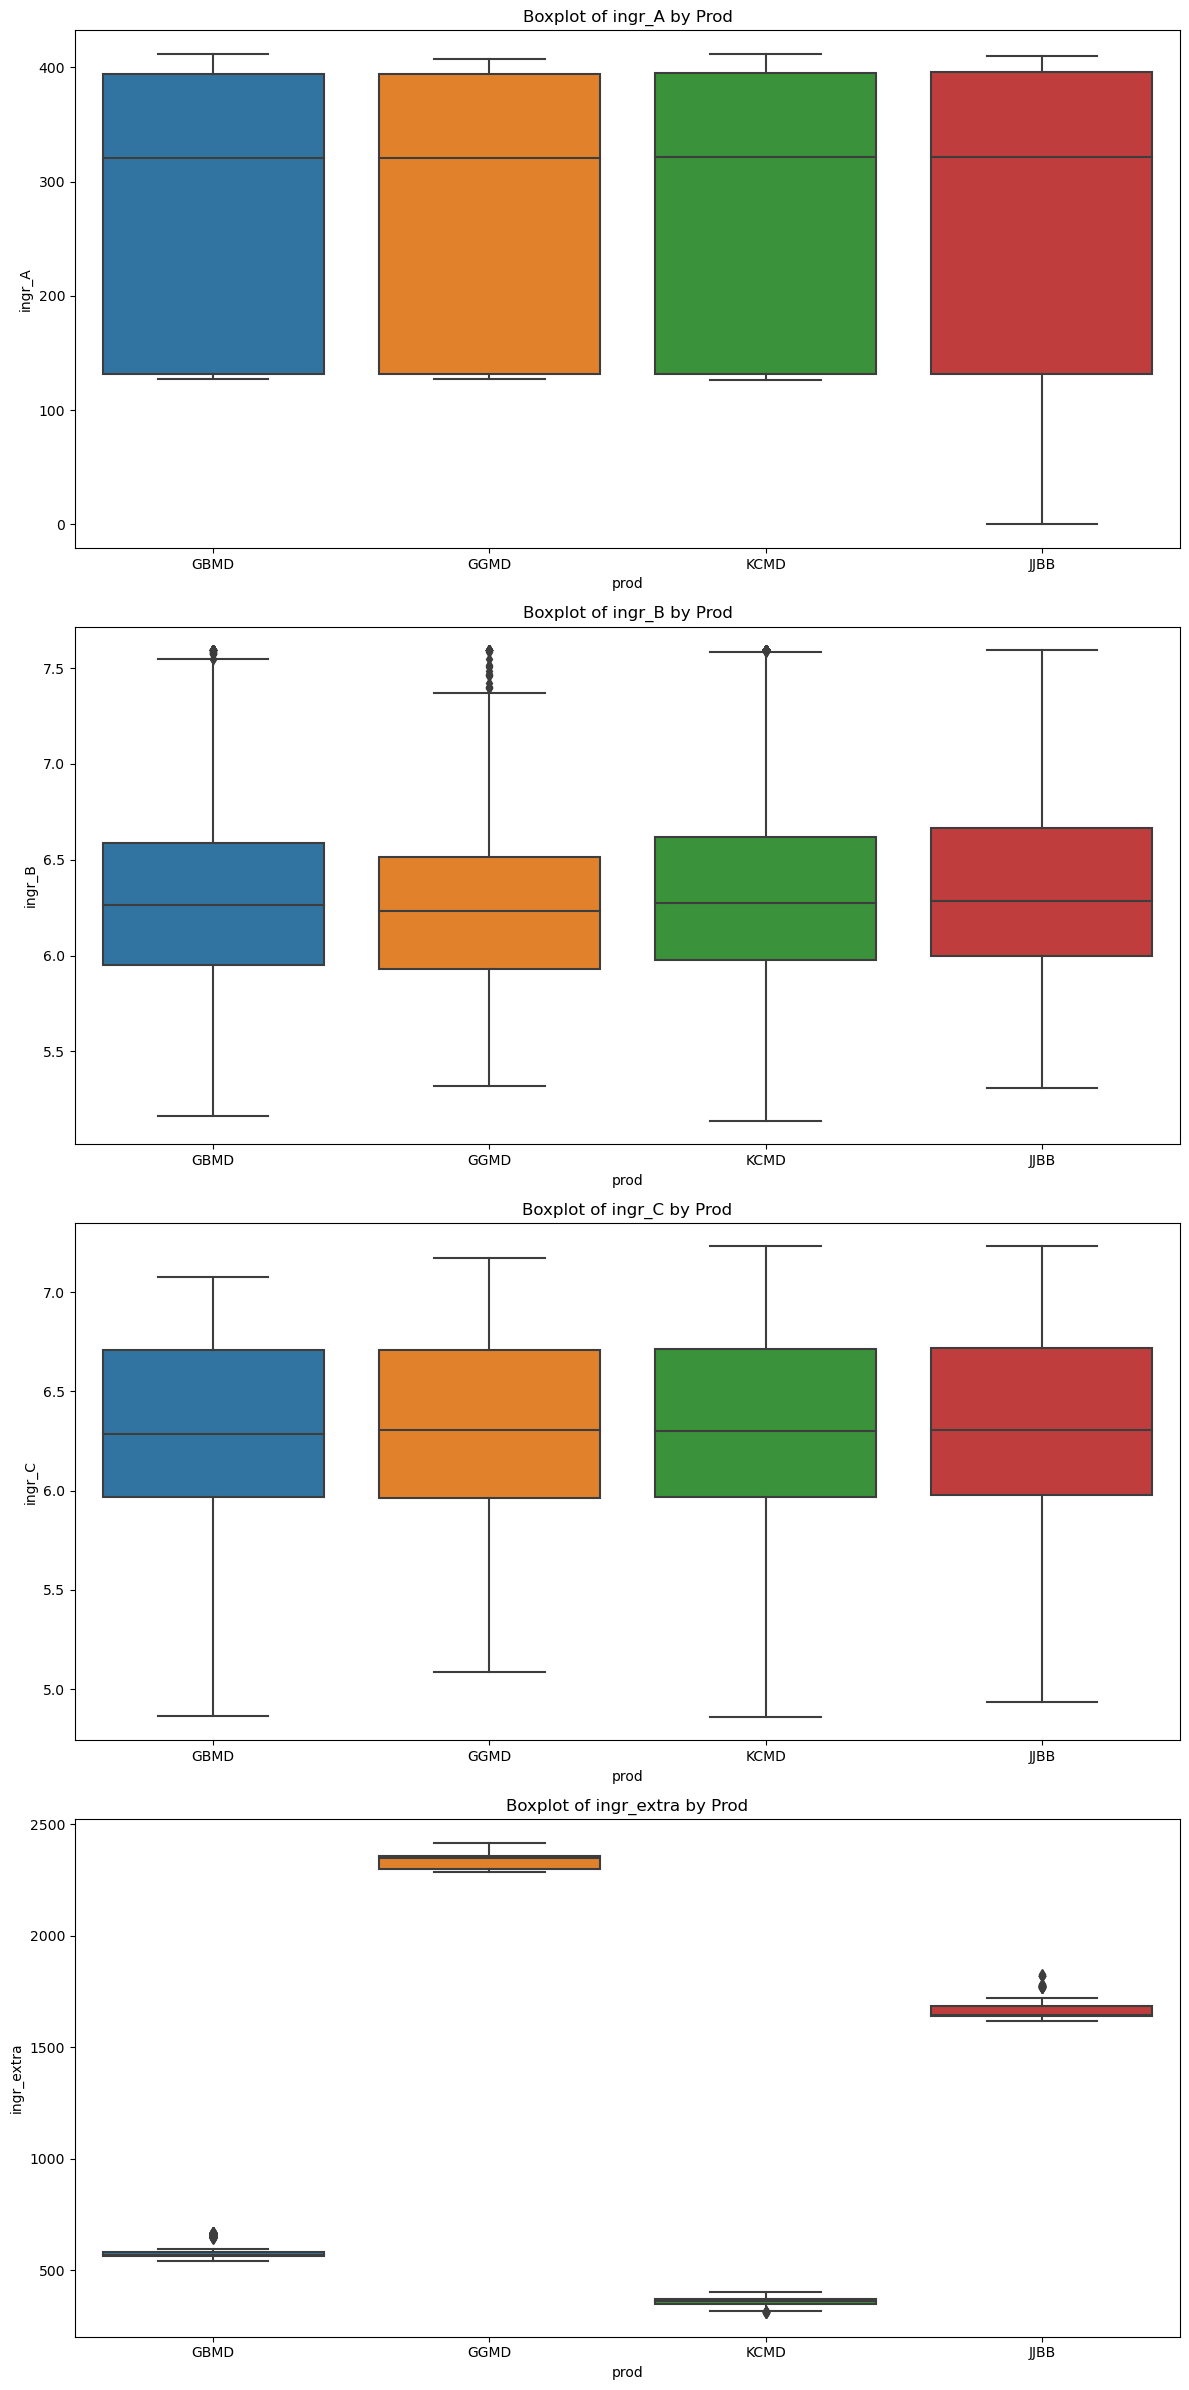

In [ ]:
fig, axes = plt.subplots(4, 1, figsize=(12, 24))

# ingr_A의 Boxplot
sns.boxplot(x='prod', y='ingr_A', data=df_eda, ax=axes[0])
axes[0].set_title('Boxplot of ingr_A by Prod')

# ingr_B의 Boxplot
sns.boxplot(x='prod', y='ingr_B', data=df_eda, ax=axes[1])
axes[1].set_title('Boxplot of ingr_B by Prod')

# ingr_C의 Boxplot
sns.boxplot(x='prod', y='ingr_C', data=df_eda, ax=axes[2])
axes[2].set_title('Boxplot of ingr_C by Prod')

# ingr_extra의 Boxplot
sns.boxplot(x='prod', y='ingr_extra', data=df_eda, ax=axes[3])
axes[3].set_title('Boxplot of ingr_extra by Prod')

plt.tight_layout()


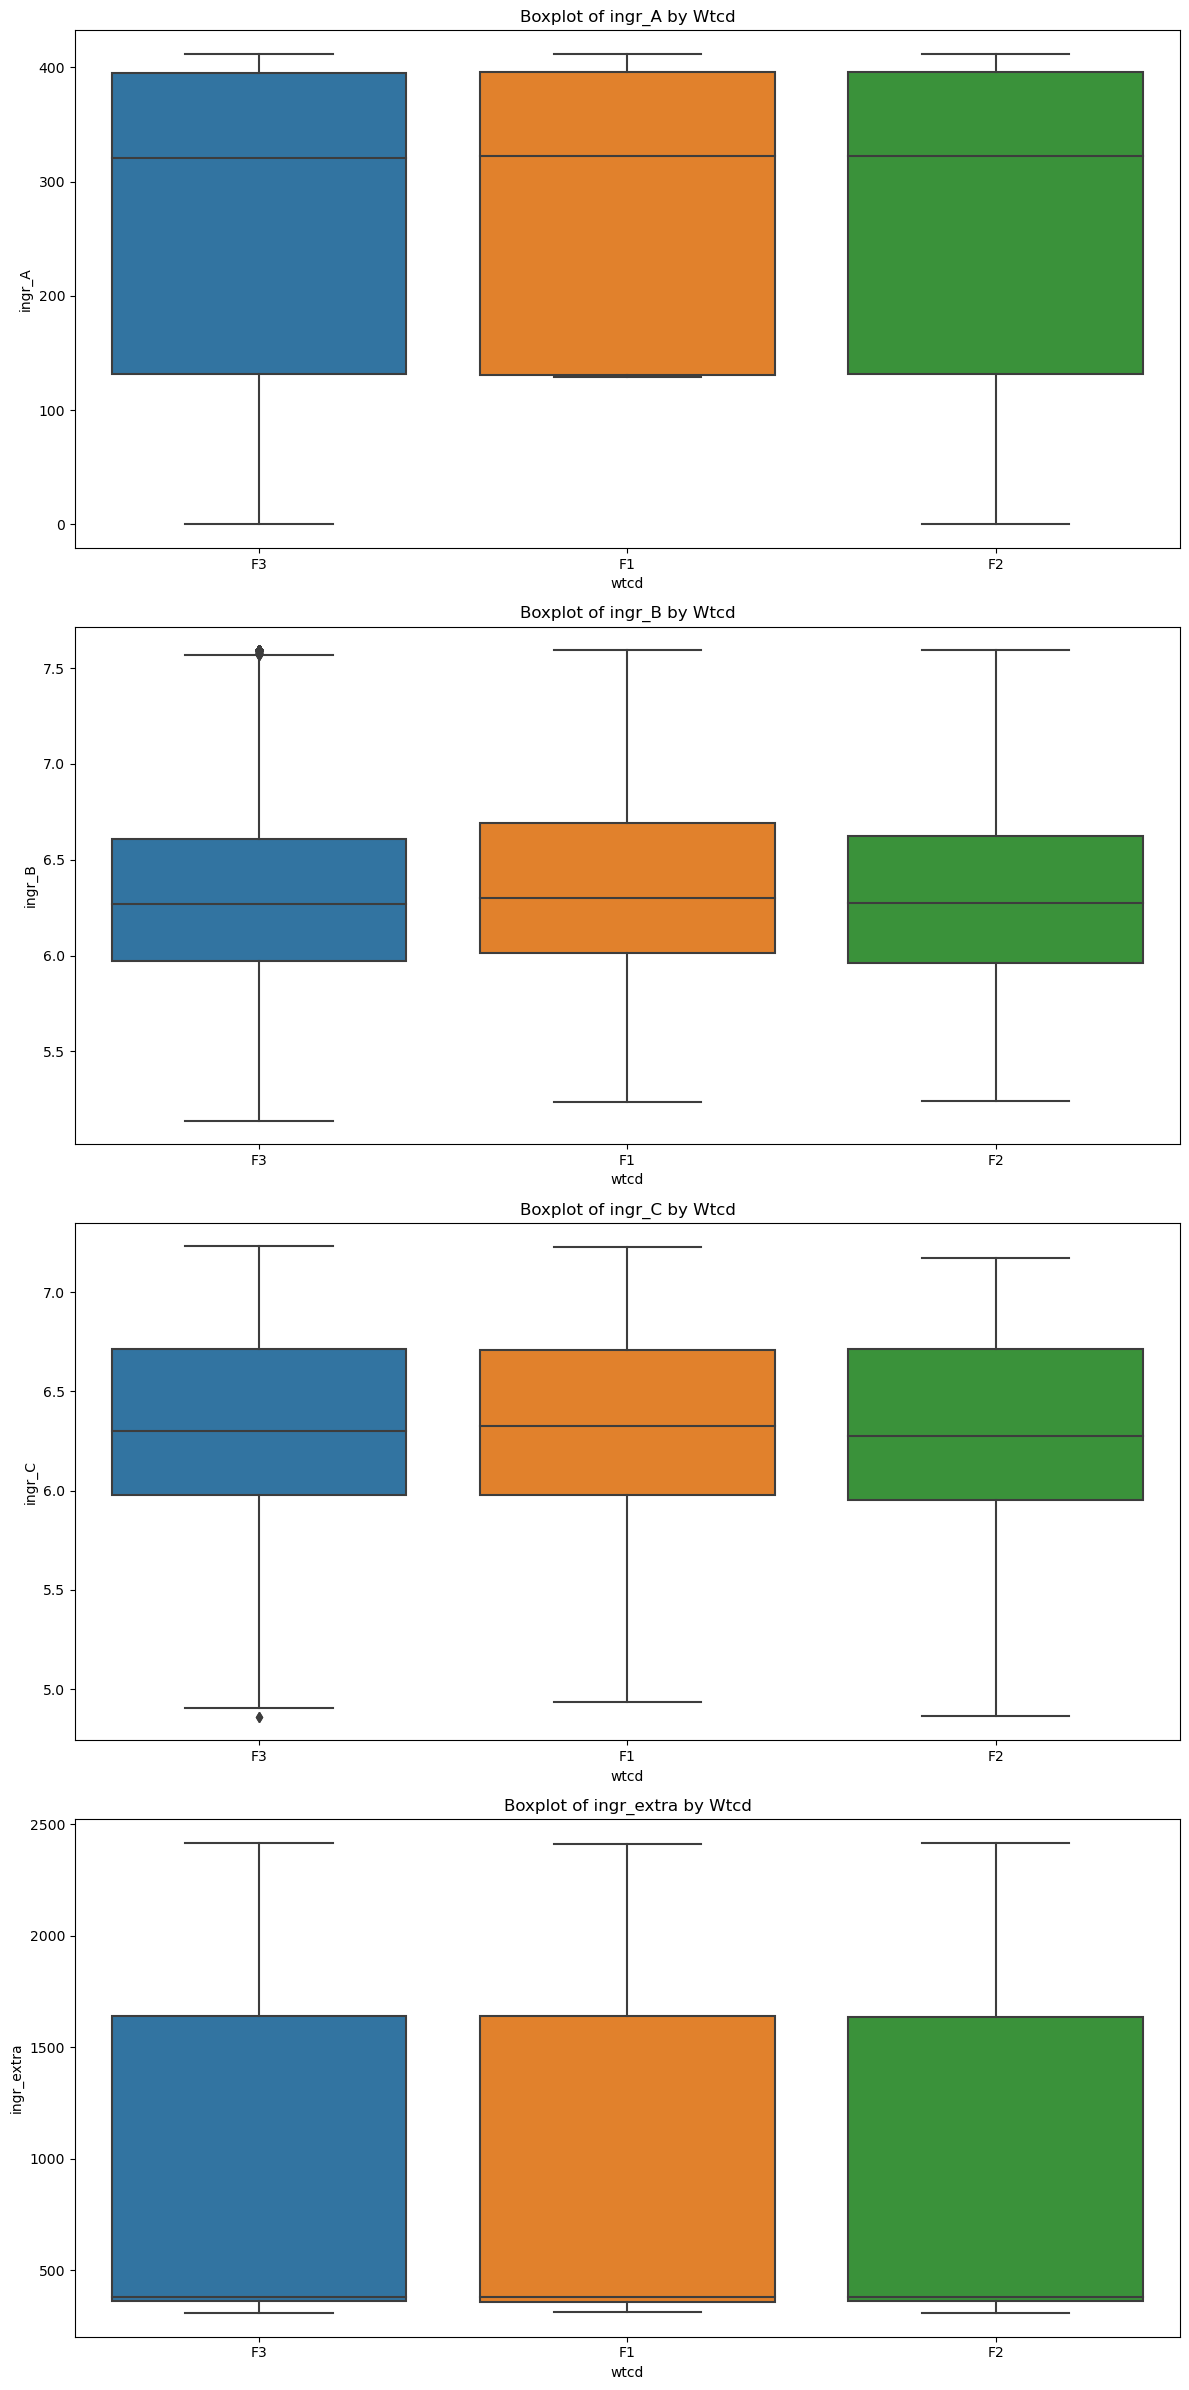

In [ ]:
fig, axes = plt.subplots(4, 1, figsize=(12, 24))

# ingr_A의 Boxplot
sns.boxplot(x='wtcd', y='ingr_A', data=df_eda, ax=axes[0])
axes[0].set_title('Boxplot of ingr_A by Wtcd')

# ingr_B의 Boxplot
sns.boxplot(x='wtcd', y='ingr_B', data=df_eda, ax=axes[1])
axes[1].set_title('Boxplot of ingr_B by Wtcd')

# ingr_C의 Boxplot
sns.boxplot(x='wtcd', y='ingr_C', data=df_eda, ax=axes[2])
axes[2].set_title('Boxplot of ingr_C by Wtcd')

# ingr_extra의 Boxplot
sns.boxplot(x='wtcd', y='ingr_extra', data=df_eda, ax=axes[3])
axes[3].set_title('Boxplot of ingr_extra by Wtcd')

plt.tight_layout()


/tmp/ipykernel_3825296/3893647746.py:19: UserWarning: Glyph 49328 (\N{HANGUL SYLLABLE SAN}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_3825296/3893647746.py:19: UserWarning: Glyph 52380 (\N{HANGUL SYLLABLE CEON}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_3825296/3893647746.py:19: UserWarning: Glyph 52285 (\N{HANGUL SYLLABLE CANG}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_3825296/3893647746.py:19: UserWarning: Glyph 54616 (\N{HANGUL SYLLABLE HA}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_3825296/3893647746.py:19: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_3825296/3893647746.py:19: UserWarning: Glyph 49457 (\N{HANGUL SYLLABLE SEONG}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_3825296/3893647746.py:19: UserWarning: Glyph 50724 (\N{HANGUL SYLLABLE O}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_38252

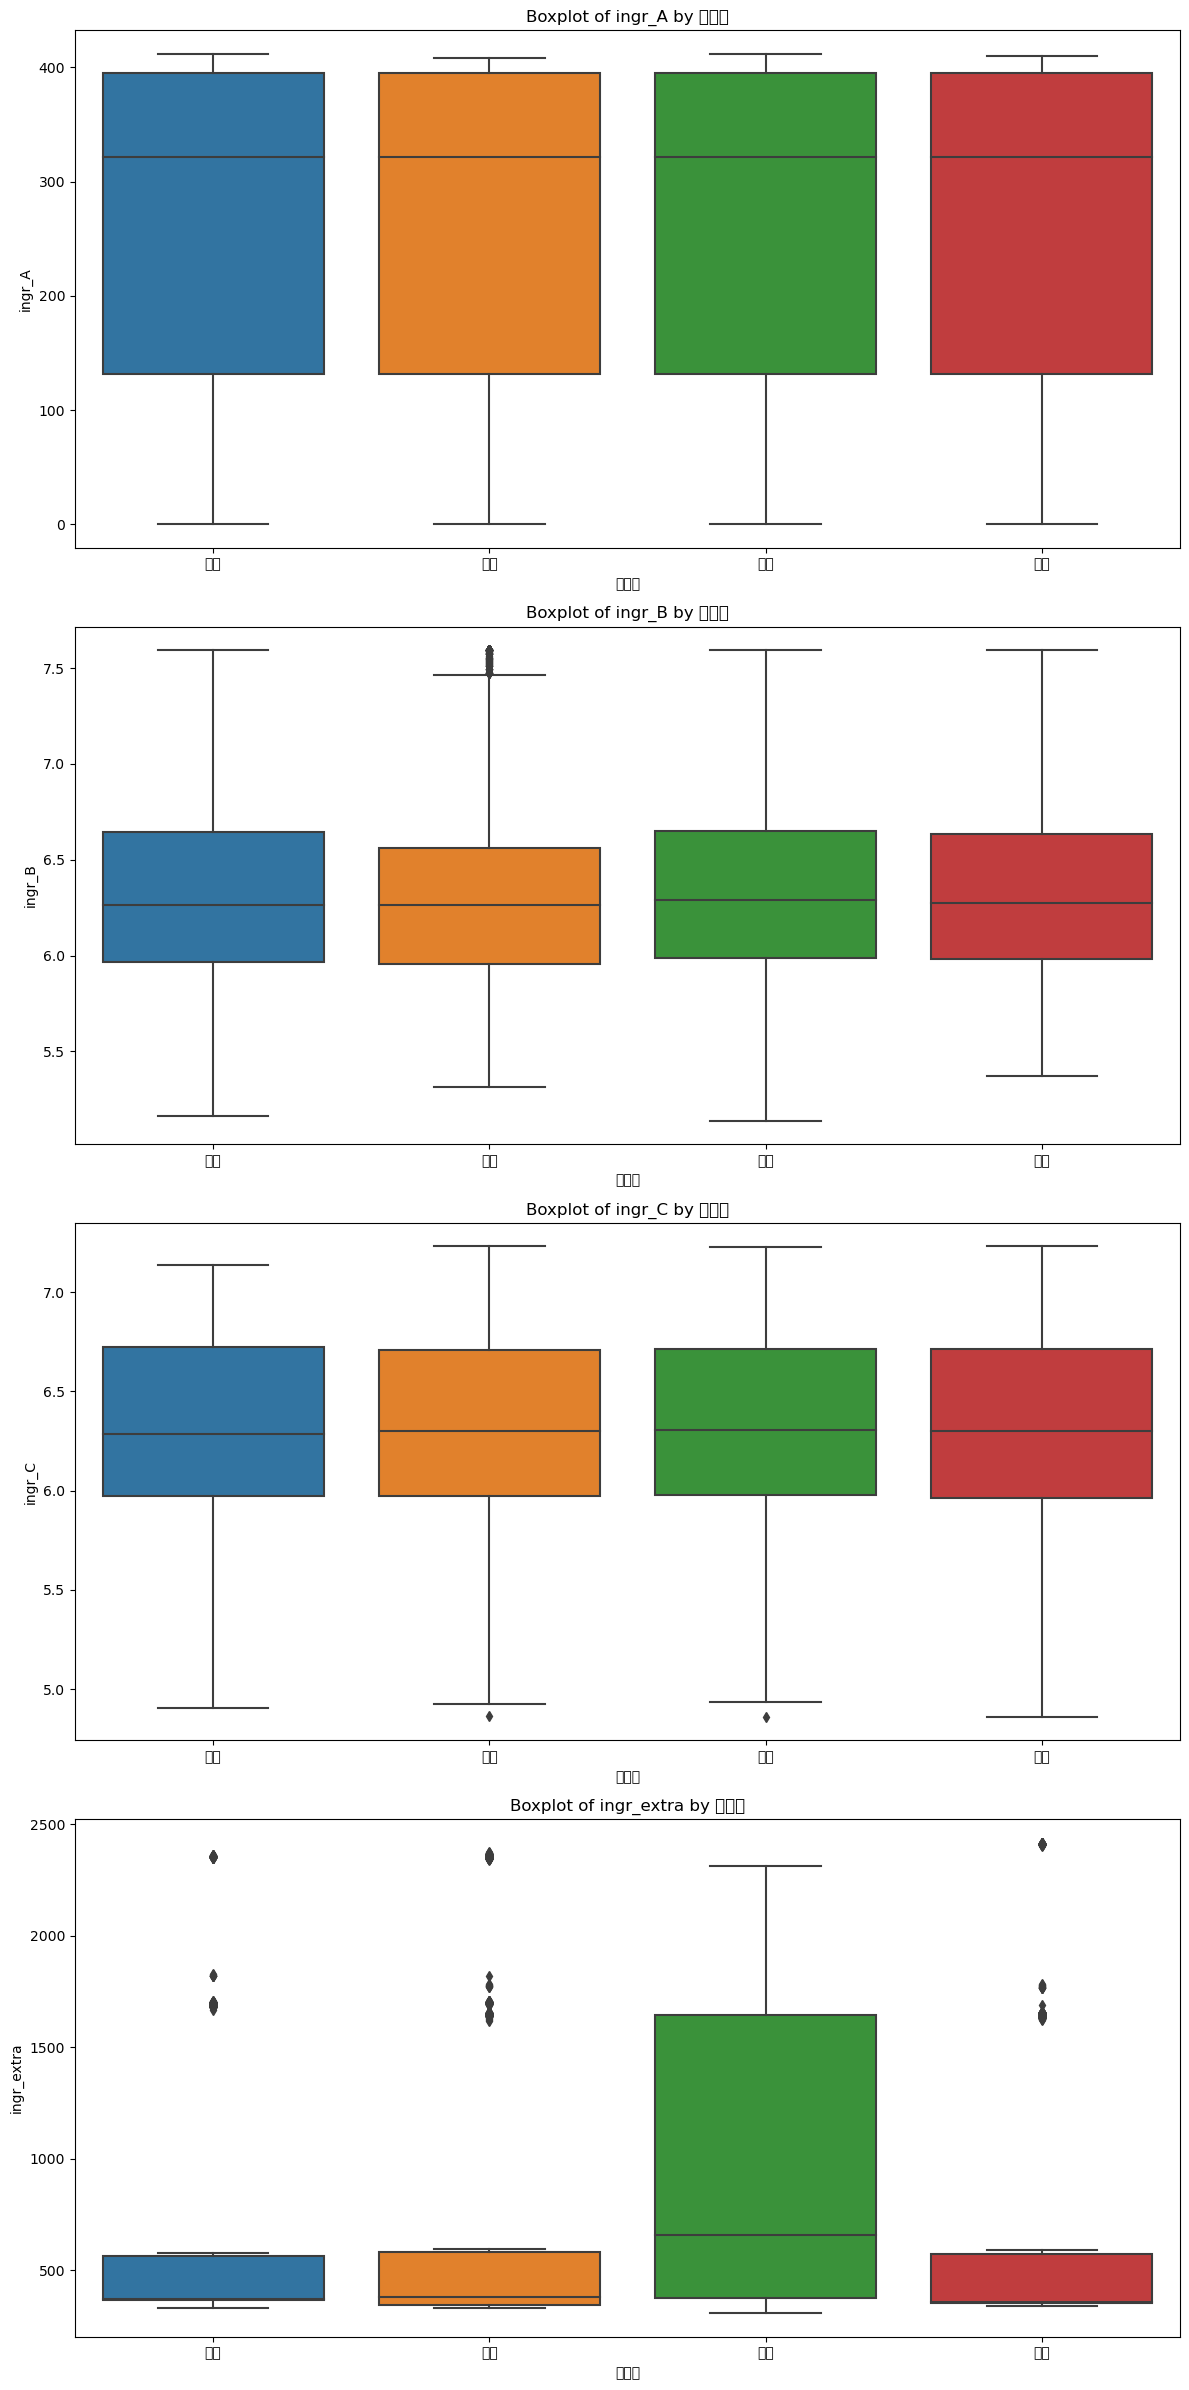

In [ ]:
fig, axes = plt.subplots(4, 1, figsize=(12, 24))

# ingr_A의 Boxplot
sns.boxplot(x='생산지', y='ingr_A', data=df_eda, ax=axes[0])
axes[0].set_title('Boxplot of ingr_A by 생산지')

# ingr_B의 Boxplot
sns.boxplot(x='생산지', y='ingr_B', data=df_eda, ax=axes[1])
axes[1].set_title('Boxplot of ingr_B by 생산지')

# ingr_C의 Boxplot
sns.boxplot(x='생산지', y='ingr_C', data=df_eda, ax=axes[2])
axes[2].set_title('Boxplot of ingr_C by 생산지')

# ingr_extra의 Boxplot
sns.boxplot(x='생산지', y='ingr_extra', data=df_eda, ax=axes[3])
axes[3].set_title('Boxplot of ingr_extra by 생산지')

plt.tight_layout()

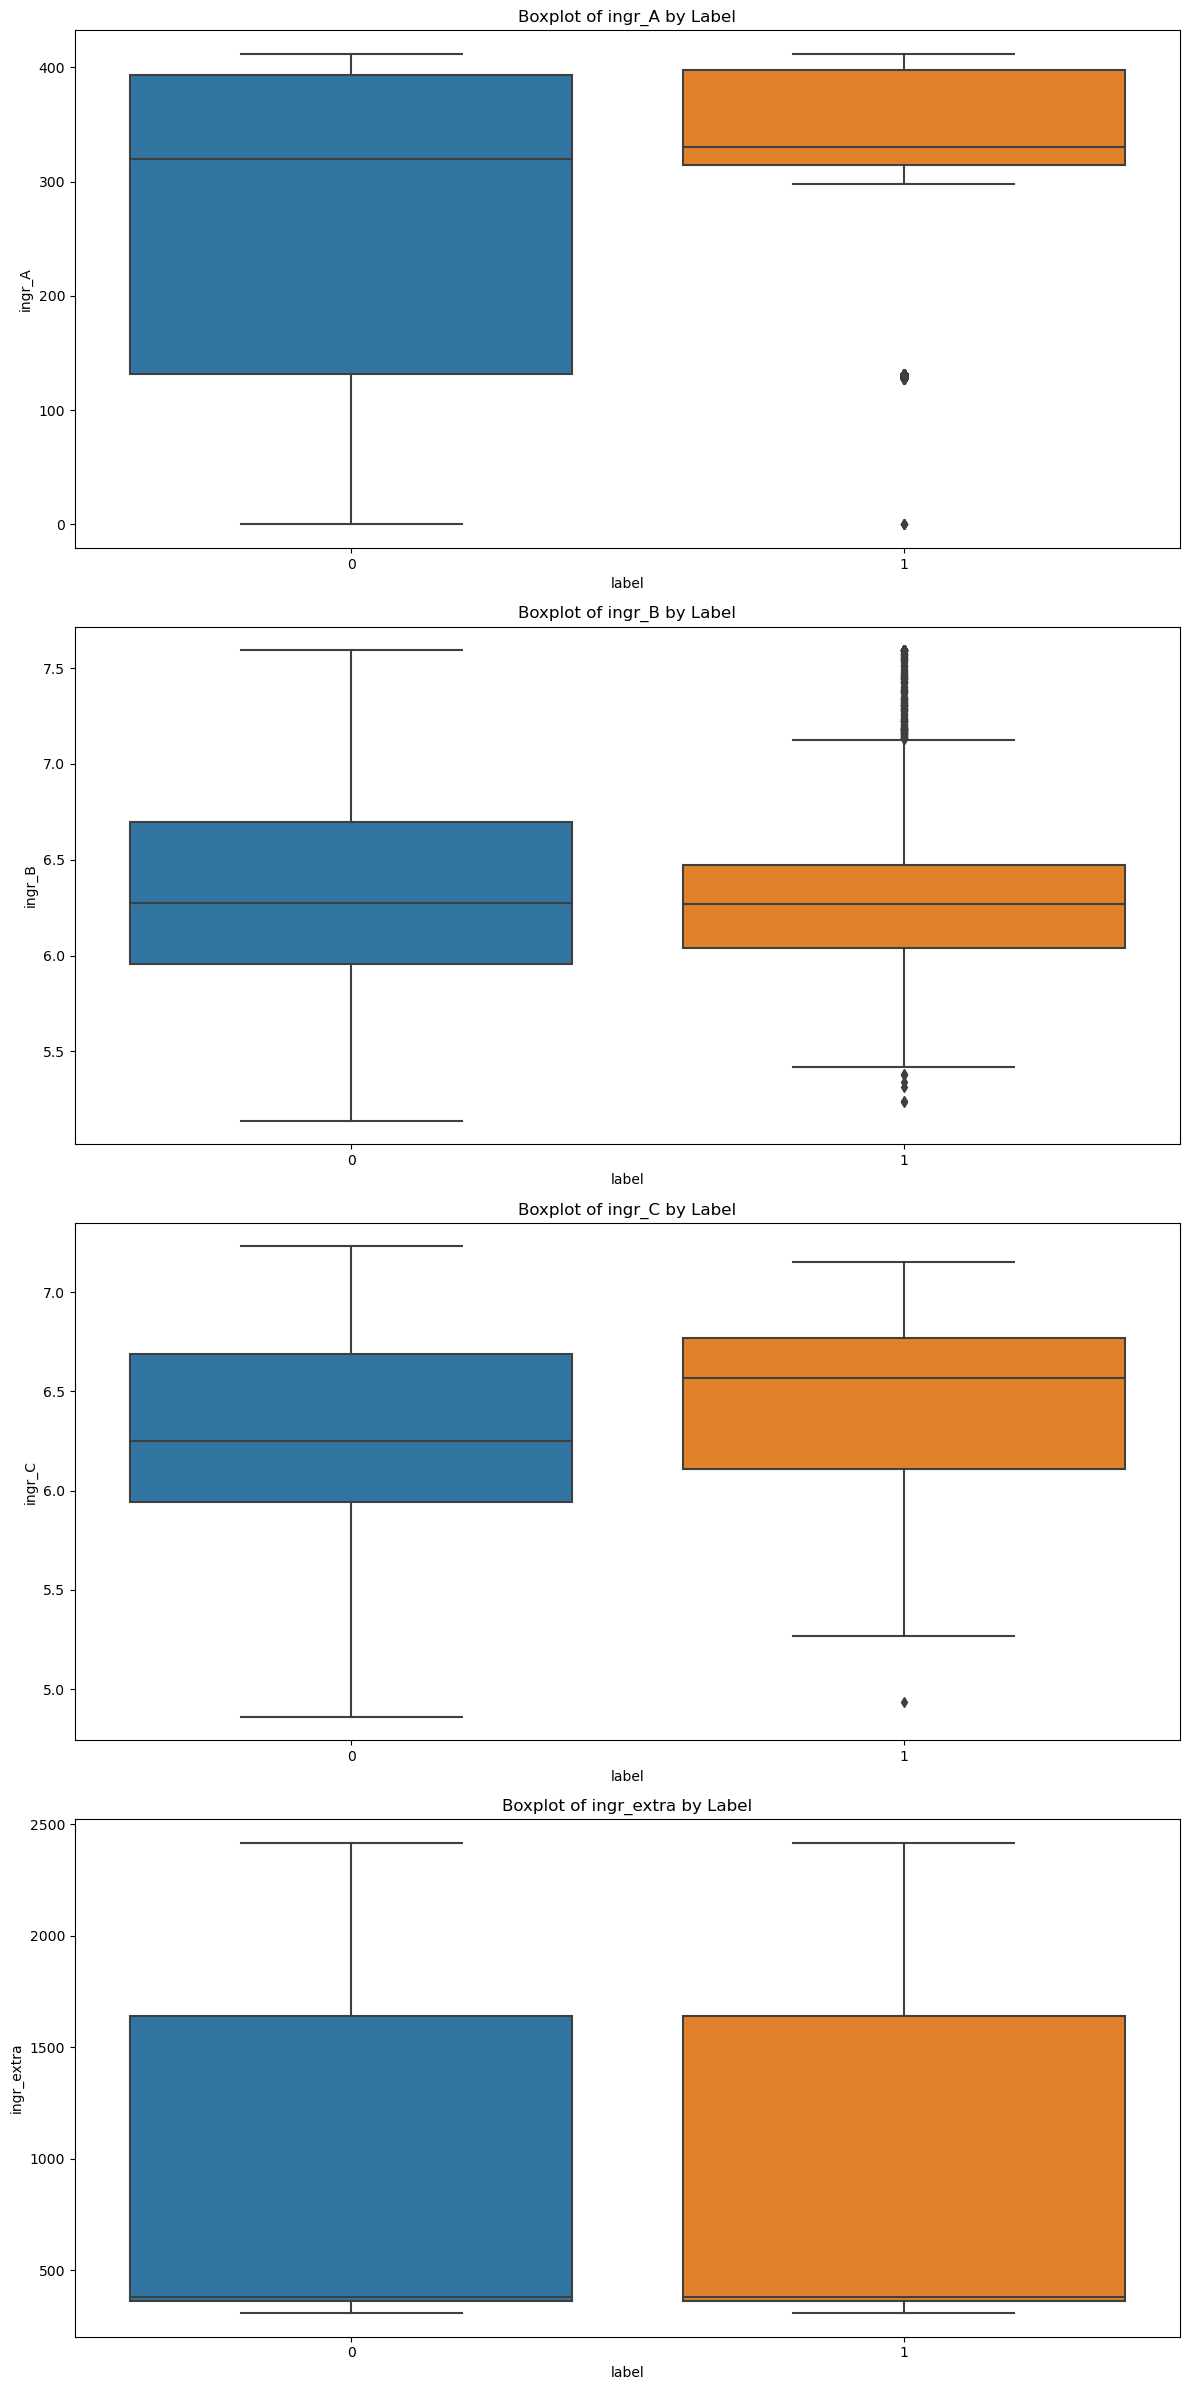

In [ ]:
fig, axes = plt.subplots(4, 1, figsize=(12, 24))

# ingr_A의 Boxplot
sns.boxplot(x='label', y='ingr_A', data=df_eda, ax=axes[0])
axes[0].set_title('Boxplot of ingr_A by Label')

# ingr_B의 Boxplot
sns.boxplot(x='label', y='ingr_B', data=df_eda, ax=axes[1])
axes[1].set_title('Boxplot of ingr_B by Label')

# ingr_C의 Boxplot
sns.boxplot(x='label', y='ingr_C', data=df_eda, ax=axes[2])
axes[2].set_title('Boxplot of ingr_C by Label')

# ingr_extra의 Boxplot
sns.boxplot(x='label', y='ingr_extra', data=df_eda, ax=axes[3])
axes[3].set_title('Boxplot of ingr_extra by Label')

plt.tight_layout()


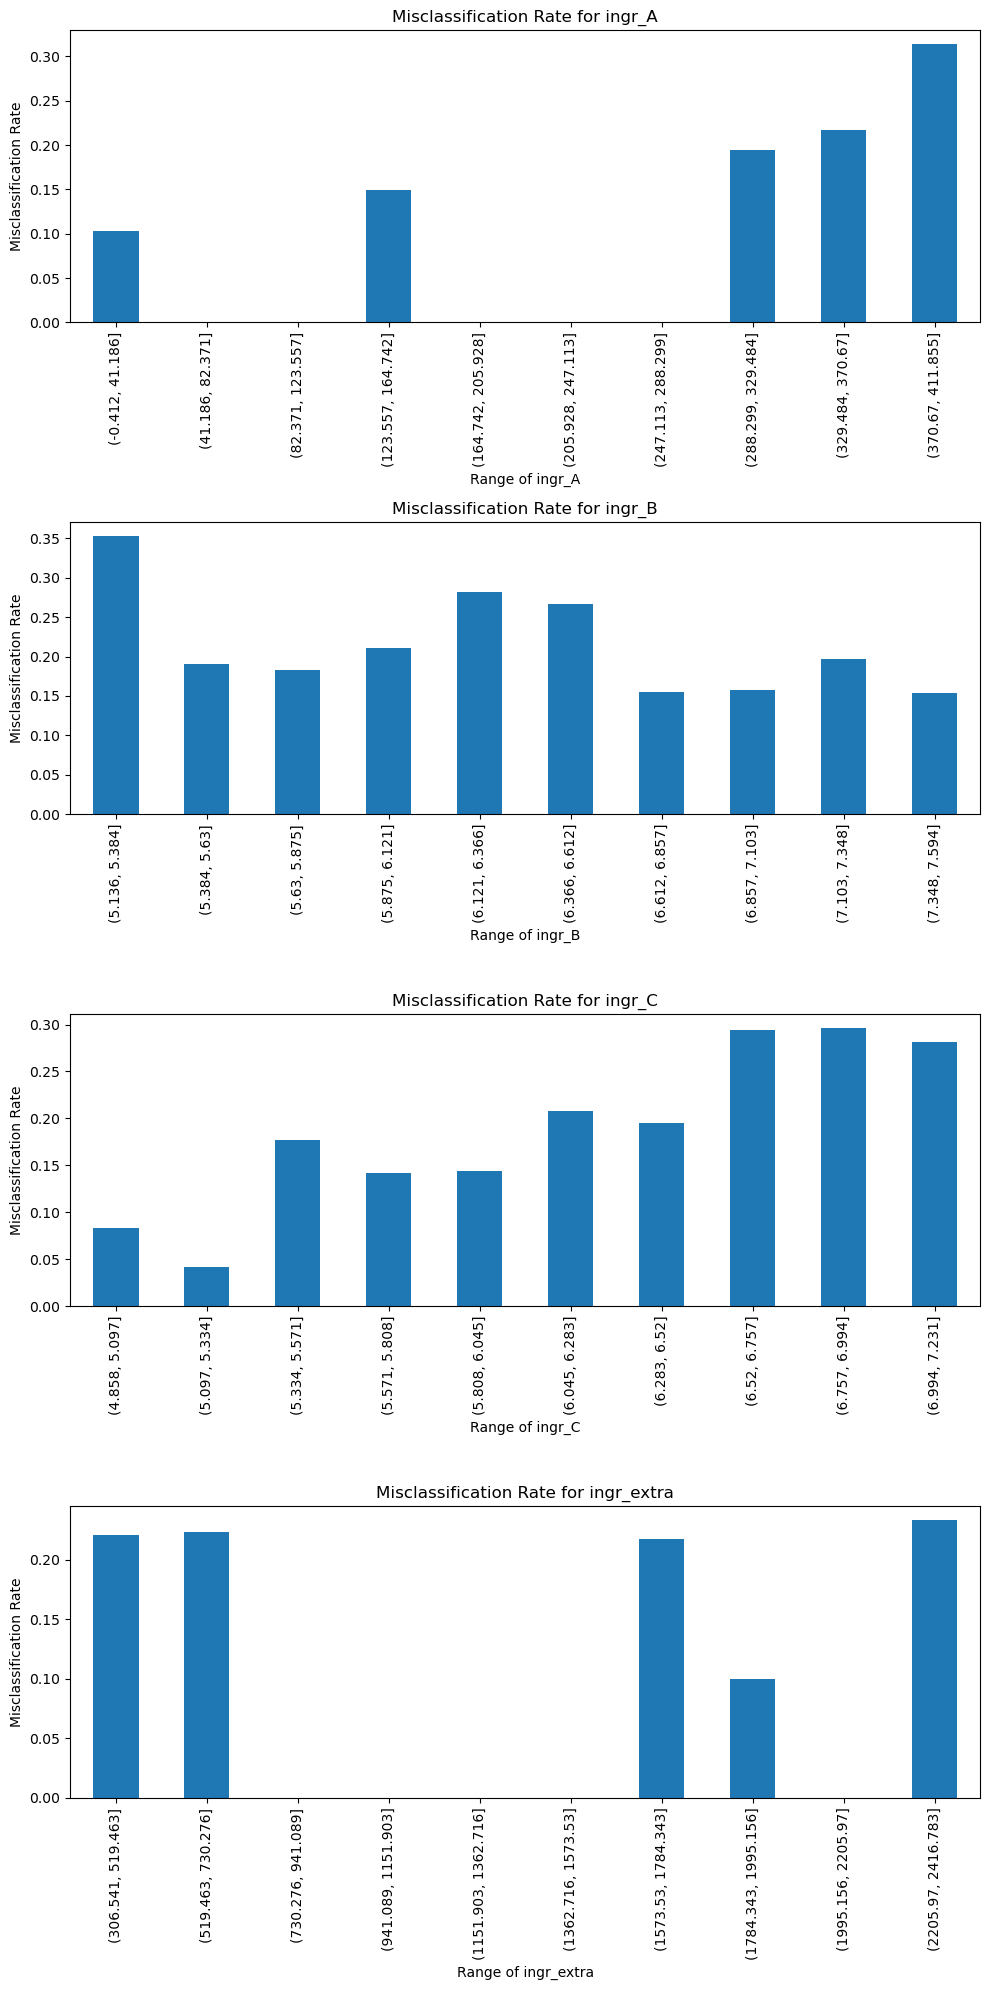

In [ ]:
# ingr_A, B, C, extra에 대한 오분류율 계산 및 시각화
ingr_columns = ['ingr_A', 'ingr_B', 'ingr_C', 'ingr_extra']
fig, axes = plt.subplots(len(ingr_columns), 1, figsize=(10, 20))

for i, column in enumerate(ingr_columns):
    # 적당한 bin으로 나누고 오분류율 계산
    df['bin'] = pd.cut(df_eda[column], bins=10)
    misclass_rate = df[df['label'] == 1].groupby('bin').size() / df.groupby('bin').size()
    misclass_rate.plot(kind='bar', ax=axes[i])
    axes[i].set_title(f'Misclassification Rate for {column}')
    axes[i].set_xlabel(f'Range of {column}')
    axes[i].set_ylabel('Misclassification Rate')

plt.tight_layout()
plt.show()


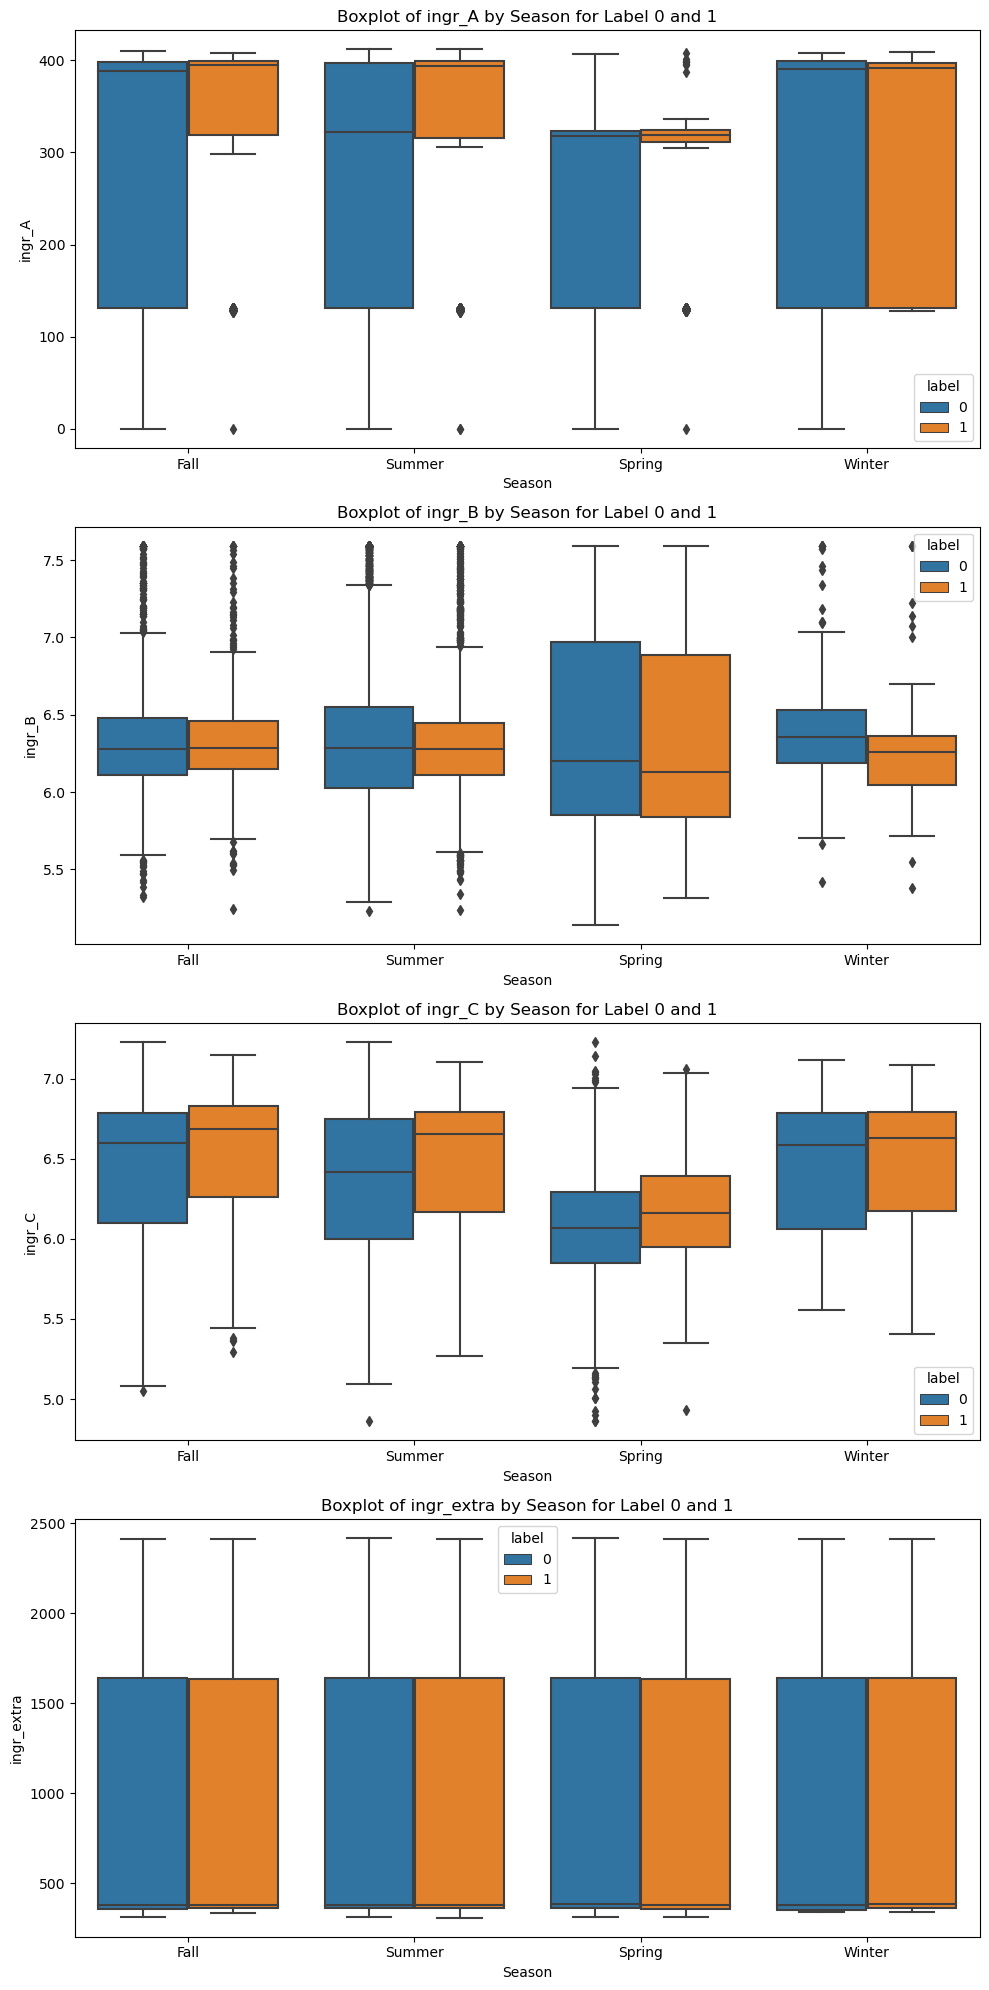

In [ ]:
# ingr_A, ingr_B, ingr_C, ingr_extra 각각에 대해 label이 0과 1인 경우의 boxplot
ingr_columns = ['ingr_A', 'ingr_B', 'ingr_C', 'ingr_extra']
fig, axes = plt.subplots(len(ingr_columns), 1, figsize=(10, 20))

for i, column in enumerate(ingr_columns):
    # 각 계절마다 해당 성분의 함량에 대한 boxplot (label이 0과 1인 경우 각각)
    sns.boxplot(x='buydate_season', y=column, hue='label', data=df_eda, ax=axes[i])
    axes[i].set_title(f'Boxplot of {column} by Season for Label 0 and 1')
    axes[i].set_xlabel('Season')
    axes[i].set_ylabel(column)

plt.tight_layout()
plt.show()


# EDA : wtcd

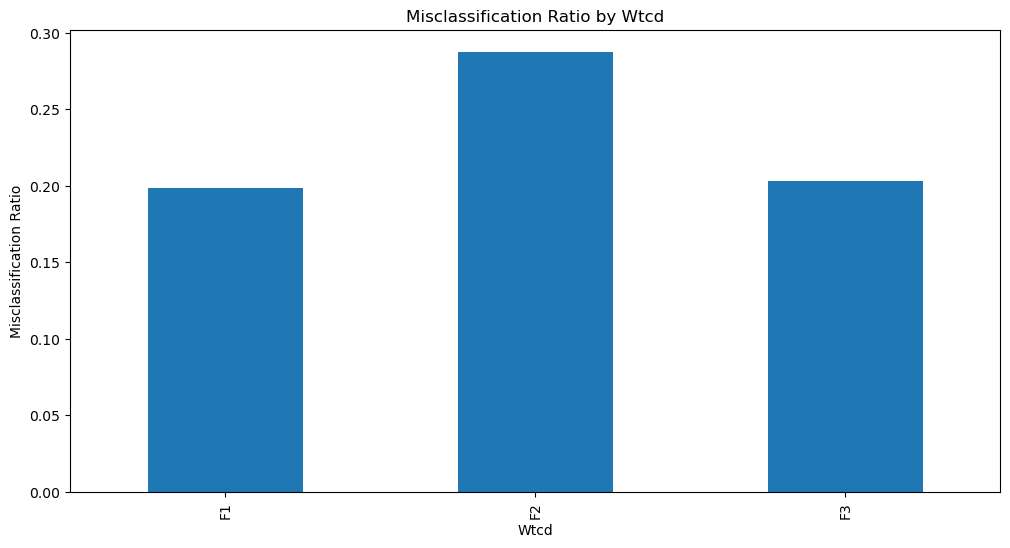

In [ ]:
# wtcd 별 label 오분류율 계산
label_misclass_by_wtcd = df_eda[df_eda['label'] == 1].groupby('wtcd').size() / df_eda.groupby('wtcd').size()

# 시각화
plt.figure(figsize=(12, 6))
label_misclass_by_wtcd.plot(kind='bar')
plt.title('Misclassification Ratio by Wtcd')
plt.ylabel('Misclassification Ratio')
plt.xlabel('Wtcd')
plt.show()


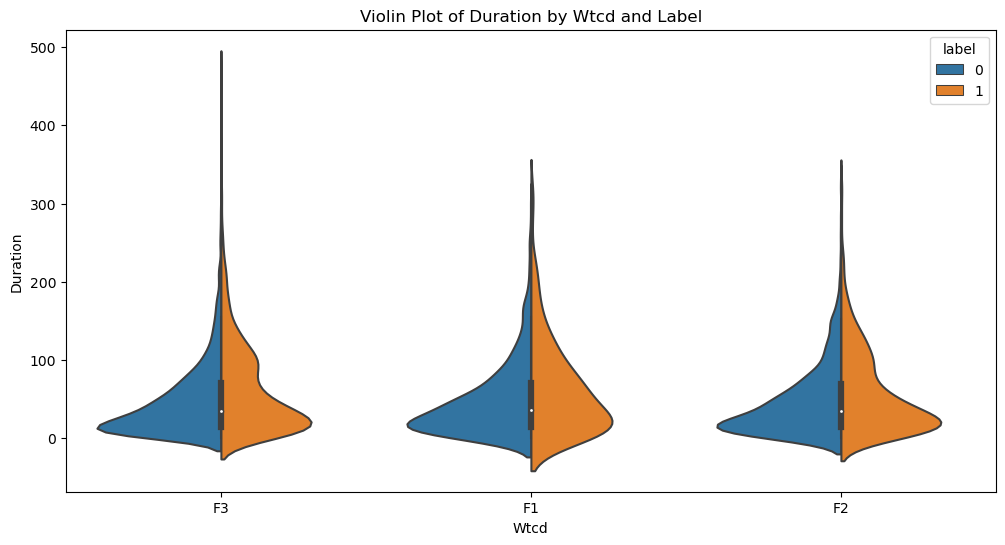

In [ ]:

# 시각화를 위한 설정
plt.figure(figsize=(12, 6))

# x축을 wtcd로, y축을 duration으로 하여 label 별로 violin plot 그리기
sns.violinplot(x='wtcd', y='duration', hue='label', data=df_eda, split=True)

# 그래프 제목 및 축 라벨 설정
plt.title('Violin Plot of Duration by Wtcd and Label')
plt.xlabel('Wtcd')
plt.ylabel('Duration')

# 그래프 표시
plt.show()


# EDA : gram

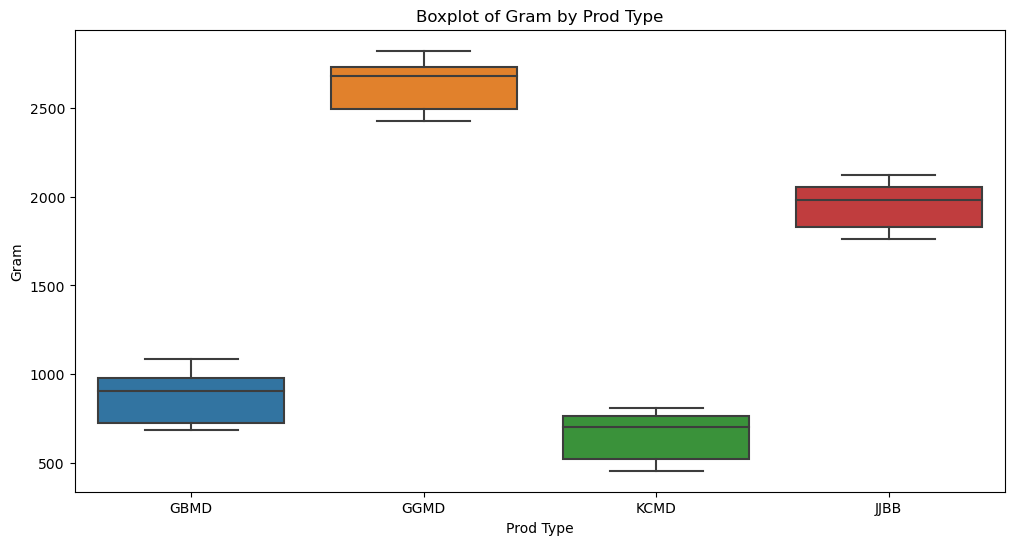

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='prod', y='gram', data=df_eda)
plt.title('Boxplot of Gram by Prod Type')
plt.xlabel('Prod Type')
plt.ylabel('Gram')
plt.show()

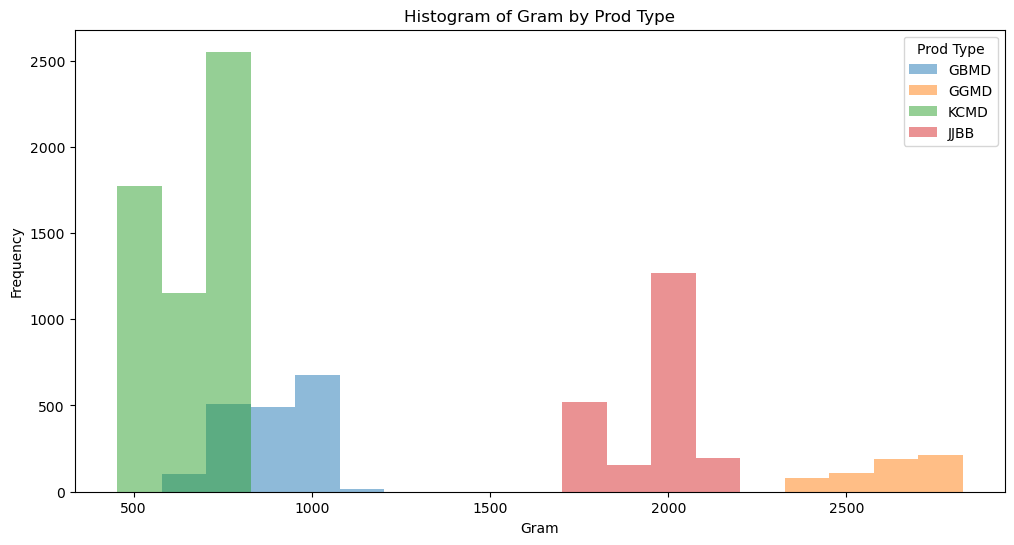

In [ ]:
# 'gram'을 기준으로 데이터를 나누기 위한 구간(bin) 설정
bins = np.linspace(df_eda['gram'].min(), df_eda['gram'].max(), num=20)

# 'prod' 유형별로 히스토그램 그리기
plt.figure(figsize=(12, 6))
for prod_type in df_eda['prod'].unique():
    subset = df_eda[df_eda['prod'] == prod_type]
    plt.hist(subset['gram'], bins=bins, alpha=0.5, label=str(prod_type))

plt.title('Histogram of Gram by Prod Type')
plt.xlabel('Gram')
plt.ylabel('Frequency')
plt.legend(title='Prod Type')
plt.show()


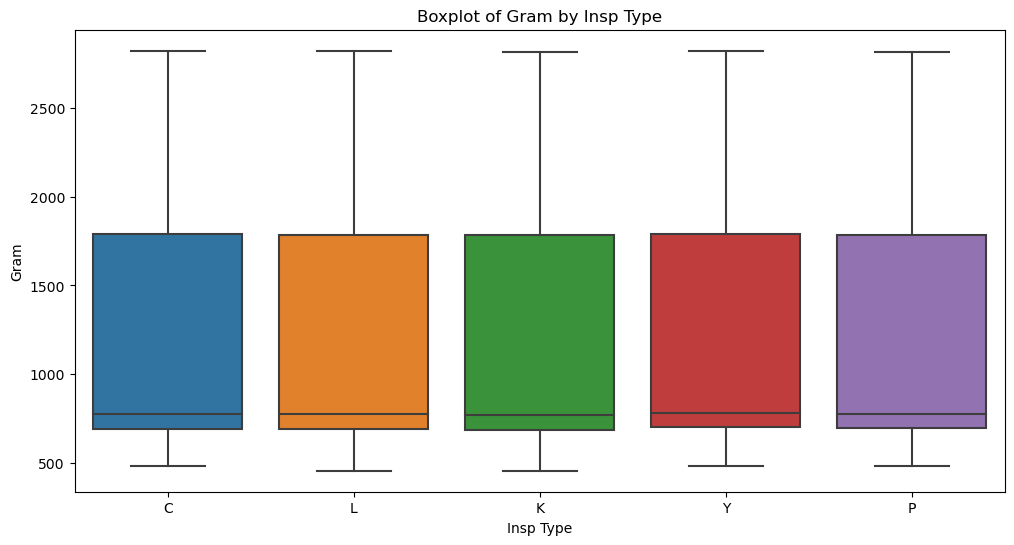

In [ ]:
# 2. Insp 종류에 따라 gram의 boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(x='insp', y='gram', data=df_eda)
plt.title('Boxplot of Gram by Insp Type')
plt.xlabel('Insp Type')
plt.ylabel('Gram')
plt.show()


/home/ryoonki/anaconda3/envs/ryoonki/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 49328 (\N{HANGUL SYLLABLE SAN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/ryoonki/anaconda3/envs/ryoonki/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 52380 (\N{HANGUL SYLLABLE CEON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/ryoonki/anaconda3/envs/ryoonki/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 52285 (\N{HANGUL SYLLABLE CANG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/ryoonki/anaconda3/envs/ryoonki/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 54616 (\N{HANGUL SYLLABLE HA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/ryoonki/anaconda3/envs/ryoonki/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 49688 (\N{HANGU

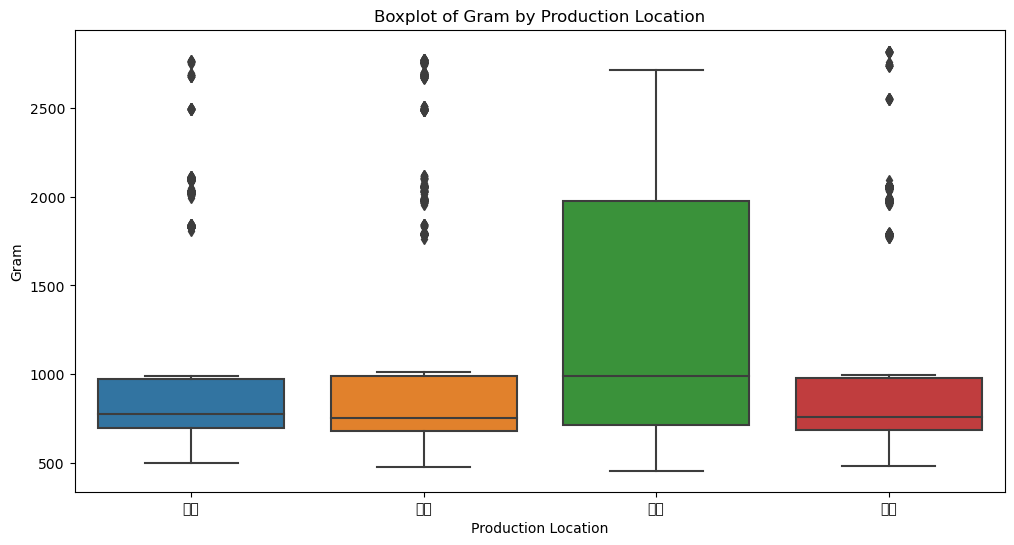

In [ ]:
# 4. 생산지 별로 gram의 boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(x='생산지', y='gram', data=df_eda)
plt.title('Boxplot of Gram by Production Location')
plt.xlabel('Production Location')
plt.ylabel('Gram')
plt.show()

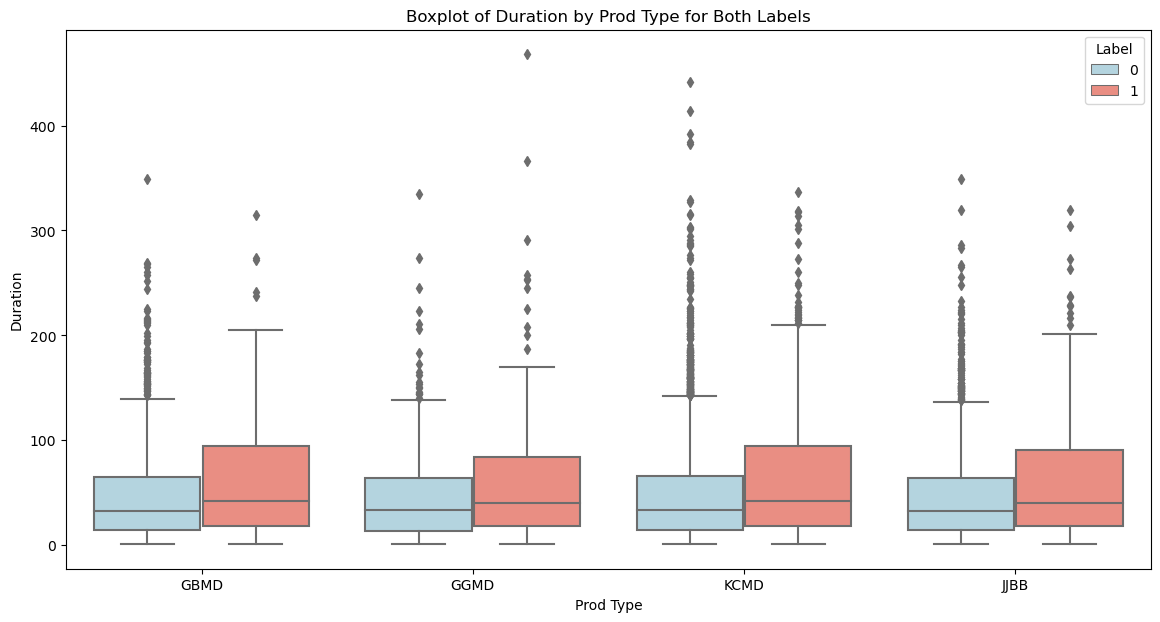

In [ ]:

plt.figure(figsize=(14, 7))
sns.boxplot(x='prod', y='duration', hue='label', data=df_eda, palette=['lightblue', 'salmon'])
plt.title('Boxplot of Duration by Prod Type for Both Labels')
plt.xlabel('Prod Type')
plt.ylabel('Duration')
plt.legend(title='Label')
plt.show()


# EDA : 생산지

/home/ryoonki/anaconda3/envs/ryoonki/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 49328 (\N{HANGUL SYLLABLE SAN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/ryoonki/anaconda3/envs/ryoonki/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 52380 (\N{HANGUL SYLLABLE CEON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/ryoonki/anaconda3/envs/ryoonki/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/ryoonki/anaconda3/envs/ryoonki/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 49457 (\N{HANGUL SYLLABLE SEONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/ryoonki/anaconda3/envs/ryoonki/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 50724 (\N{HANG

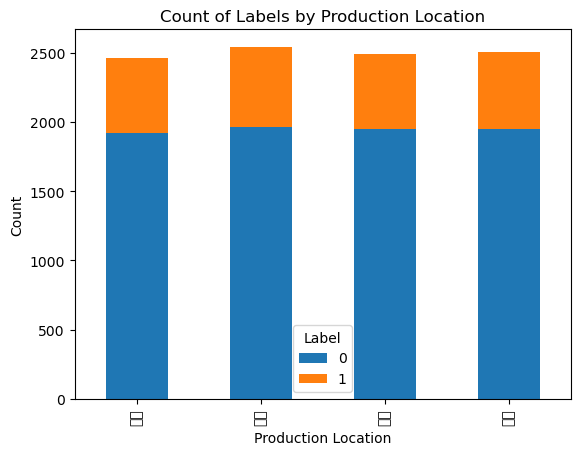

In [ ]:

production_label_counts = df_eda.groupby(['생산지', 'label']).size().unstack(fill_value=0)

# Plot the count of labels by production location
production_label_counts.plot(kind='bar', stacked=True)
plt.title('Count of Labels by Production Location')
plt.xlabel('Production Location')
plt.ylabel('Count')
plt.legend(title='Label')
plt.show()


# EDA : A/B/C/extra_P

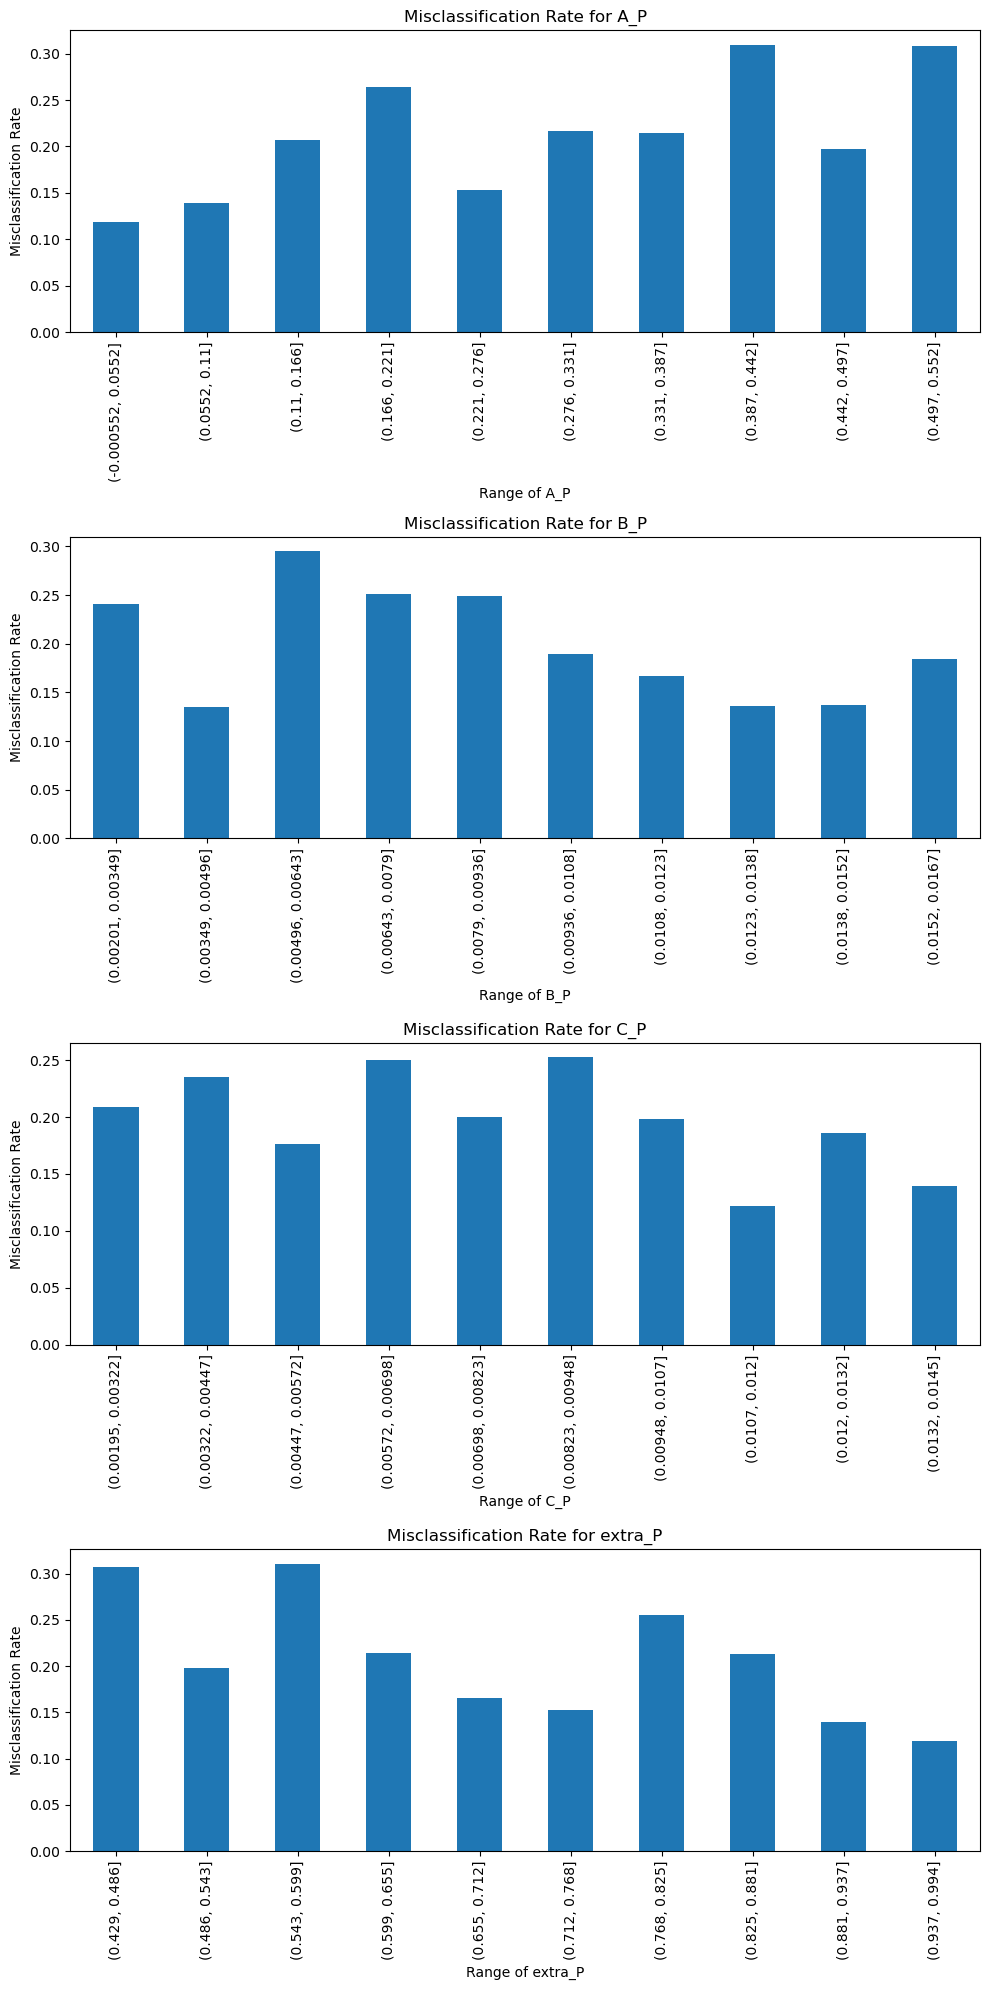

In [ ]:
# ingr_A, B, C, extra에 대한 오분류율 계산 및 시각화
ingr_columns = ['A_P', 'B_P', 'C_P', 'extra_P']
fig, axes = plt.subplots(len(ingr_columns), 1, figsize=(10, 20))

for i, column in enumerate(ingr_columns):
    # 적당한 bin으로 나누고 오분류율 계산
    df_eda['bin'] = pd.cut(df_eda[column], bins=10)
    misclass_rate = df_eda[df_eda['label'] == 1].groupby('bin').size() / df_eda.groupby('bin').size()
    misclass_rate.plot(kind='bar', ax=axes[i])
    axes[i].set_title(f'Misclassification Rate for {column}')
    axes[i].set_xlabel(f'Range of {column}')
    axes[i].set_ylabel('Misclassification Rate')

plt.tight_layout()
plt.show()


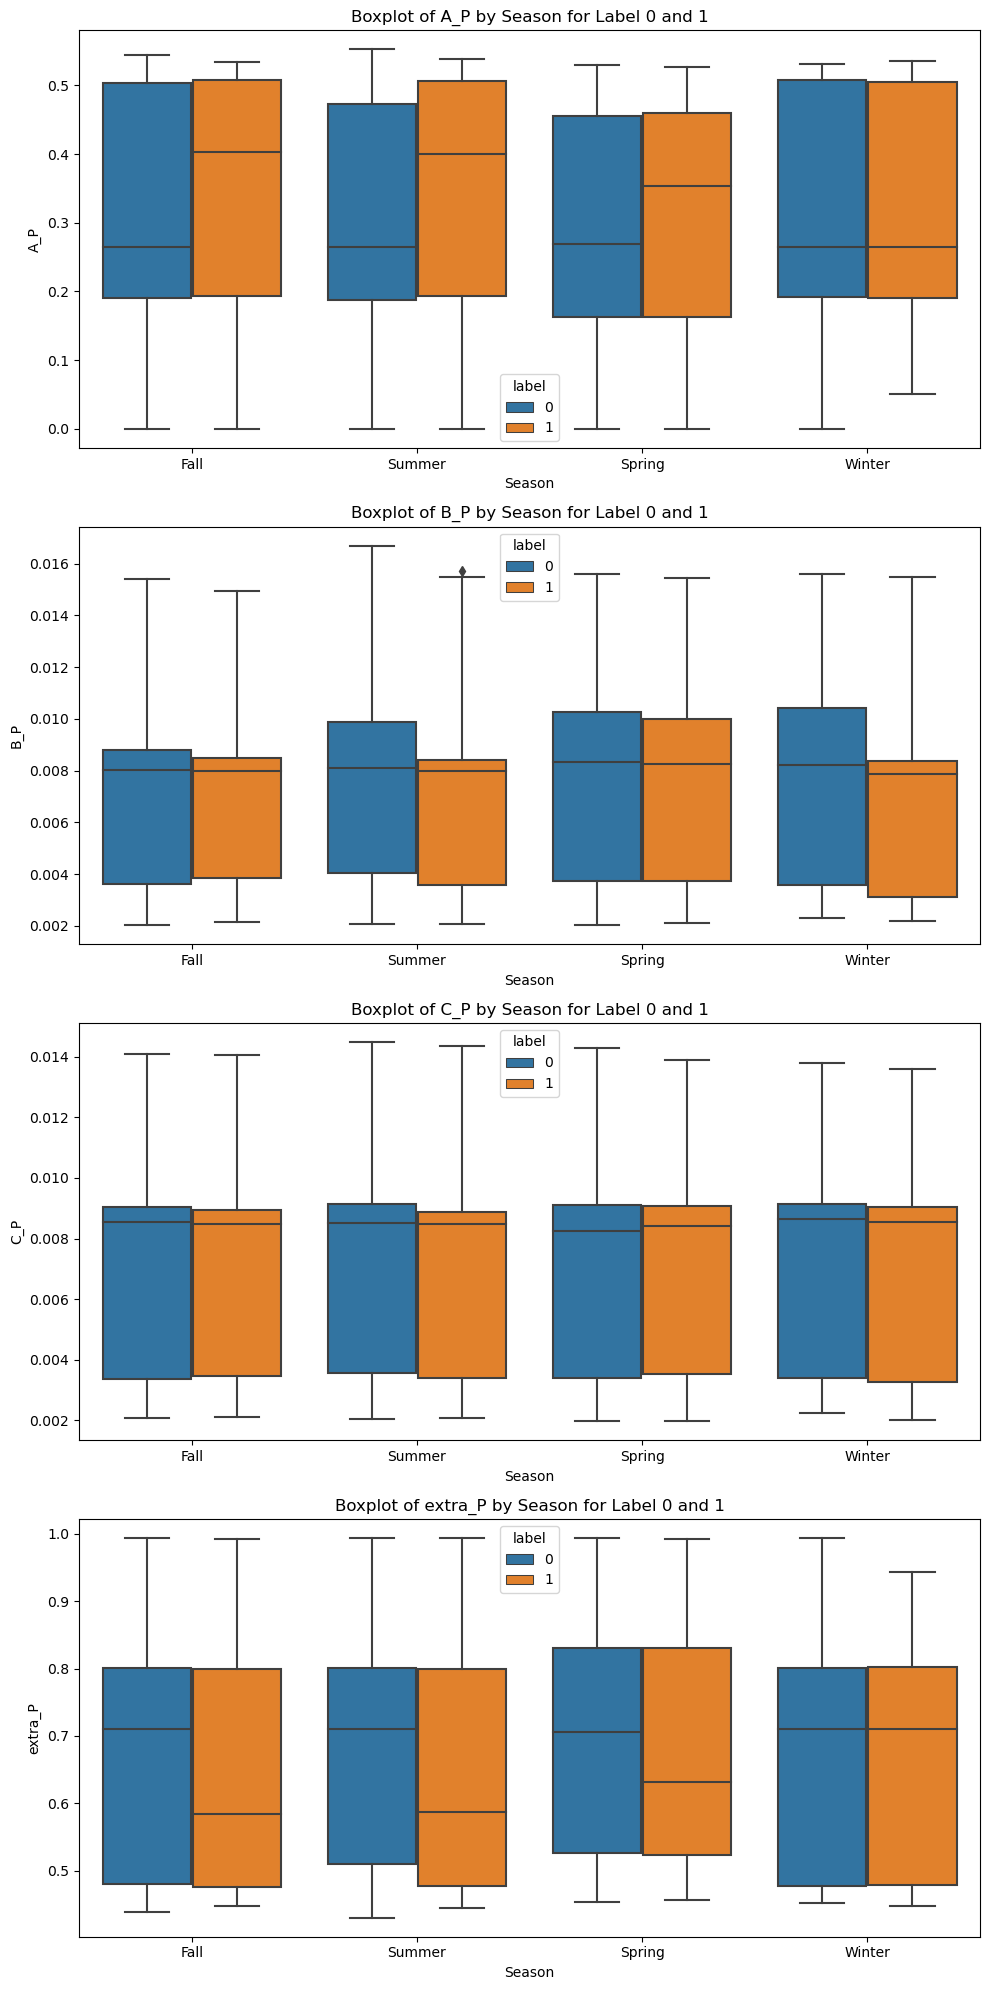

In [ ]:
# A/B/C/extra_P 각각에 대해 label이 0과 1인 경우의 boxplot
ingr_columns = ['A_P', 'B_P', 'C_P', 'extra_P']
fig, axes = plt.subplots(len(ingr_columns), 1, figsize=(10, 20))

for i, column in enumerate(ingr_columns):
    # 각 계절마다 해당 성분의 함량에 대한 boxplot (label이 0과 1인 경우 각각)
    sns.boxplot(x='buydate_season', y=column, hue='label', data=df_eda, ax=axes[i])
    axes[i].set_title(f'Boxplot of {column} by Season for Label 0 and 1')
    axes[i].set_xlabel('Season')
    axes[i].set_ylabel(column)

plt.tight_layout()
plt.show()


In [ ]:
# 각 label별 평균 비율 계산
mean_ratios = df_eda.groupby('label')[['A_P', 'B_P', 'C_P', 'extra_P']].mean()

# 계산된 평균 비율을 출력
print(mean_ratios)


            A_P       B_P       C_P   extra_P
label                                        
0      0.312052  0.007724  0.007556  0.672667
1      0.342179  0.007261  0.007325  0.643234


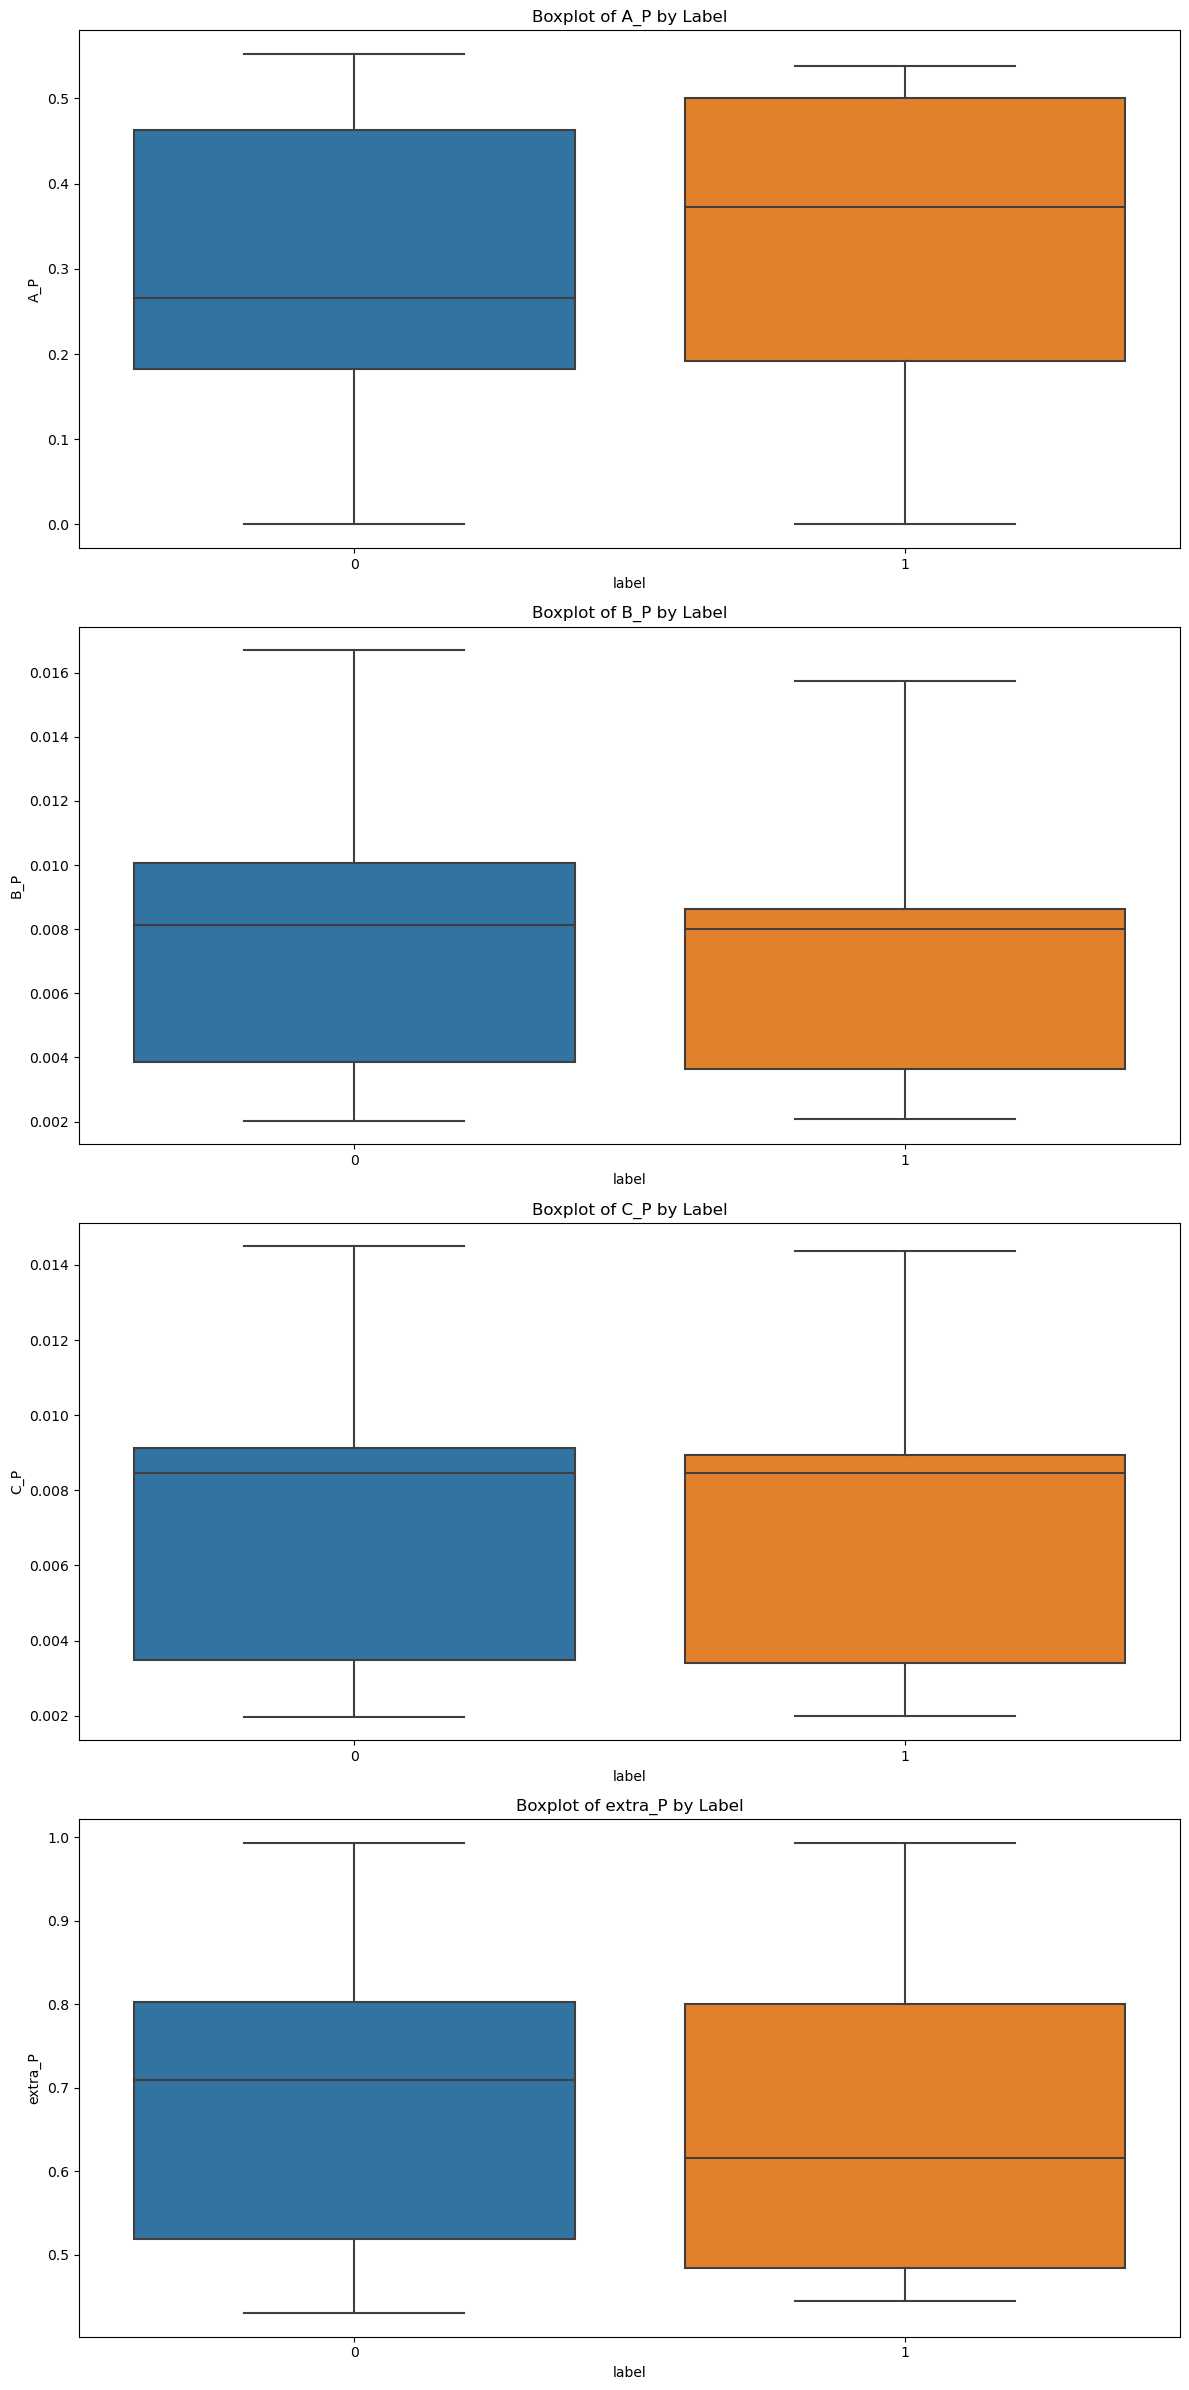

In [ ]:
fig, axes = plt.subplots(4, 1, figsize=(12, 24))

# ingr_A의 Boxplot
sns.boxplot(x='label', y='A_P', data=df_eda, ax=axes[0])
axes[0].set_title('Boxplot of A_P by Label')

# ingr_B의 Boxplot
sns.boxplot(x='label', y='B_P', data=df_eda, ax=axes[1])
axes[1].set_title('Boxplot of B_P by Label')

# ingr_C의 Boxplot
sns.boxplot(x='label', y='C_P', data=df_eda, ax=axes[2])
axes[2].set_title('Boxplot of C_P by Label')

# ingr_extra의 Boxplot
sns.boxplot(x='label', y='extra_P', data=df_eda, ax=axes[3])
axes[3].set_title('Boxplot of extra_P by Label')

plt.tight_layout()


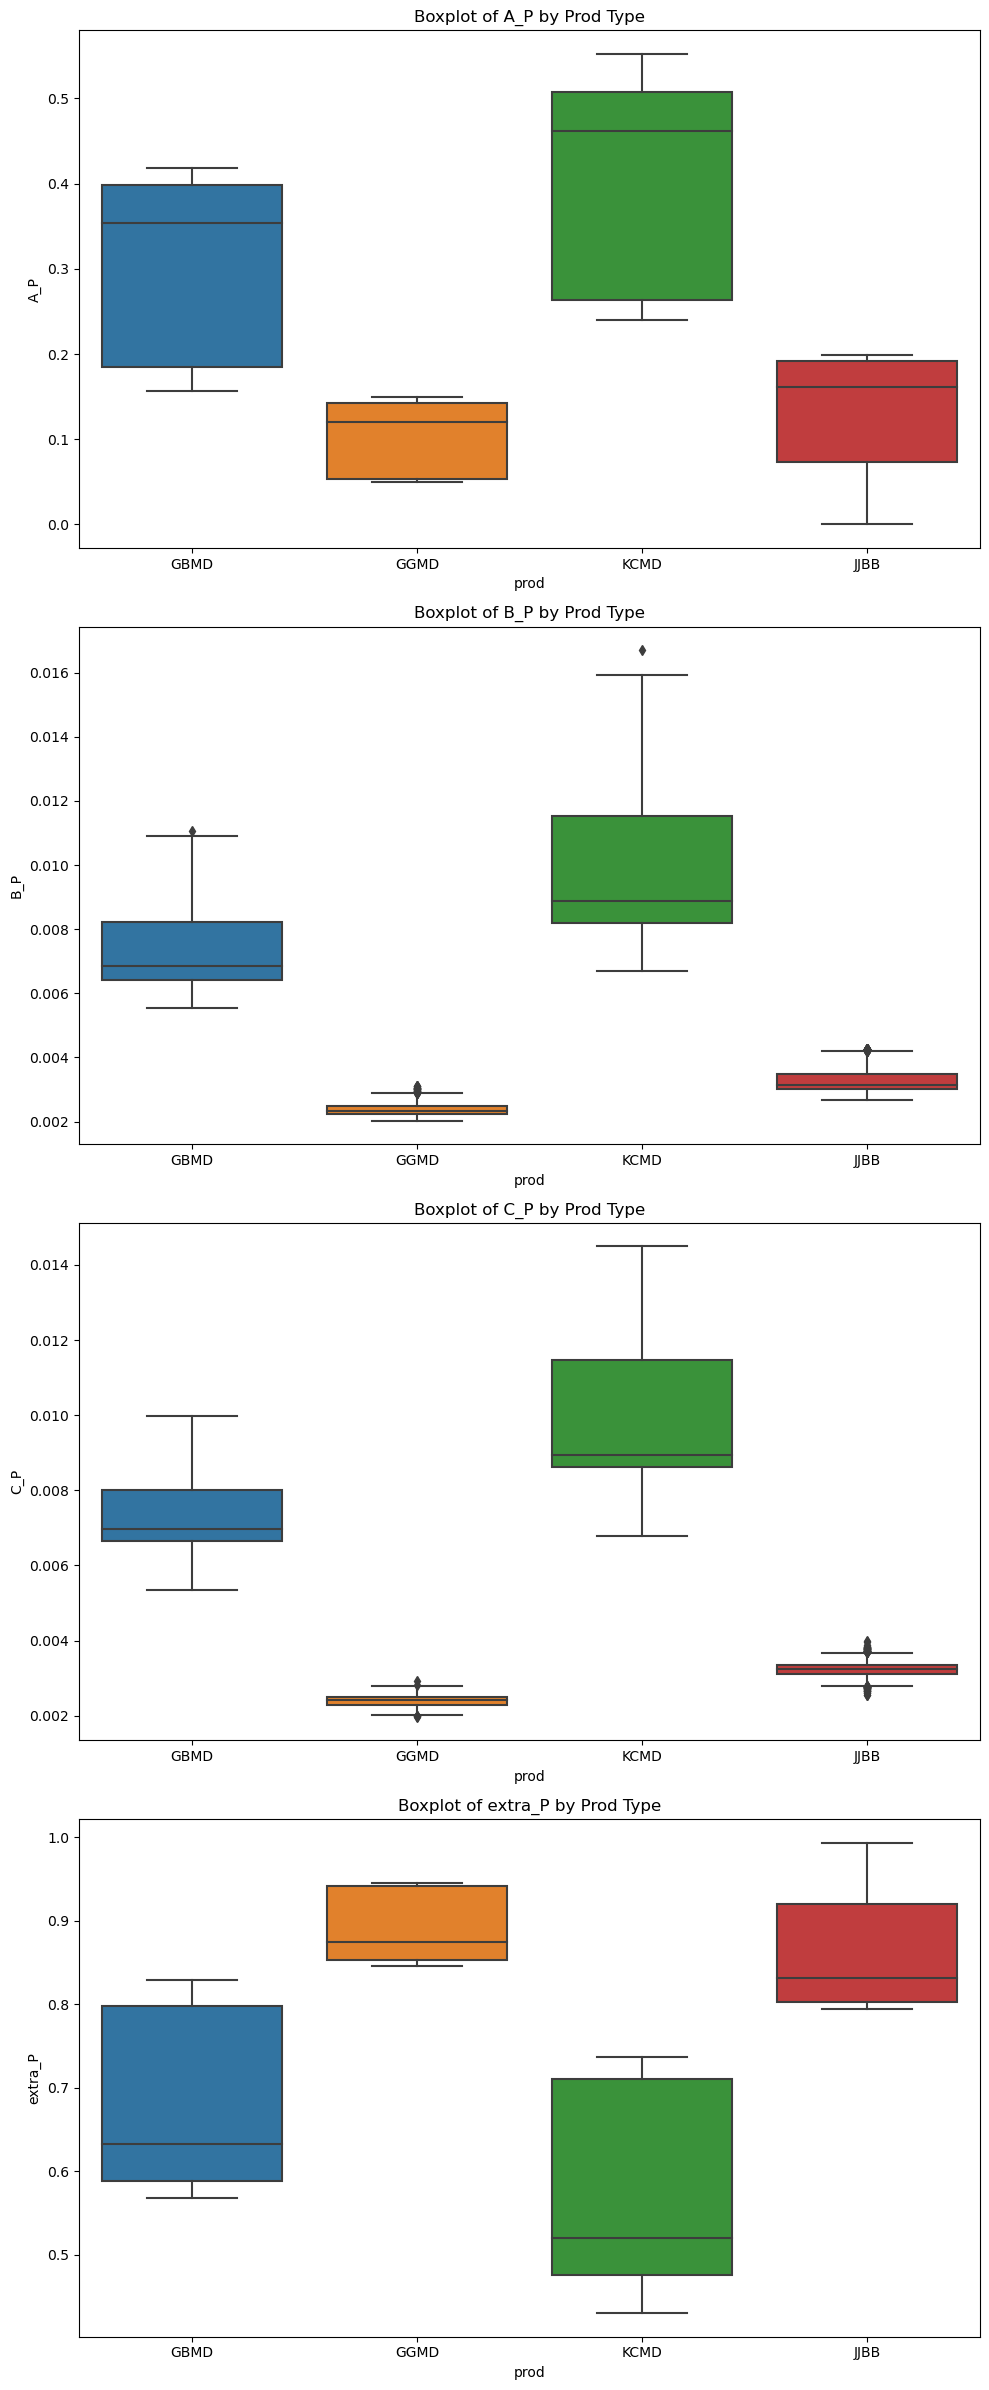

In [ ]:
ingredients = ['A_P', 'B_P', 'C_P', 'extra_P']
fig, axes = plt.subplots(len(ingredients), 1, figsize=(10, 6 * len(ingredients)))

for i, ingr in enumerate(ingredients):
    sns.boxplot(x='prod', y=ingr, data=df_eda, ax=axes[i])
    axes[i].set_title(f'Boxplot of {ingr} by Prod Type')

plt.tight_layout()
plt.show()


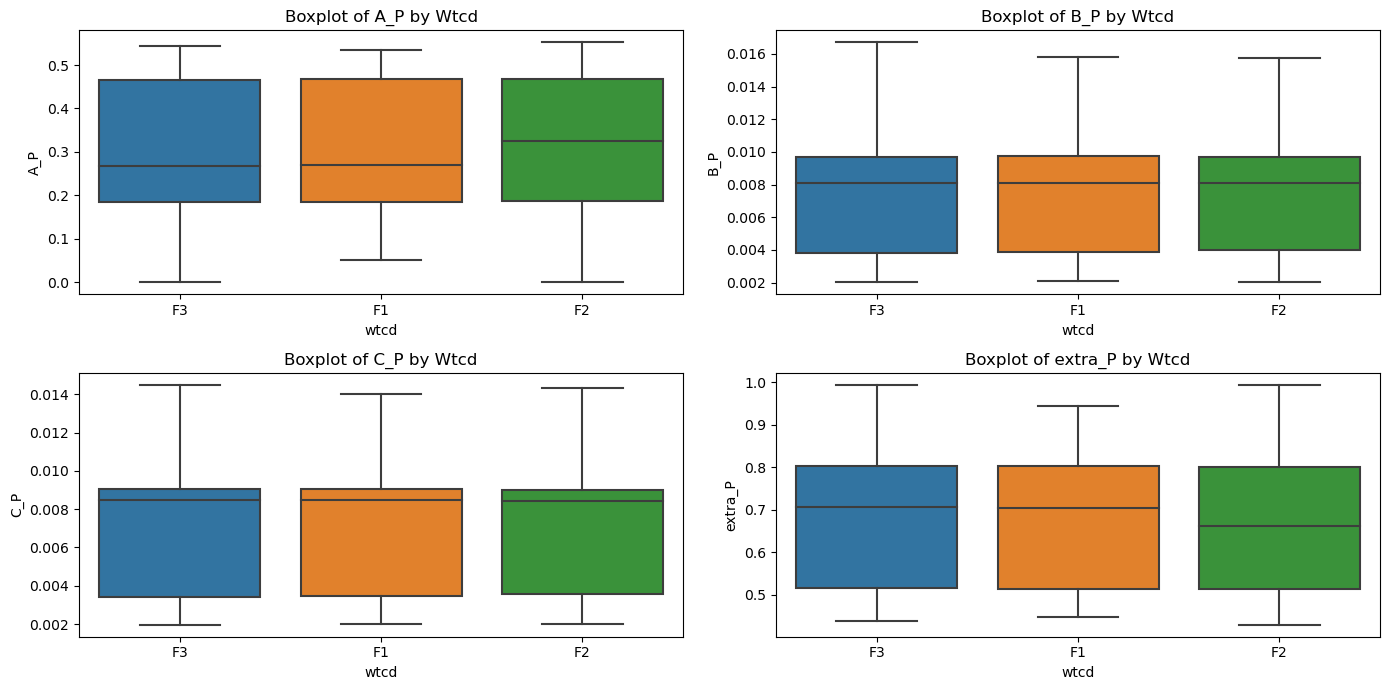

/tmp/ipykernel_3825296/188723524.py:18: UserWarning: Glyph 49328 (\N{HANGUL SYLLABLE SAN}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_3825296/188723524.py:18: UserWarning: Glyph 52380 (\N{HANGUL SYLLABLE CEON}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_3825296/188723524.py:18: UserWarning: Glyph 52285 (\N{HANGUL SYLLABLE CANG}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_3825296/188723524.py:18: UserWarning: Glyph 54616 (\N{HANGUL SYLLABLE HA}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_3825296/188723524.py:18: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_3825296/188723524.py:18: UserWarning: Glyph 49457 (\N{HANGUL SYLLABLE SEONG}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_3825296/188723524.py:18: UserWarning: Glyph 50724 (\N{HANGUL SYLLABLE O}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_3825296/1887

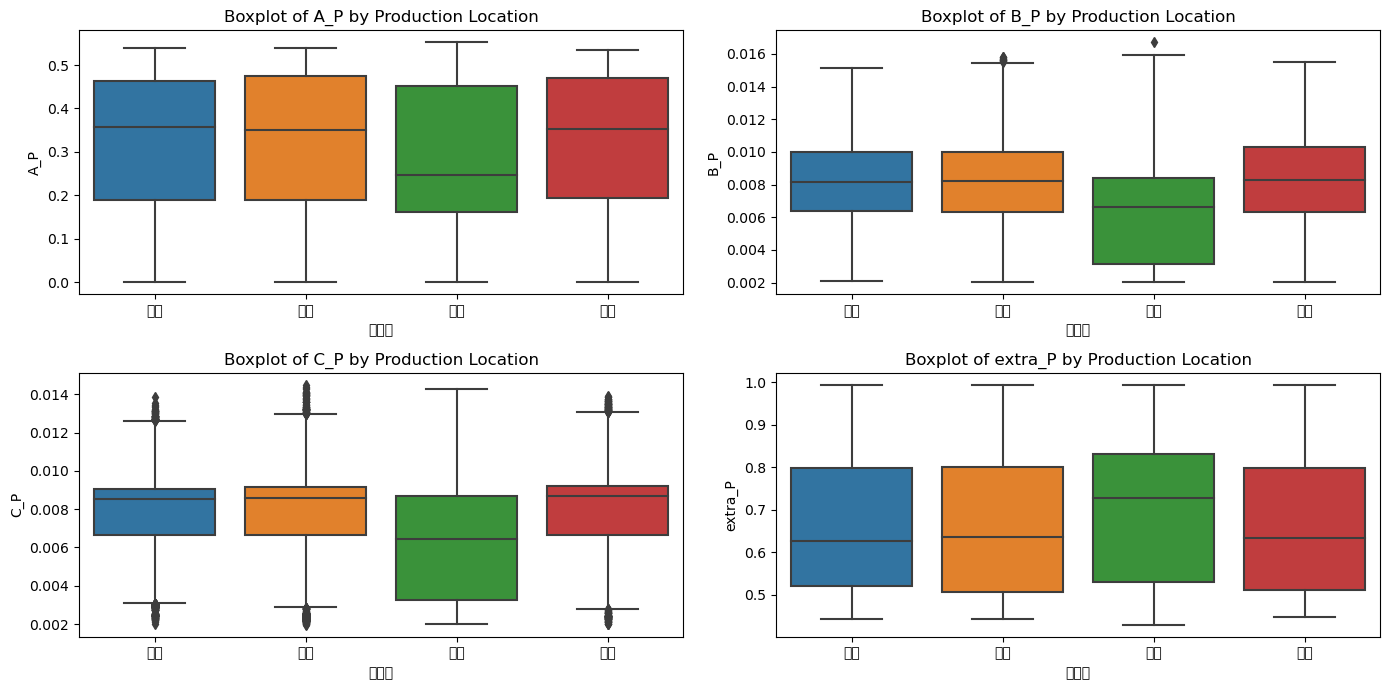

In [ ]:

ingredients = ['A_P', 'B_P', 'C_P', 'extra_P']

# Wtcd 종류에 따라 각 원료 비율의 Boxplot
plt.figure(figsize=(14, 7))
for i, ingr in enumerate(ingredients):
    plt.subplot(2, 2, i+1)
    sns.boxplot(x='wtcd', y=ingr, data=df_eda)
    plt.title(f'Boxplot of {ingr} by Wtcd')
plt.tight_layout()
plt.show()

# 생산지에 따라 각 원료 비율의 Boxplot
plt.figure(figsize=(14, 7))
for i, ingr in enumerate(ingredients):
    plt.subplot(2, 2, i+1)
    sns.boxplot(x='생산지', y=ingr, data=df_eda)
    plt.title(f'Boxplot of {ingr} by Production Location')
plt.tight_layout()
plt.show()


# EDA : duration

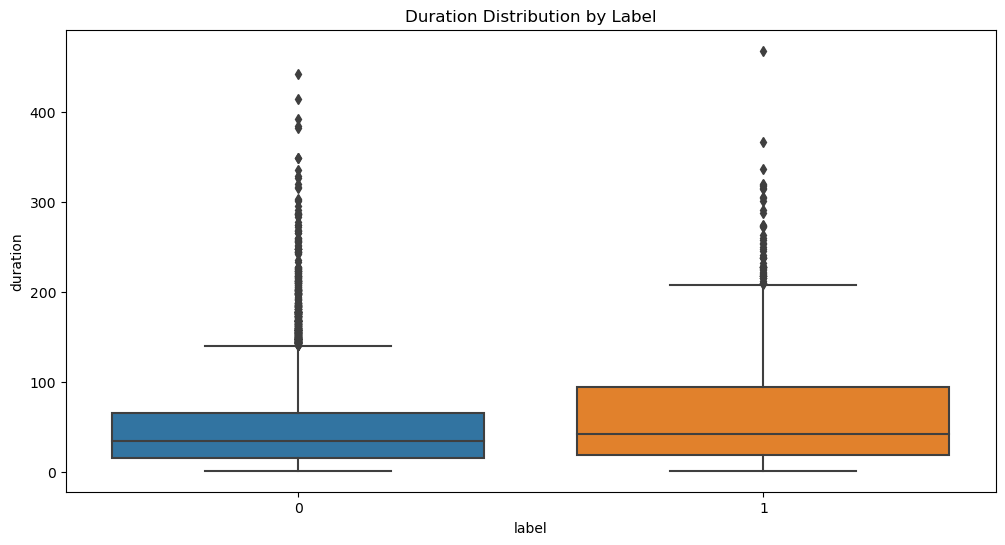

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='label', y='duration', data=df_eda)
plt.title('Duration Distribution by Label')
plt.show()

In [ ]:
from scipy.stats import pointbiserialr

# df_eda는 여러분의 데이터프레임입니다.
# df_eda = pd.read_csv('your_file.csv') 또는 다른 데이터 로딩 코드

# duration과 label 사이의 포인트-비세리얼 상관계수 계산
correlation, p_value = pointbiserialr(df_eda['label'], df_eda['duration'])

print(f"Point-Biserial Correlation between 'label' and 'duration': {correlation:.3f}")
print(f"P-value: {p_value:.3f}")


Point-Biserial Correlation between 'label' and 'duration': 0.116
P-value: 0.000


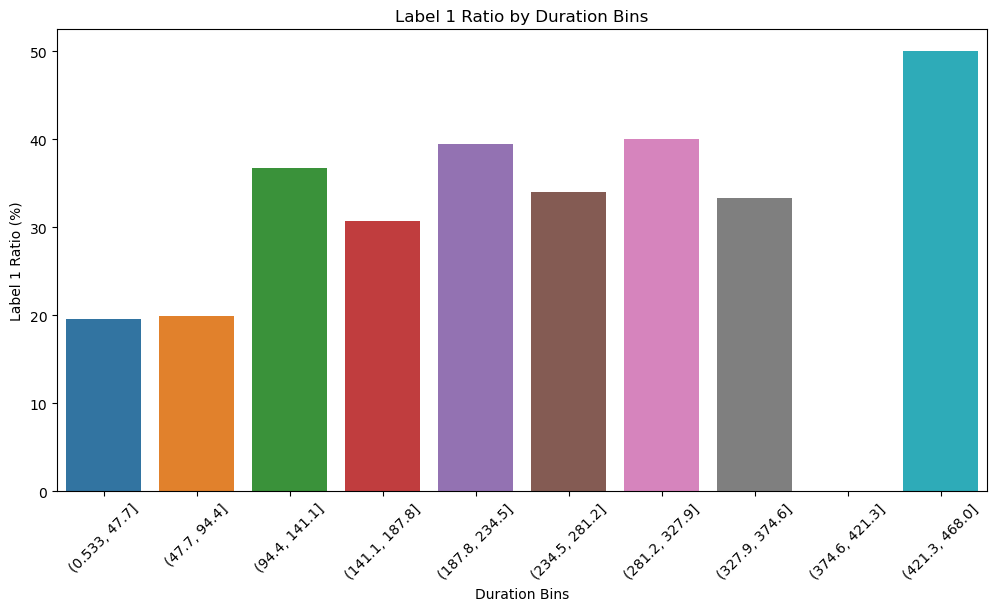

In [ ]:
# 3. duration에 따른 label의 1의 count 및 상대적인 비율
duration_bins = pd.cut(df_eda['duration'], bins=10)
duration_label_counts = df_eda.groupby(duration_bins)['label'].agg(['sum', 'count'])
duration_label_counts['ratio'] = duration_label_counts['sum'] / duration_label_counts['count'] * 100

# 4. 시각화
plt.figure(figsize=(12, 6))
sns.barplot(x=duration_label_counts.index, y='ratio', data=duration_label_counts)
plt.xticks(rotation=45)
plt.title('Label 1 Ratio by Duration Bins')
plt.xlabel('Duration Bins')
plt.ylabel('Label 1 Ratio (%)')
plt.show()

# EDA : date_month

In [ ]:
# 1. date_month에서 월 별 총 제품 count
month_counts = df_eda['date_month'].value_counts().sort_index()
month_counts

date_month
4    3327
5    3246
6    3416
Name: count, dtype: int64

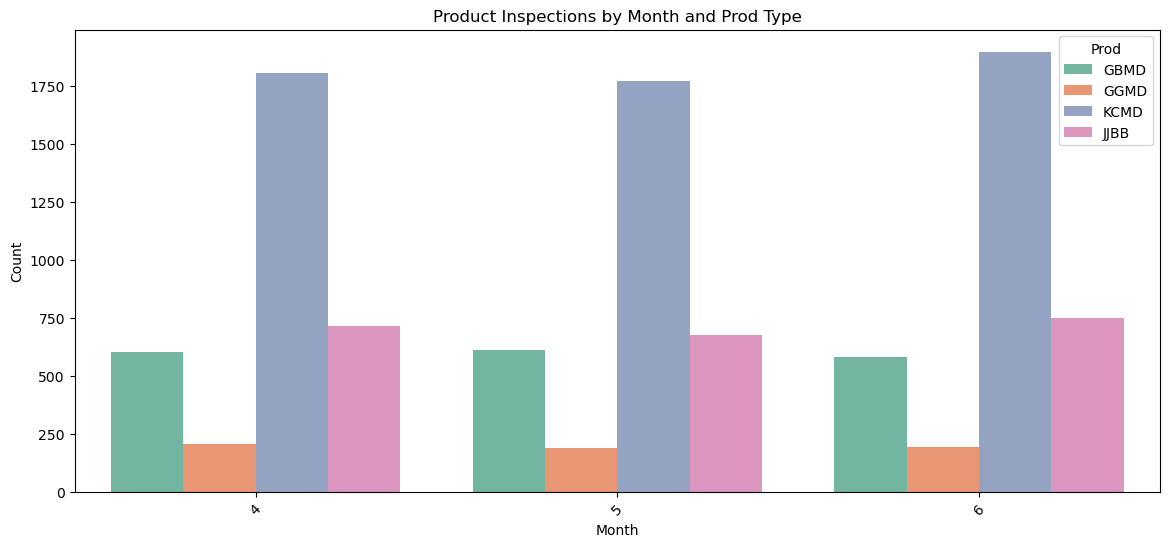

In [ ]:
plt.figure(figsize=(14, 6))
sns.countplot(x='date_month', hue='prod', data=df_eda, palette='Set2')
plt.title('Product Inspections by Month and Prod Type')
plt.xlabel('Month')
plt.ylabel('Count')
plt.legend(title='Prod')
plt.xticks(rotation=45)
plt.show()

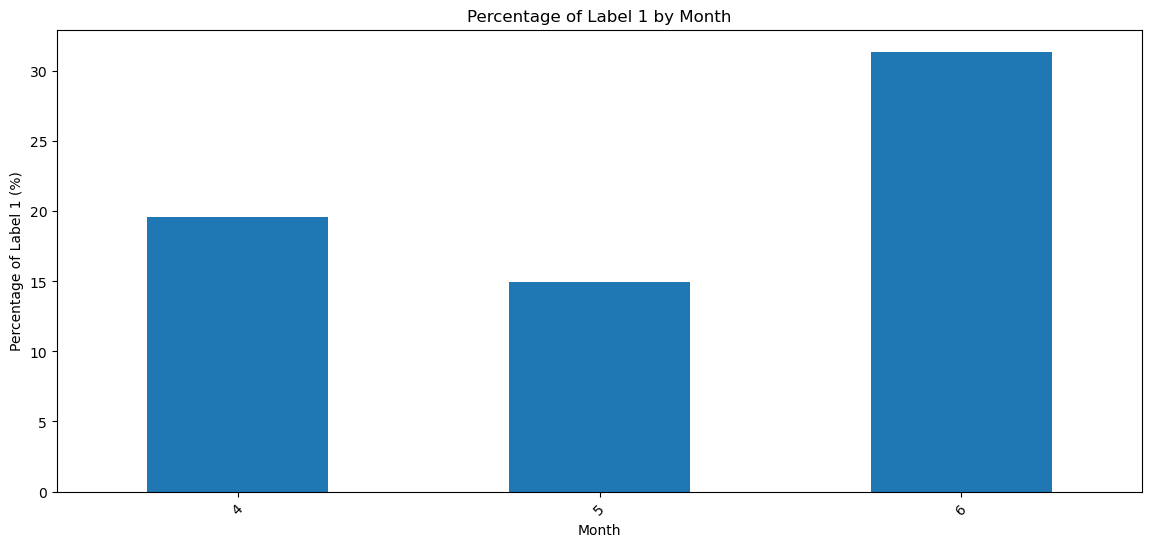

In [ ]:
label_ratio_by_month = df_eda.groupby('date_month')['label'].mean() * 100
# 시각화
plt.figure(figsize=(14, 6))
label_ratio_by_month.plot(kind='bar')
plt.title('Percentage of Label 1 by Month')
plt.xlabel('Month')
plt.ylabel('Percentage of Label 1 (%)')
plt.xticks(rotation=45)
plt.show()


# EDA : buydate_month

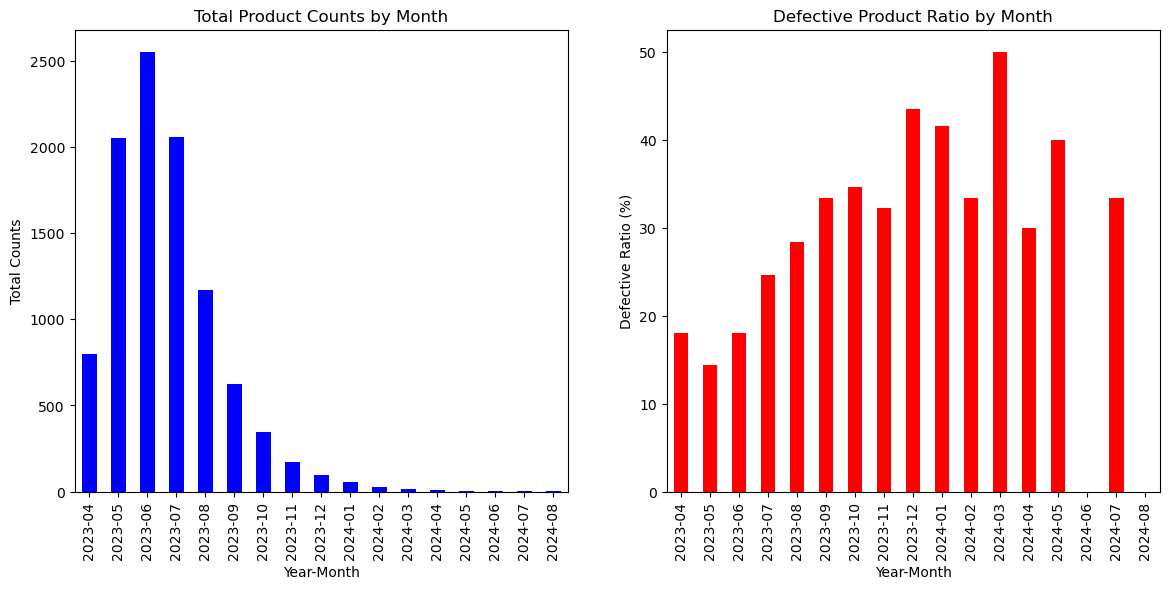

In [ ]:
df_eda['year_month'] = pd.to_datetime(df_eda['buydate']).dt.to_period('M')

# 1. 각 월 별 총 제품 개수와 불량품(label=1)의 비율 시각화
# 각 월 별 총 제품 개수 계산
total_counts_by_month = df_eda['year_month'].value_counts().sort_index()

# 각 월 별 불량품(label=1)의 개수 계산
defective_counts_by_month = df_eda[df_eda['label'] == 1]['year_month'].value_counts().sort_index()

# 불량품 비율 계산
defective_ratio_by_month = defective_counts_by_month / total_counts_by_month * 100

# 시각화
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
total_counts_by_month.plot(kind='bar', color='blue')
plt.title('Total Product Counts by Month')
plt.xlabel('Year-Month')
plt.ylabel('Total Counts')

plt.subplot(1, 2, 2)
defective_ratio_by_month.plot(kind='bar', color='red')
plt.title('Defective Product Ratio by Month')
plt.xlabel('Year-Month')
plt.ylabel('Defective Ratio (%)')
plt.show()

/tmp/ipykernel_3825296/2514255558.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['date'] = pd.to_datetime(filtered_data['date'])


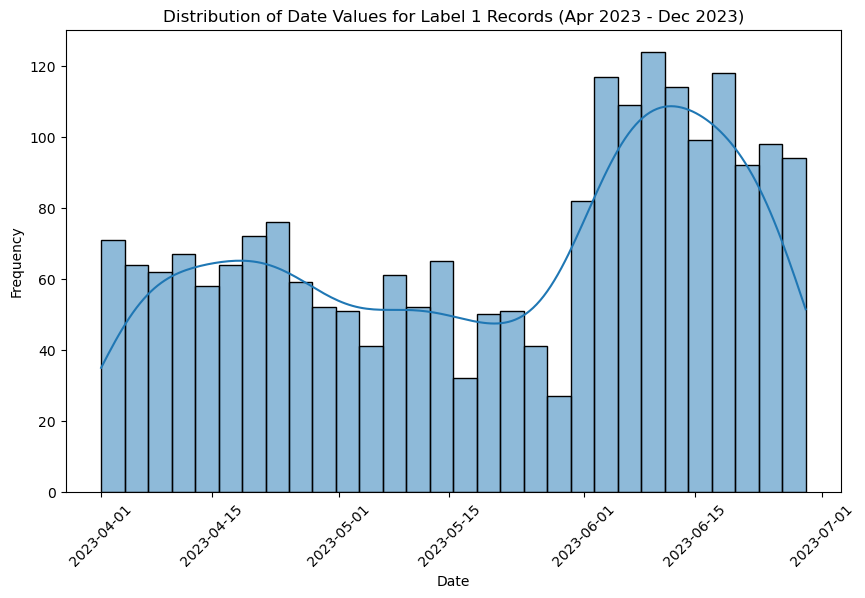

In [ ]:
# 조건에 맞는 레코드 필터링
filtered_data = df_eda[(df_eda['year_month'] >= '2023-04') &
                       (df_eda['year_month'] <= '2023-12') &
                       (df_eda['label'] == 1)]

# 'date' 컬럼을 datetime 형식으로 변환
filtered_data['date'] = pd.to_datetime(filtered_data['date'])

# 'date' 값들의 분포 시각화
plt.figure(figsize=(10, 6))
sns.histplot(filtered_data['date'], bins=30, kde=True)
plt.title('Distribution of Date Values for Label 1 Records (Apr 2023 - Dec 2023)')
plt.xlabel('Date')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()


# EDA : buydate_season

In [ ]:

df_eda['buydate'] = pd.to_datetime(df_eda['buydate'])

# buydate를 기반으로 계절과 년도를 결합한 새로운 컬럼 생성
df_eda['buydate_season_year'] = df_eda['buydate'].dt.year.astype(str) + ' ' + \
                                df_eda['buydate'].dt.month.apply(lambda x: 'Winter' if x in [12, 1, 2] else
                                                                 'Spring' if x in [3, 4, 5] else
                                                                 'Summer' if x in [6, 7, 8] else
                                                                 'Fall')

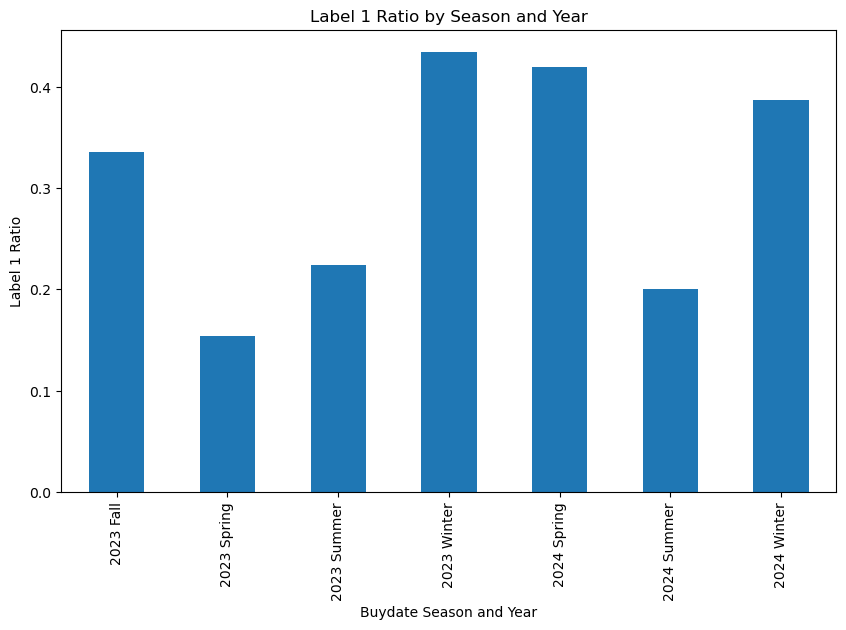

In [ ]:
# 1. 계절 별 label 1의 비율 계산 및 시각화
label_season_ratio = df_eda[df_eda['label'] == 1].groupby('buydate_season_year').size() / \
                    df_eda.groupby('buydate_season_year').size()

plt.figure(figsize=(10, 6))
label_season_ratio.plot(kind='bar')
plt.title('Label 1 Ratio by Season and Year')
plt.xlabel('Buydate Season and Year')
plt.ylabel('Label 1 Ratio')
plt.show()

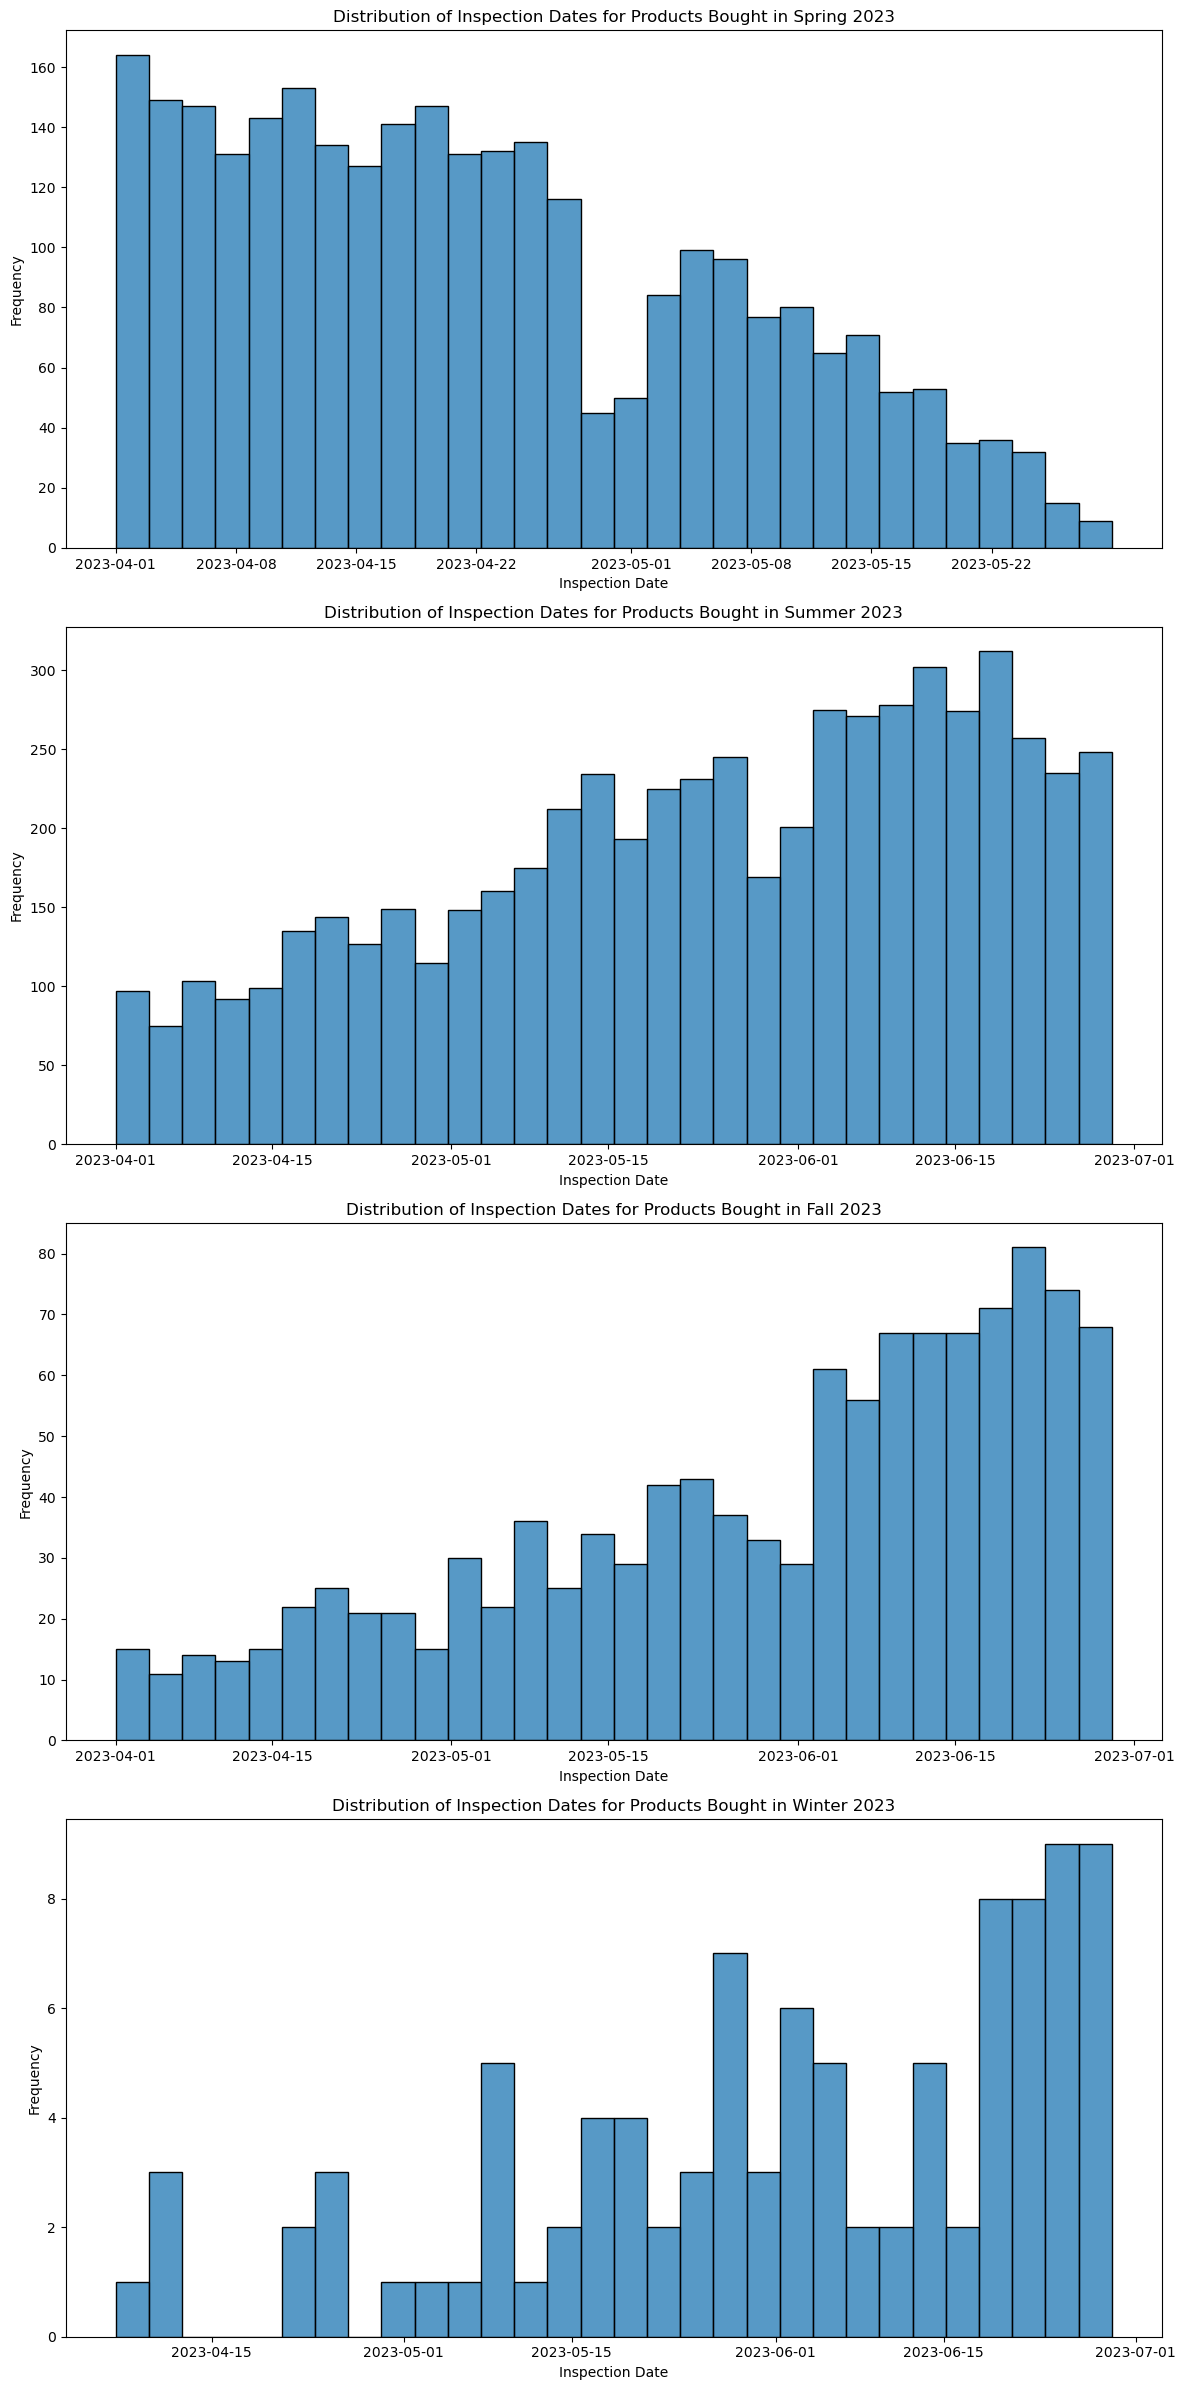

In [ ]:

# 2023년 각 계절별 구입 제품의 검수 일자(date) 분포 계산 및 시각화
seasons = ['Spring', 'Summer', 'Fall', 'Winter']
fig, axes = plt.subplots(4, 1, figsize=(12, 24))

for i, season in enumerate(seasons):
    season_data = df_eda[df_eda['buydate_season_year'] == f'2023 {season}']
    sns.histplot(season_data['date'], bins=30, ax=axes[i])
    axes[i].set_title(f'Distribution of Inspection Dates for Products Bought in {season} 2023')
    axes[i].set_xlabel('Inspection Date')
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


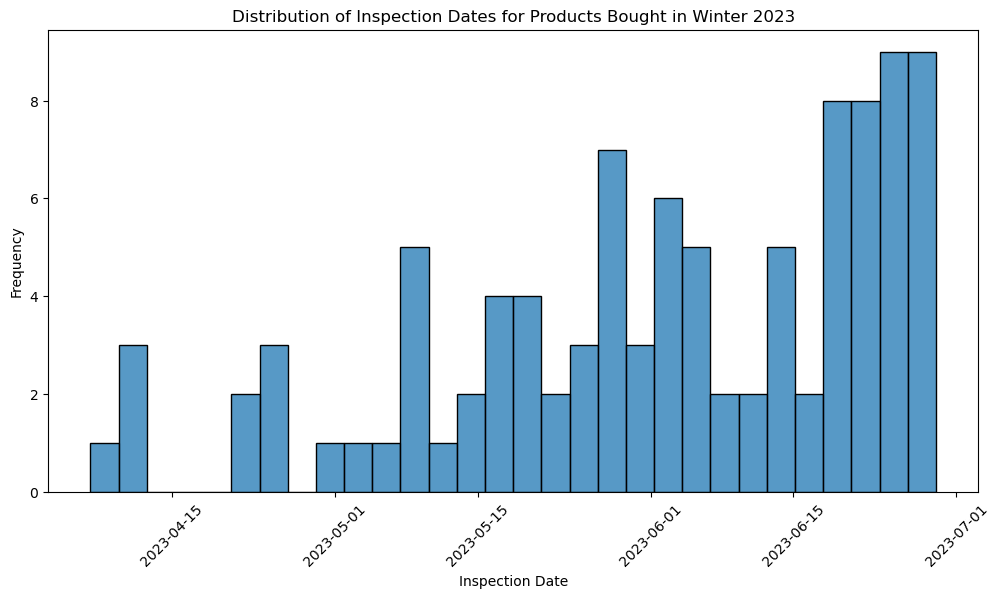

In [ ]:

winter_2023_buy = df_eda[(df_eda['buydate_season_year'] == '2023 Winter')]

# 검수 일자(date) 분포 시각화
plt.figure(figsize=(12, 6))
sns.histplot(winter_2023_buy['date'], bins=30)
plt.title('Distribution of Inspection Dates for Products Bought in Winter 2023')
plt.xlabel('Inspection Date')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()


<Figure size 1000x600 with 0 Axes>

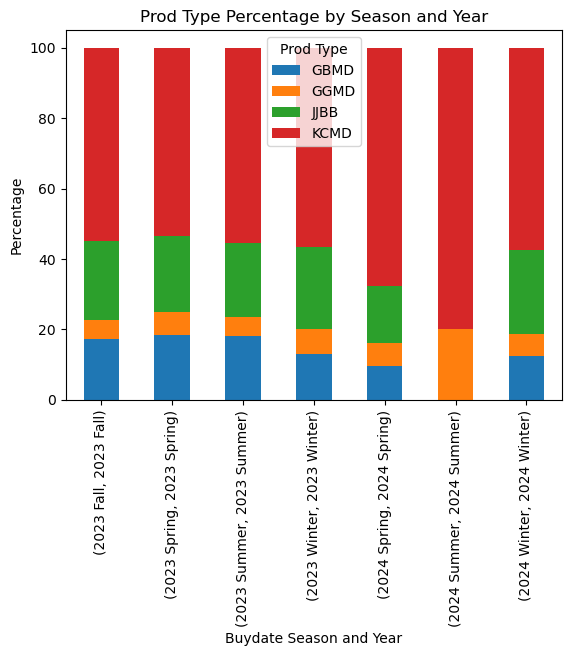

In [ ]:
# 2. buydate_season_year 각각에 대해서 prod 종류별 비율
prod_season_ratio = df_eda.groupby(['buydate_season_year', 'prod']).size().groupby(level=0).apply(lambda x: 100 * x / float(x.sum())).unstack()

plt.figure(figsize=(10, 6))
prod_season_ratio.plot(kind='bar', stacked=True)
plt.title('Prod Type Percentage by Season and Year')
plt.xlabel('Buydate Season and Year')
plt.ylabel('Percentage')
plt.legend(title='Prod Type')
plt.show()


<Figure size 1000x600 with 0 Axes>

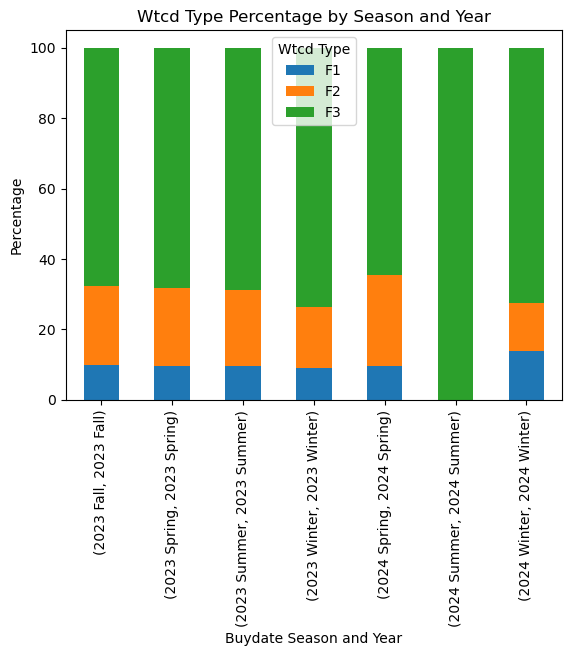

In [ ]:
# 3. buydate_season_year 각각에 따라 wtcd 종류별 비율
wtcd_season_ratio = df_eda.groupby(['buydate_season_year', 'wtcd']).size().groupby(level=0).apply(lambda x: 100 * x / float(x.sum())).unstack()

plt.figure(figsize=(10, 6))
wtcd_season_ratio.plot(kind='bar', stacked=True)
plt.title('Wtcd Type Percentage by Season and Year')
plt.xlabel('Buydate Season and Year')
plt.ylabel('Percentage')
plt.legend(title='Wtcd Type')
plt.show()

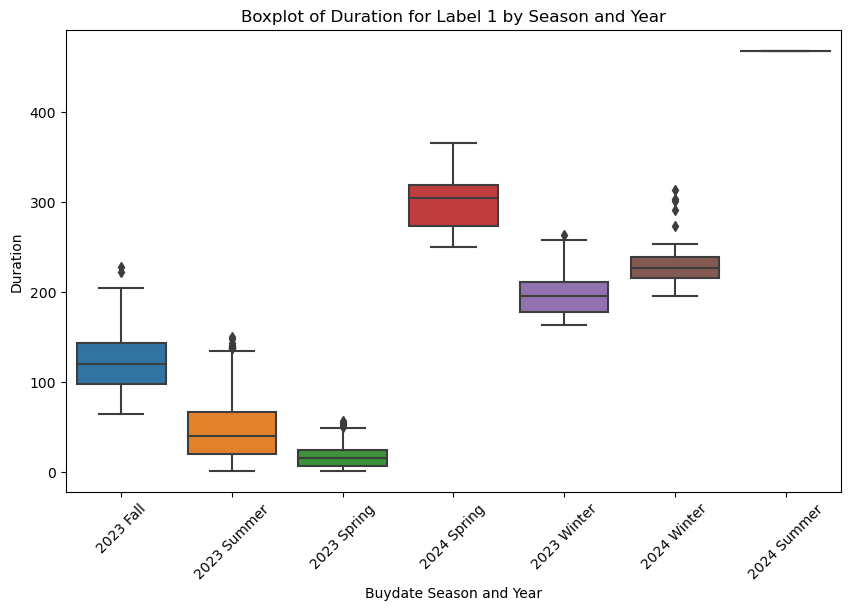

In [ ]:
# 5. buydate_season_year 각각에 대해 label 1인 경우의 duration의 boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='buydate_season_year', y='duration', data=df_eda[df_eda['label'] == 1])
plt.title('Boxplot of Duration for Label 1 by Season and Year')
plt.xlabel('Buydate Season and Year')
plt.ylabel('Duration')
plt.xticks(rotation=45)
plt.show()

In [ ]:
df_eda['duration'].mean()

50.559014916408046

# EDA : buydate_year

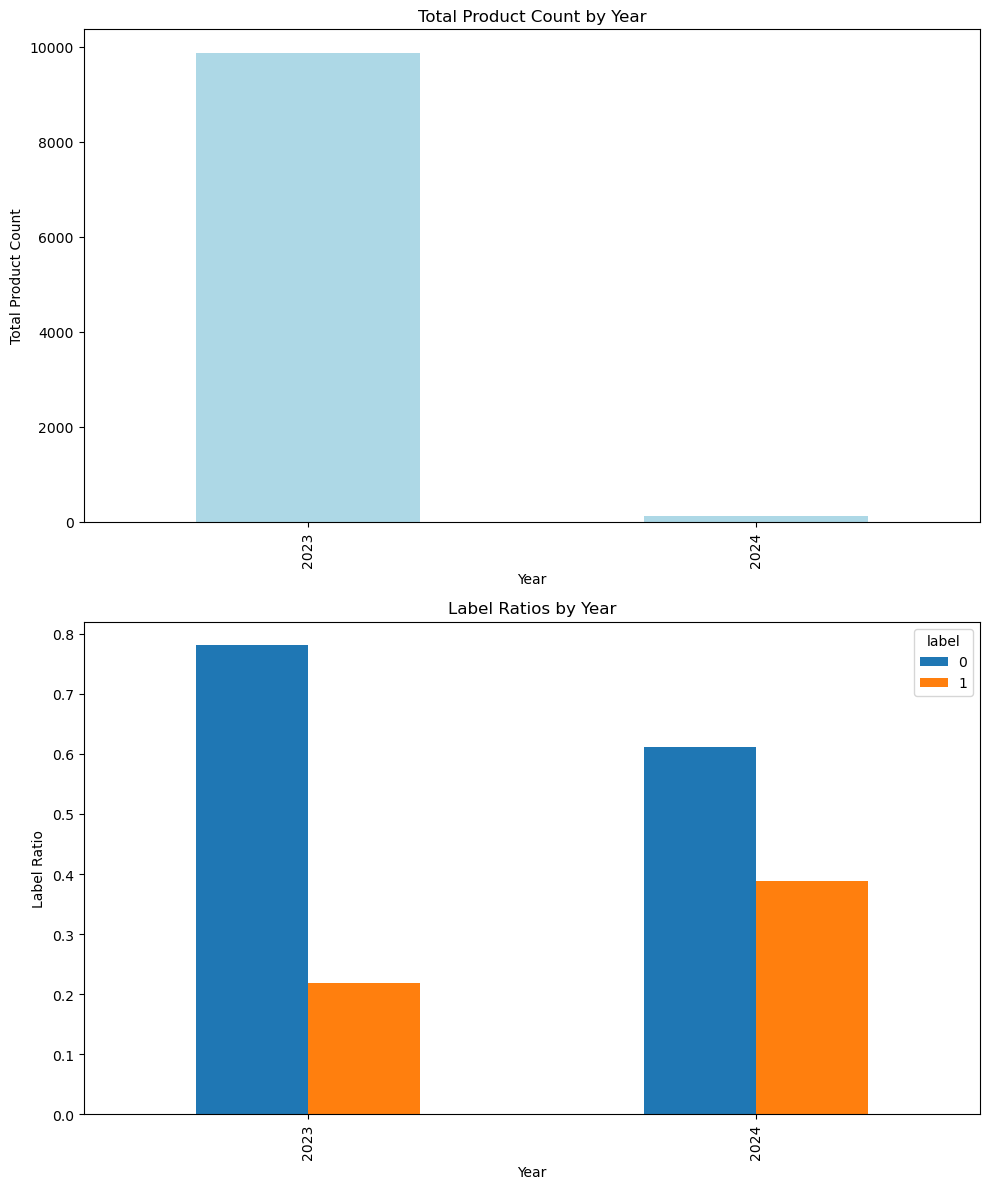

In [ ]:

# 각 년도별 총 제품의 개수 및 label 0과 1의 비율 계산
yearly_counts = df_eda.groupby('buydate_year')['label'].value_counts().unstack(fill_value=0)
yearly_totals = yearly_counts.sum(axis=1)
yearly_ratios = yearly_counts.div(yearly_totals, axis=0)

# 시각화
fig, axes = plt.subplots(2, 1, figsize=(10, 12))

# 첫 번째 subplot - 각 년도별 총 제품 개수
yearly_totals.plot(kind='bar', ax=axes[0], color='lightblue')
axes[0].set_title('Total Product Count by Year')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Total Product Count')

# 두 번째 subplot - 각 년도별 label 0과 1의 비율
yearly_ratios.plot(kind='bar', ax=axes[1])
axes[1].set_title('Label Ratios by Year')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Label Ratio')

plt.tight_layout()
plt.show()


In [ ]:
# buydate_year과 label에 따른 duration의 평균값 계산
duration_means_defect = df_eda[df_eda['label'] == 1].groupby('buydate_year')['duration'].mean()
duration_means_nondefect = df_eda[df_eda['label'] == 0].groupby('buydate_year')['duration'].mean()
# 결과 출력
print('불량품 :', duration_means_defect)
print('정상품 : ', duration_means_nondefect)


불량품 : buydate_year
2023     57.285714
2024    258.511111
Name: duration, dtype: float64
정상품 :  buydate_year
2023     45.426719
2024    271.154930
Name: duration, dtype: float64


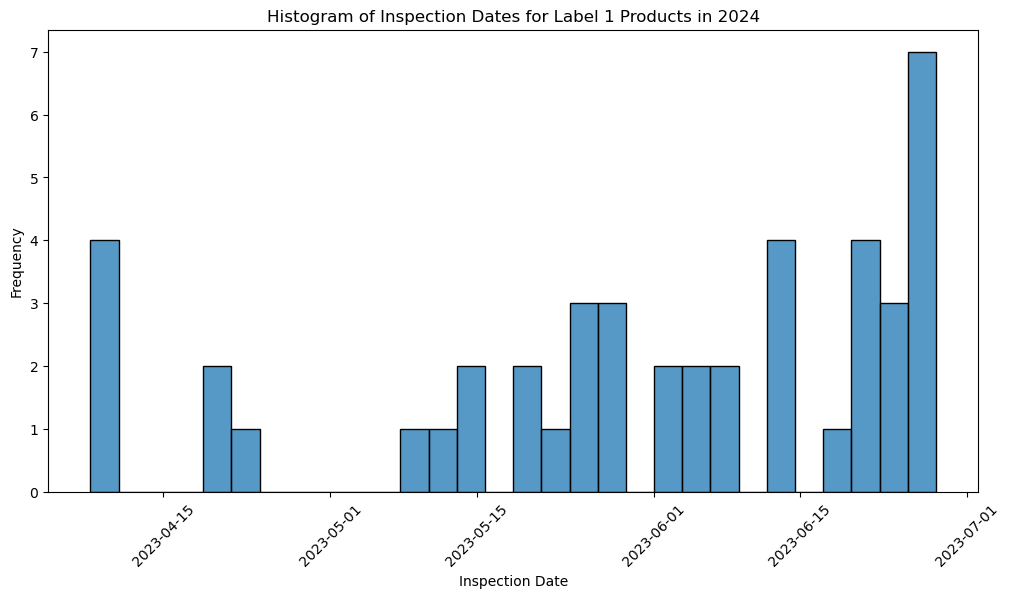

In [ ]:

# 2024년이고 label이 1인 데이터 필터링
df_2024_label1 = df_eda[(df_eda['buydate_year'] == 2024) & (df_eda['label'] == 1)]

# 필터링된 데이터의 'date' 컬럼에 대한 히스토그램 그리기
plt.figure(figsize=(12, 6))
sns.histplot(df_2024_label1['date'], bins=30)
plt.title('Histogram of Inspection Dates for Label 1 Products in 2024')
plt.xlabel('Inspection Date')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()


In [ ]:


# buydate_year의 년도 별 prod 종류별 비율 계산
prod_ratios_by_year = df_eda.groupby(['buydate_year', 'prod']).size().groupby(level=0).apply(lambda x: 100 * x / float(x.sum())).unstack()

# buydate_year의 년도 별 insp의 제품 검수 비율 계산
insp_ratios_by_year = df_eda.groupby(['buydate_year', 'insp']).size().groupby(level=0).apply(lambda x: 100 * x / float(x.sum())).unstack()

print('년도 별 Prod 종류별 비율:')
print(prod_ratios_by_year)
print('\n년도 별 Insp의 제품 검수 비율:')
print(insp_ratios_by_year)


년도 별 Prod 종류별 비율:
prod                            GBMD      GGMD       JJBB       KCMD
buydate_year buydate_year                                           
2023         2023          18.018839  5.854350  21.401803  54.725008
2024         2024          11.206897  6.896552  20.689655  61.206897

년도 별 Insp의 제품 검수 비율:
insp                               C          K          L         P  \
buydate_year buydate_year                                              
2023         2023          24.946825  24.491036  30.193457  4.993416   
2024         2024          24.137931  18.965517  34.482759  5.172414   

insp                               Y  
buydate_year buydate_year             
2023         2023          15.375266  
2024         2024          17.241379  


# EDA 끝

In [ ]:
len(df_eda.columns)

25

In [ ]:
df_eda

prod insp       date    buydate    ingr_A  ingr_B  ingr_C wtcd     gram  \
0     GBMD    C 2023-06-18 2023-09-18  399.4063  6.4035  6.9409   F3   970.32   
1     GGMD    L 2023-05-18 2023-07-08  130.0951  5.8245  6.2857   F1  2490.08   
2     KCMD    C 2023-05-05 2023-07-02  131.5192  5.8040  6.0607   F3   487.37   
3     GBMD    K 2023-05-05 2023-06-04  128.5978  6.8720  6.1705   F3   707.94   
4     JJBB    K 2023-04-09 2023-04-14  320.6915  5.7474  6.3695   F3  1978.66   
...    ...  ...        ...        ...       ...     ...     ...  ...      ...   
9995  KCMD    C 2023-06-20 2023-07-08  405.6626  6.2900  6.8467   F3   777.82   
9996  GGMD    K 2023-05-15 2023-05-25  129.1664  6.0345  6.5257   F3  2548.73   
9997  GGMD    L 2023-06-14 2023-09-10  403.9895  6.2698  6.7227   F1  2769.71   
9998  JJBB    K 2023-04-05 2023-04-16  309.4751  5.7987  6.5499   F3  2005.46   
9999  JJBB    C 2023-04-03 2023-05-02  328.3941  5.8472  5.9838   F3  1985.14   

     생산지  ...   extra_P  duration  date_month  buydate_month  buydate_season  \
0     산천  ...  0.574624        92           6              9            Fall   
1     창하  ...  0.942891        51           5              7          Summer   
2     창하  ...  0.705801        58           5              7          Summer   
3     산천  ...  0.799926        30           5              6          Summer   
4     수성  ...  0.831801         5           4              4          Spring   
...   ..  ...       ...       ...         ...            ...             ...   
9995  산천  ...  0.461573        18           6              7          Summer   
9996  오포  ...  0.944393        10           5              5          Spring   
9997  창하  ...  0.849449        88           6              9            Fall   
9998  산천  ...  0.839526        11           4              4          Spring   
9999  오포  ...  0.828614        29           4              5          Spring   

      buydate_year  date_half_month             bin  year_month  \
0             2023              6_2  (0.543, 0.599]     2023-09   
1             2023              5_2  (0.937, 0.994]     2023-07   
2             2023              5_1  (0.655, 0.712]     2023-07   
3             2023              5_1  (0.768, 0.825]     2023-06   
4             2023              4_1  (0.825, 0.881]     2023-04   
...            ...              ...             ...         ...   
9995          2023              6_2  (0.429, 0.486]     2023-07   
9996          2023              5_1  (0.937, 0.994]     2023-05   
9997          2023              6_1  (0.825, 0.881]     2023-09   
9998          2023              4_1  (0.825, 0.881]     2023-04   
9999          2023              4_1  (0.825, 0.881]     2023-05   

     buydate_season_year  
0              2023 Fall  
1            2023 Summer  
2            2023 Summer  
3            2023 Summer  
4            2023 Spring  
...                  ...  
9995         2023 Summer  
9996         2023 Spring  
9997           2023 Fall  
9998         2023 Spring  
9999         2023 Spring  

[9989 rows x 25 columns]

# EDA 결론으로 feature 최대한 추려서 dataframe 재구성

In [ ]:
df = df_eda.copy()

In [ ]:
selected_columns = ['prod', 'insp', 'wtcd', 'gram', '생산지', 'A_P', 'B_P', 'C_P', 'extra_P', 'duration', 'date_half_month', 'label']
df = df[selected_columns]

df.head()

prod insp wtcd     gram 생산지       A_P       B_P       C_P   extra_P  \
0  GBMD    C   F3   970.32  산천  0.411623  0.006599  0.007153  0.574624   
1  GGMD    L   F1  2490.08  창하  0.052245  0.002339  0.002524  0.942891   
2  KCMD    C   F3   487.37  창하  0.269855  0.011909  0.012436  0.705801   
3  GBMD    K   F3   707.94  산천  0.181651  0.009707  0.008716  0.799926   
4  JJBB    K   F3  1978.66  수성  0.162075  0.002905  0.003219  0.831801   

   duration date_half_month  label  
0        92             6_2      1  
1        51             5_2      0  
2        58             5_1      0  
3        30             5_1      1  
4         5             4_1      0

In [ ]:
# EDA, 전처리 후의 모델 훈련위한 최종적인 csv 파일 도출

df.to_csv('after_eda.csv', index = False)

# 데이터 다운받기

In [ ]:
df = pd.read_csv('after_eda.csv', encoding = 'utf-8')

In [ ]:
df.head()

prod insp wtcd     gram 생산지       A_P       B_P       C_P   extra_P  \
0  GBMD    C   F3   970.32  산천  0.411623  0.006599  0.007153  0.574624   
1  GGMD    L   F1  2490.08  창하  0.052245  0.002339  0.002524  0.942891   
2  KCMD    C   F3   487.37  창하  0.269855  0.011909  0.012436  0.705801   
3  GBMD    K   F3   707.94  산천  0.181651  0.009707  0.008716  0.799926   
4  JJBB    K   F3  1978.66  수성  0.162075  0.002905  0.003219  0.831801   

   duration date_half_month  label  
0        92             6_2      1  
1        51             5_2      0  
2        58             5_1      0  
3        30             5_1      1  
4         5             4_1      0

# Import

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve
from sklearn.pipeline import make_pipeline

# label 인코딩 : date_half_month

In [ ]:
# 레이블 인코더 초기화
label_encoder = LabelEncoder()

# 순서를 정의
order = ['4_1', '4_2', '5_1', '5_2', '6_1', '6_2']

# 레이블 인코더에 정의한 순서를 학습시킴
label_encoder.fit(order)

# 데이터에 레이블 인코딩 적용
df['date_half_month_encoded'] = label_encoder.transform(df['date_half_month'])

# 결과 확인
df[['date_half_month', 'date_half_month_encoded']].head()
df = df.drop('date_half_month', axis = 1)

# One-hot 인코딩 : 'prod', 'insp', 'wtcd', '생산지' - 여기부터 시작

In [ ]:
# OneHotEncoder 초기화 및 인코딩 수행
encoder = OneHotEncoder(sparse_output=False)
encoded_data = encoder.fit_transform(df[['prod', 'insp', 'wtcd', '생산지']])

# 인코딩된 데이터를 DataFrame으로 변환
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(['prod', 'insp', 'wtcd', '생산지']))

df = df.drop(['prod', 'insp', 'wtcd', '생산지'], axis = 1)

df = pd.concat([df, encoded_df], axis=1)

In [ ]:
df.to_csv('encodedTrain.csv', index = False)

# train/val dataset 구분 및 x/y 분리

In [ ]:
train_set, validation_set = train_test_split(df, test_size = 0.3, random_state = 42)
# train_set 데이터프레임에서 특성과 타겟 변수 분리
x_train = train_set.drop('label', axis=1)  # 'label' 컬럼을 제외한 모든 컬럼을 특성 데이터로 사용
y_train = train_set['label']  # 'label' 컬럼을 타겟 변수로 사용
x_val = validation_set.drop('label', axis = 1)
y_val = validation_set['label']

# cross validation 위한 train dataset

In [ ]:
x_train_cv = df.drop('label', axis = 1)
y_train_cv = df['label']

# PCA

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# PCA 수행 (3개의 주요 구성 요소)
pca = PCA(n_components=3)
pca_transformed = pca.fit_transform(train_set)

# 3차원 좌표 설정
train_set['pca_x'] = pca_transformed[:, 0]
train_set['pca_y'] = pca_transformed[:, 1]
train_set['pca_z'] = pca_transformed[:, 2]

# 레이블 별 인덱스 설정
marker0 = train_set[train_set['label'] == 0].index
marker1 = train_set[train_set['label'] == 1].index

# 3D 산점도 생성
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# 레이블 별 산점도
ax.scatter(train_set.loc[marker0, 'pca_x'], train_set.loc[marker0, 'pca_y'], train_set.loc[marker0, 'pca_z'], marker='o')
ax.scatter(train_set.loc[marker1, 'pca_x'], train_set.loc[marker1, 'pca_y'], train_set.loc[marker1, 'pca_z'], marker='^')

ax.set_xlabel('PCA1')
ax.set_ylabel('PCA2')
ax.set_zlabel('PCA3')
plt.title('3 Clusters Visualization by 3 PCA Components')
plt.legend(['cluster0', 'cluster1'])
plt.show()


# 머신러닝 기법 : 결정트리모델

- 결정트리

In [ ]:
# 결정트리 모델 생성
decision_tree = DecisionTreeClassifier(random_state=42, criterion='entropy')

# 교차 검증 수행 + 각 폴드의 예측 확률 계산
y_prob = cross_val_predict(decision_tree, x_train_cv, y_train_cv, cv=5, method = 'predict_proba')

#예측 확률 중 클래스 1에 대한 확률
y_probs_positive = y_prob[:, 1]

#AUC
auc_score = roc_auc_score(y_train_cv, y_probs_positive)

print("교차 검증 AUC : ", auc_score)

교차 검증 AUC :  0.5271156782407537


- ROC Curve 시각화

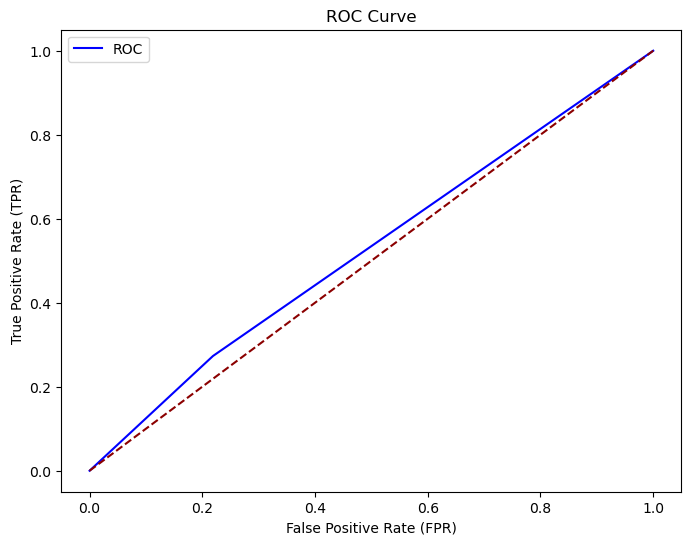

In [ ]:
fpr, tpr, thresholds = roc_curve(y_train_cv, y_probs_positive)

# ROC 커브 그리기
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='ROC')
plt.plot([0, 1], [0, 1], color='darkred', linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend()
plt.show()

- TPR vs FNR

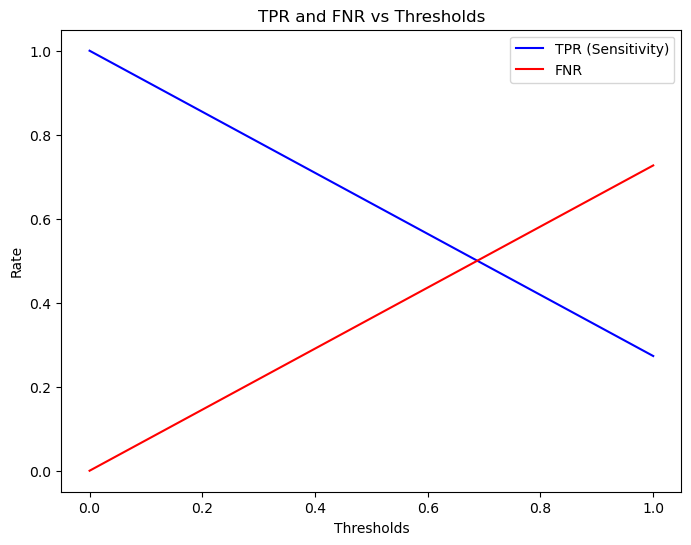

In [ ]:
# FNR 계산 (FNR = 1 - TPR)
fnr = 1 - tpr

# TPR과 FNR 그래프 그리기
plt.figure(figsize=(8, 6))
plt.plot(thresholds, tpr, color='blue', label='TPR (Sensitivity)')
plt.plot(thresholds, fnr, color='red', label='FNR')
plt.xlabel('Thresholds')
plt.ylabel('Rate')
plt.title('TPR and FNR vs Thresholds')
plt.legend()
plt.show()


/home/ryoonki/anaconda3/envs/ryoonki/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 49373 (\N{HANGUL SYLLABLE SAENG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/ryoonki/anaconda3/envs/ryoonki/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 49328 (\N{HANGUL SYLLABLE SAN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/ryoonki/anaconda3/envs/ryoonki/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 51648 (\N{HANGUL SYLLABLE JI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/ryoonki/anaconda3/envs/ryoonki/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 50724 (\N{HANGUL SYLLABLE O}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/ryoonki/anaconda3/envs/ryoonki/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 54252 (\N{HANGUL 

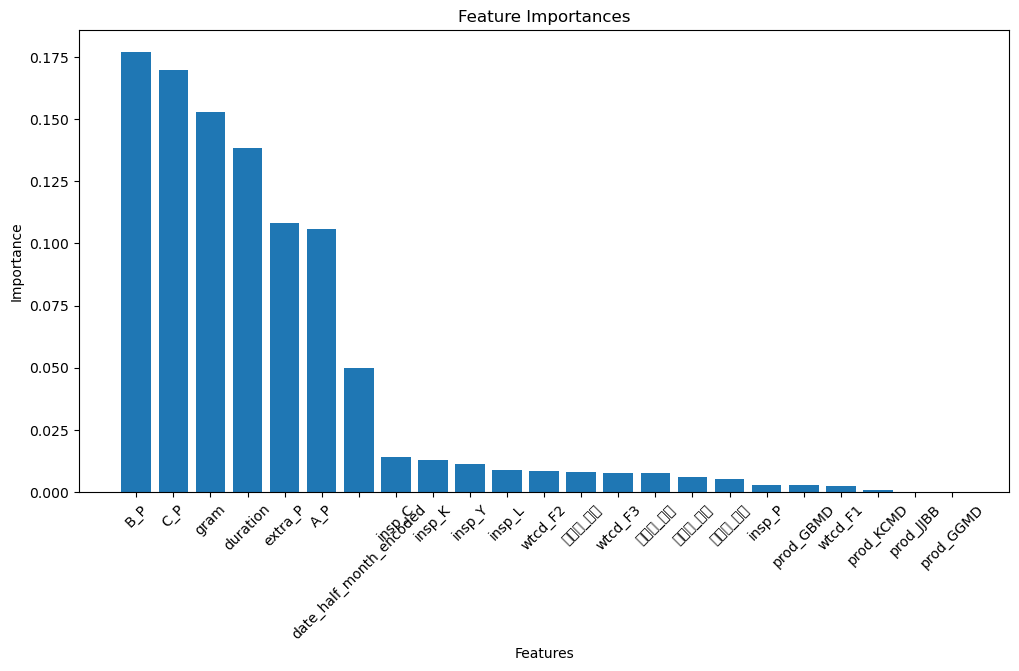

In [ ]:
decision_tree.fit(x_train_cv, y_train_cv)

feature_importances = decision_tree.feature_importances_

# 특성 이름과 중요도를 DataFrame으로 변환
feature_importances_df = pd.DataFrame({'Feature': x_train.columns, 'Importance': feature_importances})

# 중요도에 따라 특성 정렬
feature_importances_df = feature_importances_df.sort_values('Importance', ascending=False)

# 중요도가 높은 상위 특성을 그래프로 표현
plt.figure(figsize=(12, 6))
plt.bar(feature_importances_df['Feature'], feature_importances_df['Importance'])
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=45)
plt.title('Feature Importances')
plt.show()

    # 결정 트리의 하이퍼 파라미터 조정 (class_weight, max_features)

# Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_auc_score

# 랜덤포레스트 모델 생성
random_forest = RandomForestClassifier(criterion = 'gini', min_samples_leaf = 1, oob_score = True, random_state=42, n_jobs = -1)

# 교차 검증 수행 + 각 폴드의 예측 확률 계산
y_probs_rf = cross_val_predict(random_forest, x_train_cv, y_train_cv, cv=5, method='predict_proba')

# 양성 클래스에 대한 예측 확률
y_probs_positive_rf = y_probs_rf[:, 1]

# AUC 점수 계산
auc_score_rf = roc_auc_score(y_train_cv, y_probs_positive_rf)
print("랜덤포레스트 교차 검증 AUC :", auc_score_rf)


랜덤포레스트 교차 검증 AUC : 0.6243404712147204


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
# 하이퍼파라미터 튜닝하기

# 랜덤포레스트 분류기 설정
rf_classifier = RandomForestClassifier(random_state=42)

# 탐색할 하이퍼파라미터 그리드 설정
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2', None]
}

# 그리드 서치 설정: AUC 점수를 사용하여 평가
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, scoring='roc_auc', cv=5, n_jobs=-1)

# 그리드 서치 수행
grid_search = grid_search.fit(x_train_cv, y_train_cv)

# 최적의 하이퍼파라미터와 그 때의 AUC 점수 출력
print("최적의 파라미터:", grid_search.best_params_)
print("최고 AUC 점수:", grid_search.best_score_)


/home/ryoonki/anaconda3/envs/ryoonki/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/home/ryoonki/anaconda3/envs/ryoonki/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
540 fits failed out of a total of 2160.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
329 fits failed with the following error:
Traceback (most recent call last):
  File "/home/ryoonki/anaconda3/envs/ryoonki/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **f

최적의 파라미터: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
최고 AUC 점수: 0.6590854641582723


In [ ]:
rf_classifier_optimized = RandomForestClassifier(
    max_depth=5,
    max_features='sqrt',
    min_samples_leaf=2,
    min_samples_split=5,
    n_estimators=200,
    random_state= 10
)
# 교차 검증 수행 + 각 폴드의 예측 확률 계산
y_probs_rf = cross_val_predict(rf_classifier_optimized, x_train_cv, y_train_cv, cv=5, method='predict_proba')

# 양성 클래스에 대한 예측 확률
y_probs_positive_rf = y_probs_rf[:, 1]

# AUC 점수 계산
auc_score_rf = roc_auc_score(y_train_cv, y_probs_positive_rf)
print("랜덤포레스트 교차 검증 AUC :", auc_score_rf)

랜덤포레스트 교차 검증 AUC : 0.6564373932507465


# Boosting

In [ ]:
import xgboost as xgb
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_auc_score

# XGBoost 분류기 생성
xgb_model = xgb.XGBClassifier(random_state=42)

# 교차 검증을 통한 예측 확률 계산
y_probs_xgb = cross_val_predict(xgb_model, x_train_cv, y_train_cv, cv=5, method='predict_proba')

# 양성 클래스에 대한 예측 확률
y_probs_positive_xgb = y_probs_xgb[:, 1]

# AUC 점수 계산
auc_score_xgb = roc_auc_score(y_train_cv, y_probs_positive_xgb)
print("XGBoost 교차 검증 AUC :", auc_score_xgb)


XGBoost 교차 검증 AUC : 0.6173707460946303


In [ ]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

# XGBoost 분류기 생성
xgb_model = xgb.XGBClassifier(random_state=42)

# 탐색할 하이퍼파라미터 그리드 설정
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.001, 0.005, 0.01, 0.1, 0.2],
    # 여기에 추가적인 하이퍼파라미터 조합을 추가할 수 있습니다.
}

# 그리드 서치 설정: AUC 점수를 사용하여 평가
grid_search_xgb = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='roc_auc', cv=5, n_jobs=-1)

# 그리드 서치 수행
grid_search_xgb = grid_search_xgb.fit(x_train_cv, y_train_cv)

# 최적의 하이퍼파라미터와 그 때의 AUC 점수 출력
print("최적의 파라미터:", grid_search_xgb.best_params_)
print("최고 AUC 점수:", grid_search_xgb.best_score_)


최적의 파라미터: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300}
최고 AUC 점수: 0.657826203845743


In [ ]:
xgb_model_optimized = xgb.XGBClassifier(
    n_estimators=300,
    max_depth = 3,
    learning_rate = 0.01,
    random_state= 42
)
# 교차 검증 수행 + 각 폴드의 예측 확률 계산
y_probs_rf = cross_val_predict(xgb_model_optimized, x_train_cv, y_train_cv, cv=5, method='predict_proba')

# 양성 클래스에 대한 예측 확률
y_probs_positive_rf = y_probs_rf[:, 1]

# AUC 점수 계산
auc_score_rf = roc_auc_score(y_train_cv, y_probs_positive_rf)
print("랜덤포레스트 교차 검증 AUC :", auc_score_rf)

랜덤포레스트 교차 검증 AUC : 0.6568338031697427


# Blending

In [ ]:
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import roc_auc_score

# PCA 변환기 생성 및 적합
pca = PCA(n_components=8)
x_train_pca = pca.fit_transform(x_train)
x_val_pca = pca.transform(x_val)

# XGBoost와 랜덤포레스트 모델 생성 및 훈련
xgb_model = xgb.XGBClassifier(n_estimators=300, max_depth=3, learning_rate=0.01, random_state=42)
rf_classifier = RandomForestClassifier(max_depth=5, max_features='sqrt', min_samples_leaf=2, min_samples_split=5, n_estimators=200, random_state=42)

xgb_model.fit(x_train_pca, y_train)
rf_classifier.fit(x_train_pca, y_train)

# 검증 데이터셋에 대한 예측 확률 계산
y_val_probs_xgb = xgb_model.predict_proba(x_val_pca)[:, 1]
y_val_probs_rf = rf_classifier.predict_proba(x_val_pca)[:, 1]

# 두 모델의 예측 확률을 평균 내어 최종 예측 확률을 계산
y_val_probs_blended = (y_val_probs_xgb + y_val_probs_rf) / 2

# 최종 예측 확률을 이용하여 검증 데이터셋에 대한 AUC 점수 계산
auc_score_val = roc_auc_score(y_val, y_val_probs_blended)
print("검증 데이터셋의 AUC (Blending with PCA):", auc_score_val)


검증 데이터셋의 AUC (Blending with PCA): 0.661306838211611


In [ ]:
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import roc_auc_score

# XGBoost와 랜덤포레스트 모델 생성 및 훈련
xgb_model = xgb.XGBClassifier(n_estimators=300, max_depth=3, learning_rate=0.01, random_state=42)
rf_classifier = RandomForestClassifier(max_depth=5, max_features='sqrt', min_samples_leaf=2, min_samples_split=5, n_estimators=200, random_state=42)

xgb_model.fit(x_train, y_train)
rf_classifier.fit(x_train, y_train)

# 검증 데이터셋에 대한 예측 확률 계산
y_val_probs_xgb = xgb_model.predict_proba(x_val)[:, 1]
y_val_probs_rf = rf_classifier.predict_proba(x_val)[:, 1]

# 두 모델의 예측 확률을 평균 내어 최종 예측 확률을 계산
y_val_probs_blended = (y_val_probs_xgb + y_val_probs_rf) / 2

# 최종 예측 확률을 이용하여 검증 데이터셋에 대한 AUC 점수 계산
auc_score_val = roc_auc_score(y_val, y_val_probs_blended)
print("검증 데이터셋의 AUC (Blending):", auc_score_val)


검증 데이터셋의 AUC (Blending): 0.6594868361319708


# Stacking

In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
# XGBoost와 랜덤포레스트 모델 생성

xgb_model = xgb.XGBClassifier(
    n_estimators=300,
    max_depth=3,
    learning_rate=0.01,
    random_state=42
)
rf_classifier = RandomForestClassifier(
    max_depth=5,
    max_features='sqrt',
    min_samples_leaf=2,
    min_samples_split=5,
    n_estimators=200,
    random_state=42
)

# 스태킹 앙상블 모델 생성
stacking_clf = StackingClassifier(
    estimators=[('xgb', xgb_model), ('rf', rf_classifier)],
    final_estimator = LogisticRegression()
)

# 모델 훈련 (SMOTE 적용된 데이터 사용)
stacking_clf.fit(x_train, y_train)

# 검증 데이터셋에 대한 예측 확률 계산
y_val_probs = stacking_clf.predict_proba(x_val)[:, 1]

# 검증 데이터셋에 대한 AUC 점수 계산
auc_score_val = roc_auc_score(y_val, y_val_probs)
print("검증 데이터셋의 AUC :", auc_score_val)


검증 데이터셋의 AUC : 0.6593219866142193


In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

# XGBoost와 랜덤포레스트 모델 생성

# PCA 변환기 생성 및 적합
pca = PCA(n_components=8)
x_train_pca = pca.fit_transform(x_train)
x_val_pca = pca.transform(x_val)

xgb_model = xgb.XGBClassifier(
    n_estimators=300,
    max_depth=3,
    learning_rate=0.01,
    random_state=42
)
rf_classifier = RandomForestClassifier(
    max_depth=5,
    max_features='sqrt',
    min_samples_leaf=2,
    min_samples_split=5,
    n_estimators=200,
    random_state=42
)

# 스태킹 앙상블 모델 생성
stacking_clf = StackingClassifier(
    estimators=[('xgb', xgb_model), ('rf', rf_classifier)],
    final_estimator = LogisticRegression()
)

# # 모델 훈련 (pca 적용된 data)
stacking_clf.fit(x_train_pca, y_train)


StackingClassifier(estimators=[('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              feature_types=None, gamma=None,
                                              gpu_id=None, grow_policy=None,
                                              importance_type=None,
                                              interaction_constraints=None,
                                              learning_...
                                              max_delta_step=None, max_depth=3,
                                              max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              n_estimators=300, n_jobs=None,
                                              num_parallel_tree=None,
                                              predictor=None, random_state=42, ...)),
                               ('rf',
                                RandomForestClassifier(max_depth=5,
                                                       min_samples_leaf=2,
                                                       min_samples_split=5,
                                                       n_estimators=200,
                                                       random_state=42))],
                   final_estimator=LogisticRegression())

# ML 모델 시각화 : Stacking

검증 데이터셋의 F1 점수: 0.03151862464183381


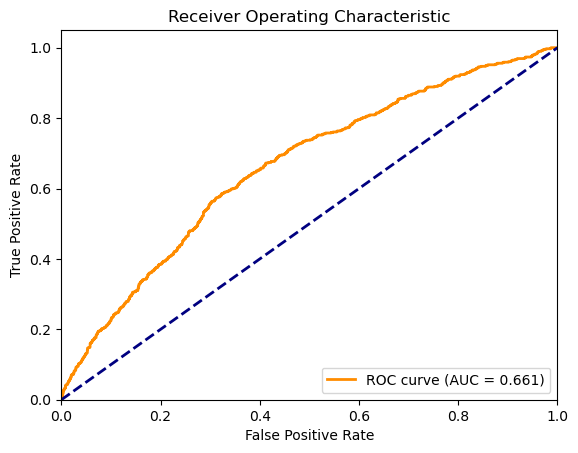

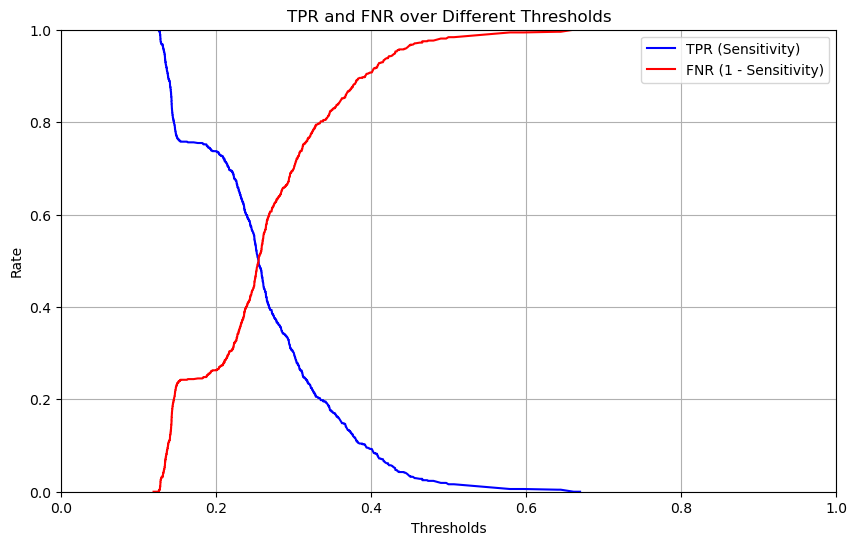

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, roc_curve, auc

# 검증 데이터셋에 대한 예측값 계산
y_val_pred = stacking_clf.predict(x_val_pca)

# F1 점수 계산
f1_val = f1_score(y_val, y_val_pred)
print("검증 데이터셋의 F1 점수:", f1_val)

# 예측 확률 계산
y_val_probs = stacking_clf.predict_proba(x_val_pca)[:, 1]

# ROC 곡선 및 AUC 점수 계산
fpr, tpr, thresholds = roc_curve(y_val, y_val_probs)
roc_auc = auc(fpr, tpr)

# ROC 곡선 시각화
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# FNR 계산
fnr = 1 - tpr

# TPR과 FNR 시각화
plt.figure(figsize=(10, 6))
plt.plot(thresholds, tpr, label='TPR (Sensitivity)', color='blue')
plt.plot(thresholds, fnr, label='FNR (1 - Sensitivity)', color='red')
plt.title('TPR and FNR over Different Thresholds')
plt.xlabel('Thresholds')
plt.ylabel('Rate')
plt.xlim([0, 1])
plt.ylim([0, 1])
# plt.gca().invert_xaxis() # 임계값이 높을수록 TPR과 FNR이 낮아지므로 x축을 반전시킵니다.
plt.legend(loc='best')
plt.grid(True)
plt.show()


# Test dataset 전처리

In [ ]:
df = pd.read_csv('encodedTest.csv', encoding = 'utf-8')

In [ ]:
x_test = df.drop('label', axis = 1)
y_test = df['label']

In [ ]:
y_train.shape

(6992,)

In [ ]:
x_t_pca.shape

(39976, 8)

In [ ]:
x_train_pca.shape

(9989, 8)

In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

# XGBoost와 랜덤포레스트 모델 생성

# PCA 변환기 생성 및 적합
pca = PCA(n_components=8)
x_train_pca = pca.fit_transform(x_train_cv)
x_test_pca = pca.transform(x_test)

xgb_model = xgb.XGBClassifier(
    n_estimators=300,
    max_depth=3,
    learning_rate=0.01,
    random_state=42
)
rf_classifier = RandomForestClassifier(
    max_depth=5,
    max_features='sqrt',
    min_samples_leaf=2,
    min_samples_split=5,
    n_estimators=200,
    random_state=42
)

# 스태킹 앙상블 모델 생성
stacking_clf = StackingClassifier(
    estimators=[('xgb', xgb_model), ('rf', rf_classifier)],
    final_estimator = LogisticRegression()
)

# 모델 훈련 (pca 적용된 data)
stacking_clf.fit(x_train_pca, y_train_cv)


StackingClassifier(estimators=[('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              feature_types=None, gamma=None,
                                              gpu_id=None, grow_policy=None,
                                              importance_type=None,
                                              interaction_constraints=None,
                                              learning_...
                                              max_delta_step=None, max_depth=3,
                                              max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              n_estimators=300, n_jobs=None,
                                              num_parallel_tree=None,
                                              predictor=None, random_state=42, ...)),
                               ('rf',
                                RandomForestClassifier(max_depth=5,
                                                       min_samples_leaf=2,
                                                       min_samples_split=5,
                                                       n_estimators=200,
                                                       random_state=42))],
                   final_estimator=LogisticRegression())

검증 데이터셋의 F1 점수: 0.0350722399911768


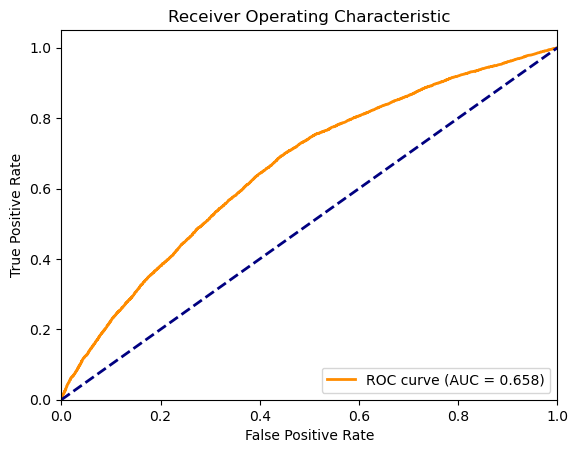

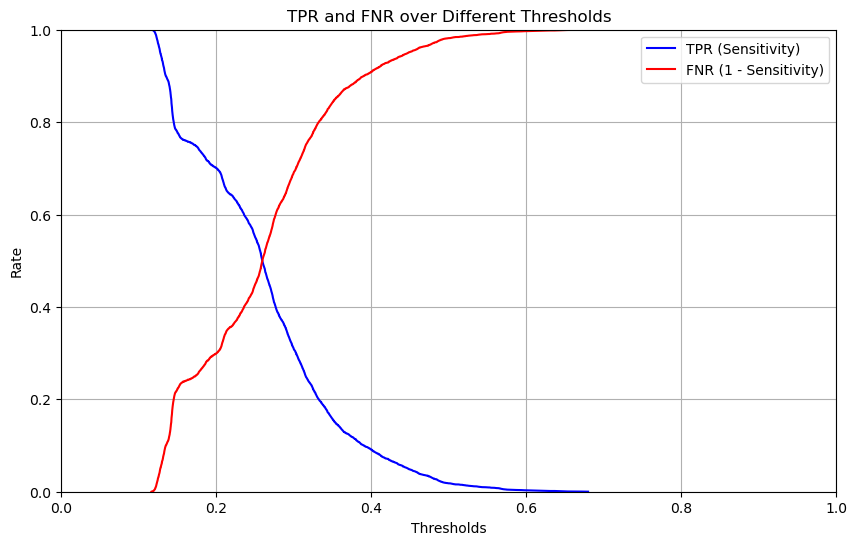

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, roc_curve, auc

# 검증 데이터셋에 대한 예측값 계산
y_test_pred = stacking_clf.predict(x_test_pca)

# F1 점수 계산
f1_val = f1_score(y_test, y_test_pred)
print("검증 데이터셋의 F1 점수:", f1_val)

# 예측 확률 계산
y_test_probs = stacking_clf.predict_proba(x_test_pca)[:, 1]

# ROC 곡선 및 AUC 점수 계산
fpr, tpr, thresholds = roc_curve(y_test, y_test_probs)
roc_auc = auc(fpr, tpr)

# ROC 곡선 시각화
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# FNR 계산
fnr = 1 - tpr

# TPR과 FNR 시각화
plt.figure(figsize=(10, 6))
plt.plot(thresholds, tpr, label='TPR (Sensitivity)', color='blue')
plt.plot(thresholds, fnr, label='FNR (1 - Sensitivity)', color='red')
plt.title('TPR and FNR over Different Thresholds')
plt.xlabel('Thresholds')
plt.ylabel('Rate')
plt.xlim([0, 1])
plt.ylim([0, 1])
# plt.gca().invert_xaxis() # 임계값이 높을수록 TPR과 FNR이 낮아지므로 x축을 반전시킵니다.
plt.legend(loc='best')
plt.grid(True)
plt.show()
